In [1]:
import tensorflow as tf
import numpy as np
from tensorflow import keras
from tensorflow.keras import layers
import pandas as pd
import matplotlib.pyplot as plt
import sys
sys.path.append("..") # Adds higher directory to python modules path.
import os
import numpy as np
import sys
import os

from skimage.filters import gaussian as gblur
from PIL import Image as PILImage

sys.path.append("..") # Adds higher directory to python modules path.
import brevis
from brevis import branches
from brevis import evaluate
# os.environ['TF_DETERMINISTIC_OPS'] = '1'

In [2]:
train_ds, test_ds, validation_ds = brevis.dataset.prepare.dataset(tf.keras.datasets.cifar10.load_data(),32,5000,shuffle_size=15000,input_size=(32,32),include_targets=False,num_outputs = 10,reshuffle=True)

augment Dataset
targetsis : False
trainSize 45000
testSize 10000


In [3]:
# import tensorflow_datasets as tfds
# ds = tfds.load('svhn_cropped', split='train', shuffle_files=True)
# assert isinstance(ds, tf.data.Dataset)
train_ds100, test_ds100, validation_ds100 = brevis.dataset.prepare.dataset(tf.keras.datasets.cifar100.load_data(label_mode="fine"),32,5000,shuffle_size=15000,input_size=(32,32),include_targets=False,num_outputs = 100,reshuffle=True)

augment Dataset
targetsis : False
trainSize 45000
testSize 10000


In [4]:
from scipy.io import loadmat
# Model / data parameters
train_raw = loadmat('./data/svhn/train_32x32.mat')
test_raw = loadmat('./data/svhn/test_32x32.mat')
# Load images and labels
train_images = np.array(train_raw['X'])
test_images = np.array(test_raw['X'])

train_labels = train_raw['y']
test_labels = test_raw['y']
# Fix the axes of the images

train_images = np.moveaxis(train_images, -1, 0)
test_images = np.moveaxis(test_images, -1, 0)

print(train_images.shape)
print(test_images.shape)

# Model / data parameters
num_classes = 10
batch_size = 32
input_shape = (32, 32, 1)
# (x_train100, y_train100), (x_test100, y_test100) = tf.keras.datasets.cifar100.load_data(label_mode="fine")
# convert class vectors to binary class matrices
# y_train = keras.utils.to_categorical(train_labels, num_classes)
# y_test = keras.utils.to_categorical(test_labels, num_classes)
train_ds_svhn = tf.data.Dataset.from_tensor_slices((train_images, train_labels))
test_ds_svhn = tf.data.Dataset.from_tensor_slices((test_images, test_labels))
train_ds_svhn = (train_ds_svhn
                .shuffle(buffer_size=15000,seed=42,reshuffle_each_iteration=False)
                .batch(batch_size=batch_size, drop_remainder=False))

test_ds_svhn = (test_ds_svhn
                .batch(batch_size=batch_size, drop_remainder=False))
print(train_ds_svhn)

(73257, 32, 32, 3)
(26032, 32, 32, 3)
<BatchDataset element_spec=(TensorSpec(shape=(None, 32, 32, 3), dtype=tf.uint8, name=None), TensorSpec(shape=(None, 1), dtype=tf.uint8, name=None))>


In [5]:
class lambda_update(tf.keras.callbacks.Callback):
    def __init__(self, annealing_max,  lambda_t=0, max_t=1):
        self.start_val = tf.Variable(initial_value=lambda_t, dtype=tf.float32) 
        
        self.lambda_t = tf.Variable(initial_value=lambda_t, dtype=tf.float32) #updates each epoch
        self.max_t = tf.Variable(initial_value=max_t, dtype=tf.float32)
        self.annealing_max = tf.Variable(initial_value=annealing_max, dtype=tf.float32)

    def on_epoch_begin(self, epoch, logs={}): #needs to be on begin, otherwise the epoch update won't increase the value from 0 to 0.1 till the 3rd epoch...
        val = tf.reduce_min([self.max_t, tf.cast(epoch+self.start_val, tf.dtypes.float32) / tf.cast(self.annealing_max, tf.dtypes.float32)])
        tf.print("annealing coef updated to:", val)
        self.lambda_t.assign(val)


In [6]:

def exp_evidence(logits): 
    return tf.exp(tf.clip_by_value(logits/10,-10,10))

def KL(alpha,K):
    # print("K:",K)
    beta=tf.constant(np.ones((1,K)),dtype=tf.float32)
    S_alpha = tf.reduce_sum(alpha,axis=1,keepdims=True)
    S_beta = tf.reduce_sum(beta,axis=1,keepdims=True)
    lnB = tf.compat.v1.lgamma(S_alpha) - tf.reduce_sum(tf.compat.v1.lgamma(alpha),axis=1,keepdims=True)
    lnB_uni = tf.reduce_sum(tf.compat.v1.lgamma(beta),axis=1,keepdims=True) - tf.compat.v1.lgamma(S_beta)
    dg0 = tf.compat.v1.digamma(S_alpha)
    dg1 = tf.compat.v1.digamma(alpha)
    kl = tf.reduce_sum((alpha - beta)*(dg1-dg0),axis=1,keepdims=True) + lnB + lnB_uni
    return kl


def _KL(alphas, target_alphas,  precision=None, target_precision=None, epsilon=1e-8):
    '''
    New KL divergence function. 
    '''
    target_alphas = tf.cast(target_alphas,tf.float32)
    alphas = tf.cast(alphas,tf.float32)
    if not precision:
        precision = tf.reduce_sum(alphas, axis=1, keepdims=True)
    if not target_precision:
        target_precision = tf.reduce_sum(target_alphas, axis=1, keepdims=True)
    precision = tf.cast(precision,tf.float32)
    target_precision = tf.cast(target_precision,tf.float32)
    
    precision_term = tf.compat.v1.lgamma(target_precision) - tf.compat.v1.lgamma(precision)
    alphas_term = tf.reduce_sum(
        tf.compat.v1.lgamma(alphas + epsilon)
        - tf.compat.v1.lgamma(target_alphas + epsilon)
        + (target_alphas - alphas)
        * (
            tf.compat.v1.digamma(target_alphas + epsilon)
            - tf.compat.v1.digamma(target_precision + epsilon)
        ),
        axis=1,
        keepdims=True,
    )
    cost = tf.squeeze(precision_term + alphas_term)
    return cost

def reverse_kl(alphas, target_alphas,  precision=None, target_precision=None, epsilon=1e-8):
    return _KL(target_alphas,alphas, precision=None, target_precision=None, epsilon=1e-8)



def DirichletKLLoss(labels, logits, reverse=True):
    # alpha = tf.exp(logits)
    # alpha = tf.exp(tf.clip_by_value(logits/10,-10,10))
    alpha = tf.nn.softplus(logits)
    target_concentration = tf.reduce_sum(alpha,axis=1,keepdims=True)
    target_alphas = (tf.ones_like(alpha) + (target_concentration * labels))
    alpha = alpha + 1
    if reverse:
        cost = reverse_kl(alpha, target_alphas)
    else:
        cost = _KL(alpha, target_alphas)
    # if tf.math.is_nan(tf.reduce_sum(cost)):
    #     tf.print("logits",logits, summarize=-1)
    #     tf.print("alpha",alpha, summarize=-1)
        # tf.print("cost", cost, summarize=-1)
    return cost




In [7]:
from scipy.special import logsumexp

def loss_wrapper(lambda_callback: lambda_update):
    ''' Loss function of Evidential Dirichlet Networks
        Expected Mean Square Error + KL divergence
    '''
    def custom_loss_function(p, logits):
    #     alpha = alpha + 1
        evidence = exp_evidence(logits)
        alpha = evidence + 1

        S = tf.reduce_sum(alpha,axis=1,keepdims=True) 
        E = alpha - 1
        m = alpha / S
        A = tf.reduce_sum((p-m)**2, axis=1, keepdims=True) 
        B = tf.reduce_sum(alpha*(S-alpha)/(S*S*(S+1)), axis=1, keepdims=True) 
        # tf.print(annealing_coef)
        # annealing_coef = 
        annealing_coef =  lambda_callback.lambda_t
        annealing_coef =  0.0001
        alp = E*(1-p) + 1 
        C =   annealing_coef * KL(p,alpha)
        return (A + B) + C
    return custom_loss_function


def MAEBM(lambda_callback: lambda_update):
    def MAEBM_loss(labels, outputs):
        n_classes=10
        evidence = exp_evidence(outputs)
        alpha = evidence + 1
        soft_output= labels
        S = tf.reduce_sum(alpha,axis=1,keepdims=True)
        alpha_0 = S * tf.ones((outputs.shape[-1]))
        UCE_loss = tf.reduce_mean(
            tf.cast(soft_output,dtype=tf.float32) * (tf.compat.v1.digamma(alpha_0) - tf.compat.v1.digamma(alpha))
        )
        annealing_coef =  lambda_callback.lambda_t
        dirichlet_weight = 0.1 * tf.reduce_mean(-tfp.distributions.Dirichlet(alpha).entropy())
        UCE_loss = (
            UCE_loss + dirichlet_weight
        )
        return UCE_loss
    return MAEBM_loss



def cross_energy(lambda_callback: lambda_update):
    #create a wrapper function that returns a function
    def cross_entropy_evidence(labels, outputs): 
        softmax = tf.nn.softmax(outputs)
        
        evidence = exp_evidence(outputs)
        alpha = evidence + 1
        S = tf.reduce_sum(alpha, axis=1, keepdims=True) 
        E = alpha - 1
        m = alpha / S
        A = tf.reduce_sum(labels * (tf.compat.v1.digamma(S) - tf.compat.v1.digamma(alpha)), axis=1, keepdims=True)
        B = tf.reduce_sum(alpha*(S-alpha)/(S*S*(S+1)), axis=1, keepdims=True) 
        alp = E*(1-labels) + 1 
        loss = tf.keras.losses.categorical_crossentropy(labels,softmax)
        annealing_rate =  lambda_callback.lambda_t
        # beta=tf.constant(np.ones((1,10)),dtype=tf.float32)
        # C =  annealing_rate * KL(alp,10)
        #A = annealing_rate * A
        
        Ec_in = -tf.math.reduce_logsumexp(outputs)
        # Ec_in = -torch.logsumexp(x[:len(in_set[0])], dim=1)
        # tf.print(0.1*(pow(tf.nn.relu(Ec_in- (-23)), 2)))
        # energy_loss = 0.1*(pow(tf.nn.relu(Ec_in- (-23)), 2)) #+ torch.pow(F.relu(args.m_out-Ec_out), 2).mean()) OLD METHOD< DID WORSE THEN ENERGY on EDL
        
        #so what about EDL + energy? 
        # val = y_hat * tf.math.log(y_hat)/tf.math.log(tf.constant(2, dtype=y_hat.dtype))
        # sumEntropies =  tf.reduce_sum(tf.boolean_mask(val,tf.math.is_finite(val)))
        energy_loss = annealing_rate * (tf.math.log(evidence)/tf.math.log(tf.constant(2, dtype=evidence.dtype)))
        
        # return loss + energy_loss #+  C
        return (A + B) + energy_loss 
    return  cross_entropy_evidence

import tensorflow_probability as tfp

def brevisEnergy(lambda_callback: lambda_update):
    ''' Proposed Loss function for BrevisNet branch classifiers
        consists of the expected mean square error loss + reverse dirichlet KL + regularizing dirichlet entropy mean
    '''
    def brevisEnergy(p, logits):
        # evidence = tf.exp(logits)
        evidence = tf.exp(tf.clip_by_value(logits/10,-10,10))
        alpha = evidence + 1
        S = tf.reduce_sum(alpha,axis=1,keepdims=True) 
        E = alpha - 1
        m = alpha / S
        A = tf.reduce_sum((p-m)**2, axis=1, keepdims=True) 
        B = tf.reduce_sum(alpha*(S-alpha)/(S*S*(S+1)), axis=1, keepdims=True) 
        annealing_coef =  lambda_callback.lambda_t
        alp = E*(1-p) + 1 
        C =   annealing_coef * DirichletKLLoss(p,logits, True)
        D = 0.0001 * -tf.reduce_mean(tfp.distributions.Dirichlet(alpha).entropy()) ###entropy of the dirichlet distribution as a smoothing regularizer. 
        return (A+B) + C + D
    return  brevisEnergy




In [10]:
def define_compile_model():
    inputs = tf.keras.layers.Input(shape=(32,32,3))

    classification_output = final_model(inputs) 
    model = tf.keras.Model(inputs=inputs, outputs = classification_output)

    model.compile(optimizer='SGD', 
            loss='categorical_crossentropy',
            metrics = ['accuracy'])

    return model


In [21]:

base_model = tf.keras.applications.resnet50.ResNet50(input_shape=(32, 32, 3),
     weights='imagenet',include_top=False)

class ThresholdLayer(keras.layers.Layer):
    def __init__(self, thresh_max, **kwargs):
        self.thresh_max = thresh_max
        super(ThresholdLayer, self).__init__(**kwargs)

    def build(self, input_shape):
        # self.kernel = self.add_weight(name="threshold", shape=(1,), initializer="uniform",
        #                               trainable=True)
        super(ThresholdLayer, self).build(input_shape)

    def call(self, x):
        return tf.clip_by_value(x,float("-inf"),self.thresh_max)

    def compute_output_shape(self, input_shape):
        return input_shape
    
class BinaryClassifier(keras.layers.Layer):
    '''
        binary classifier to attempt to predict the probability of a correct prediction of the main classifier.
        idk if this is even possible, but I want to see what happens.
    '''
    def __init__(self, thresh_max, **kwargs):
        self.thresh_max = thresh_max
        super(ThresholdLayer, self).__init__(**kwargs)
  
    def get_config(self):
        config = super().get_config().copy()
        config.update({
            'num_outputs': self.num_outputs,
            'name': self.name,
            # 'branch_exit':self.branch_exit,
            # 'confidence_threshold': self.confidence_threshold
        })
        return config
    
    def build(self, input_shape):
        self.kernel = self.add_weight(name="binary", shape=(1,), initializer="uniform",
                                      trainable=True)
        super(ThresholdLayer, self).build(input_shape)

    def call(self, x, y_hat):
        
        return tf.clip_by_value(x,float("-inf"),self.thresh_max)

    def compute_output_shape(self, input_shape):
        return input_shape


x = base_model.output
x = tf.keras.layers.GlobalAveragePooling2D()(x)
x = tf.keras.layers.Flatten()(x)
x = tf.keras.layers.Dense(1024, activation="relu")(x)

x = tf.keras.layers.Dense(512, activation="relu")(x)
# x = ThresholdLayer(1)(x)

output = tf.keras.layers.Dense(10, name="classification")(x)
#use a lamdba callback to get the result from the first output as the label for the second binary classifier.


# x = base_model.output
# x = tf.keras.layers.GlobalAveragePooling2D()(x)
# x = tf.keras.layers.Flatten()(x)
# x = tf.keras.layers.Dense(1024, activation="relu")(x)

# x = tf.keras.layers.Dense(512, activation="relu")(x)
# # x = ThresholdLayer(1)(x)

# output = tf.keras.layers.Dense(10, name="classification")(x)
# B_Classifier = tf.keras.layers.BinaryClassifier(2, name="classification_binary")(x,output)
# #use a lamdba callback to get the result from the first output as the label for the second binary classifier.
# model = tf.keras.models.Model(inputs=base_model.input, outputs=[output,B_Classifier])

model = tf.keras.models.Model(inputs=base_model.input, outputs=[output])

def brevisCrossEnergy(lambda_callback: lambda_update):
    ''' Proposed Loss function for BrevisNet branch classifiers
        consists of the expected mean square error loss + reverse dirichlet KL + regularizing dirichlet entropy mean
    '''
    def brevisCrossEnergy(p, logits):
        # evidence = tf.exp(logits)
        evidence = tf.exp(tf.clip_by_value(logits/10,-10,10))
        alpha = evidence + 1
        S = tf.reduce_sum(alpha,axis=1,keepdims=True) 
        E = alpha - 1
        m = alpha / S
        # A = tf.reduce_sum((p-m)**2, axis=1, keepdims=True) 
        # B = tf.reduce_sum(alpha*(S-alpha)/(S*S*(S+1)), axis=1, keepdims=True) 
        softmax = tf.nn.softmax(logits)
        loss = tf.keras.losses.categorical_crossentropy(p,softmax)
        annealing_coef =  lambda_callback.lambda_t
        alp = E*(1-p) + 1 
        C =   annealing_coef * DirichletKLLoss(p,logits, True)
        D = 0.0001 * annealing_coef * -tf.reduce_mean(tfp.distributions.Dirichlet(alpha).entropy()) ###entropy of the dirichlet distribution as a smoothing regularizer. 
        return (loss)# + C + D
    return  brevisCrossEnergy


lambda_callback = lambda_update(100,0,max_t = 0.1)


loss_fn = tf.keras.losses.CategoricalCrossentropy(from_logits=True)
# b_loss_fn = brevisCrossEnergy(lambda_callback)
# loss_fn = brevisCrossEnergy(lambda_callback)
model.compile(optimizer=tf.optimizers.SGD(learning_rate=0.001, momentum=0.9),
                loss=loss_fn,
                metrics = ['accuracy'])

# model.summary()
model.fit(train_ds, validation_data=validation_ds, epochs = 10, callbacks=[lambda_callback])

annealing coef updated to: 0
Epoch 1/3
1407/1407 [==============================] - 71s 48ms/step - loss: 1.2285 - accuracy: 0.5760 - val_loss: 0.8697 - val_accuracy: 0.7050
annealing coef updated to: 0.01
Epoch 2/3
1407/1407 [==============================] - 67s 48ms/step - loss: 0.7704 - accuracy: 0.7374 - val_loss: 0.7370 - val_accuracy: 0.7470
annealing coef updated to: 0.02
Epoch 3/3
1407/1407 [==============================] - 71s 50ms/step - loss: 0.5817 - accuracy: 0.7995 - val_loss: 0.6243 - val_accuracy: 0.7836


In [14]:
import tensorflow as tf
class ThresholdLayer(keras.layers.Layer):
    def __init__(self, **kwargs):
        super(ThresholdLayer, self).__init__(**kwargs)

    def build(self, input_shape):
        self.kernel = self.add_weight(name="threshold", shape=(1,), initializer="uniform",
                                      trainable=True)
        super(ThresholdLayer, self).build(input_shape)

    def call(self, x):
        return tf.clip_by_value(x,float("-inf"),1)

    def compute_output_shape(self, input_shape):
        return input_shape
thresh = ThresholdLayer()

tensor = tf.keras.layers.ReLU(max_value=None,
                     negative_slope=1.0,
                     threshold=1.0,)
new_result = thresh([-4.0, -2.0, 1.0, 2.0])
list(new_result.numpy())

[-4.0, -2.0, 1.0, 1.0]

In [ ]:
# train_ds, test_ds, validation_ds = prepareDataset(32)
# EPOCHS = 3
# checkpoint = tf.keras.callbacks.ModelCheckpoint("models/resnet50_finetuned.hdf5", monitor='val_loss', verbose=1, mode='max')
# history = model.fit(train_ds, epochs=20, validation_data = validation_ds, batch_size=64,callbacks=[tensorboard_callback,checkpoint])

# loss, accuracy = model.evaluate(test_ds, batch_size=64)
# model.save("resnet50_finetuned.hdf5")

In [22]:
model.evaluate(test_ds)
model.save('./models/resnet50_finetuned_brev.hdf5')



313/313 [==============================] - 4s 14ms/step - loss: 0.6524 - accuracy: 0.7935


In [8]:
from scipy.special import gammaln, digamma
def dirichlet_prior_network_uncertainty(logits, epsilon=1e-10, alpha_correction=True):
    """
    :param logits:
    :param epsilon:
    :return:
    """
    logits = np.asarray(logits, dtype=np.float64)
    # alphas = np.exp(logits)
    alphas = exp_evidence(logits)
    alphas = np.clip(alphas, 0, np.finfo(np.dtype("float32")).max)
    if alpha_correction:
        alphas = alphas + 1
    alpha0 = np.sum(alphas, axis=1, keepdims=True)
    probs = alphas / alpha0
    conf = np.max(probs, axis=1)
    entropy_of_exp = -np.sum(probs * np.log(probs + epsilon), axis=1)
    expected_entropy = -np.sum(
        (alphas / alpha0) * (digamma(alphas + 1) - digamma(alpha0 + 1.0)), axis=1
    )
    mutual_info = entropy_of_exp - expected_entropy
    epkl = np.squeeze((alphas.shape[1] - 1.0) / alpha0)
    dentropy = (
        np.sum(
            gammaln(alphas) - (alphas - 1.0) * (digamma(alphas) - digamma(alpha0)),
            axis=1,
            keepdims=True,
        )
        - gammaln(alpha0)
    )
    uncertainty = {
        "confidence_alea_uncert.": np.float32(np.squeeze(conf)),
        "entropy_of_expected": -np.squeeze(entropy_of_exp),
        "expected_entropy": -np.squeeze(expected_entropy),
        "mutual_information": -np.squeeze(mutual_info),
        "EPKL": -epkl,
        "differential_entropy": -np.squeeze(dentropy),
    }
    return uncertainty

def getPredictions_Energy(model, input_set, stopping_point=None,num_classes=10):
    '''
        Function for collecting the model's predictions on a test set. 
        Returns a list of DataFrames for each exit of the model.    
    '''
    num_outputs = len(model.outputs) # the number of output layers for the purpose of providing labels
    #     train_ds, test_ds, validation_ds = (dataset)
    Results=[]
    Pred=[]
    Labels =[]
    Uncert = []
    Outputs = pd.DataFrame()
    Energy = []
    Energy_softmax = []
    Energy_evidence = []
    Energy_alpha = []
    Energy_Mass = []
    Entropy = []
    pAcc=[]
    calibration=[]

    conf=[]
    entropy_of_exp=[]
    expected_entropy=[]
    mutual_info=[]
    epkl=[]
    dentropy=[]
    
    for i in range(num_outputs):
        Results.append([])
        Pred.append([])
        Labels.append([])
        Uncert.append([])
        Energy.append([])
        Energy_softmax.append([])
        Energy_evidence.append([])
        Energy_alpha.append([])
        Energy_Mass.append([])
        Entropy.append([])
        pAcc.append([])
        calibration.append([])

        conf.append([])
        entropy_of_exp.append([])
        expected_entropy.append([])
        mutual_info.append([])
        epkl.append([])
        dentropy.append([])
        
    for i, (x,y) in enumerate(input_set):
        if stopping_point and i > stopping_point:
            break
        # try:
        print("prediction: {} of {}".format(i,len(input_set)),end='\r')
        # except:
            # print("prediction: {}".format(i),end='\r')
            # pass
        predictions = model.predict(x)
        if num_outputs > 1:
            _predictions = predictions[0]
        else:
            _predictions = [predictions]
        for k, outputs in enumerate(_predictions):
            
#             # print("outputs ", k, outputs)
            for j, prediction in enumerate(outputs):
                dirch = dirichlet_prior_network_uncertainty([prediction])
                # # print(dirch)
                # conf[k].append(dirch["confidence_alea_uncert."])
                entropy_of_exp[k].append(dirch["entropy_of_expected"])
                # expected_entropy[k].append(dirch["expected_entropy"])
                # mutual_info[k].append(dirch["mutual_information"])
                # epkl[k].append(dirch["EPKL"])
                # dentropy[k].append(dirch["differential_entropy"])

                evidence =exp_evidence(prediction)
                alpha = evidence +1
                S = np.sum(alpha)
                E = alpha - 1
                Mass = alpha / S
                u = num_classes / S
                Uncert[k].append(u.mean())
                Results[k].append(np.argmax(prediction))
                Labels[k].append(np.argmax(y[j]))
                Energy[k].append( -(logsumexp(np.array(prediction))))
                Entropy[k].append(brevis.utils.calcEntropy_Tensors2(tf.nn.softmax(prediction)).numpy())
                calibration[k].append(np.amax(tf.nn.softmax(prediction).numpy()))
                
    Outputs=[]
    for j in range(num_outputs):
#         "probs":Pred[j],
        # df = pd.DataFrame({"x":Results[j],"y":Labels[j],'sum':Sum[j],'uncert':Uncert[j],"belief masses":Evidence[j]})
        df = pd.DataFrame({"x":Results[j],"y":Labels[j],
                           "uncert":Uncert[j],
                            "energy":Energy[j],
                            'entropy':Entropy[j],
                            'calibration':calibration[j],
                            # "confidence_alea_uncert":conf[j],
                            "entropy_of_expected":entropy_of_exp[j],
                            # "expected_entropy":expected_entropy[j],
                            # "mutual_information":mutual_info[j],
                            # "EPKL":epkl[j],
                            # "differential_entropy":dentropy[j],
                          })
        conditions = [df['x'] == df['y'],df['x'] != df['y']]
        choices = [1, 0]
        #create new column in DataFrame that displays results of comparisons
        df['correct'] = np.int32(np.select(conditions, choices, default=None))
        Outputs.append(df)
    return Outputs

# def calcFPR():

In [120]:
import scipy
labels = tf.Variable([[0., 1., 0.]])
logits = tf.Variable([[0.94, 0.16, 0.1]])
logits = logits + 1
loss_obj = tf.keras.losses.CategoricalCrossentropy(reduction=tf.keras.losses.Reduction.NONE)
# print(loss_obj(y_i,a_i))

# _y_i = np.clip(y_i, tf.keras.backend.epsilon(), 1-tf.keras.backend.epsilon())


### lp norm is the sum of absolute values to the power of p, divided by the 1/p
# a_i = a_i + 1e10
#crossEntropy 
# print(tf.math.log(a_i),2)
def custom_loss(labels, logits,p=4):
    ic_mask = 1-labels
    loss1 =tf.reduce_sum((logits*ic_mask)**p)
    print("l1",loss1.numpy() )
    loss2 = (1-tf.reduce_sum((labels * logits)))**p
    print(1- tf.reduce_sum(labels * logits))

    # loss = -tf.reduce_sum(_y_i * tf.math.log(a_i+tf.keras.backend.epsilon()),axis=-1)
    print("l2",loss2.numpy())

    print("l1+l2",(loss1 + loss2)**(1/p))
# incorrect_mask = tf.cast(abs(y_i -1),dtype=tf.float32)
    return (loss1 + loss2)**(1/p)

labels = tf.Variable([[0., 1., 0.]])
logits = tf.Variable([[.2, 1, 0.6]])

loss = custom_loss(labels,logits)

l1 0.13120002
tf.Tensor(0.0, shape=(), dtype=float32)
l2 0.0
l1+l2 tf.Tensor(0.60184336, shape=(), dtype=float32)


A_j increasing, expected increase in loss


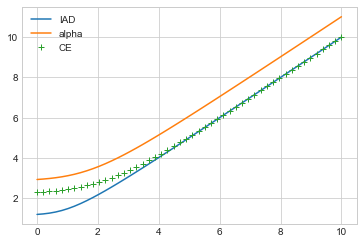

A_c increasing, expected decrease in loss


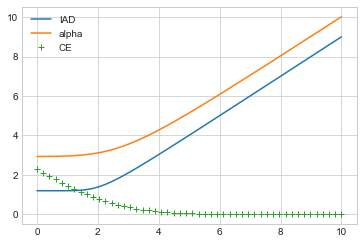

In [173]:
import scipy
loss_obj = tf.keras.losses.CategoricalCrossentropy()

def custom_loss(labels, logits,p=4):
    ic_mask = 1-labels
    # print("l1",loss1.numpy() )
    loss1 = (1-tf.reduce_sum(labels * logits))**p
    loss2 =tf.reduce_sum((logits*ic_mask)**p)
    
    # print(loss2)
    # loss = -tf.reduce_sum(_y_i * tf.math.log(a_i+tf.keras.backend.epsilon()),axis=-1)
    # print("l2",loss2.numpy())
    # print("l1+l2",(loss1 + loss2)**(1/p))
# incorrect_mask = tf.cast(abs(y_i -1),dtype=tf.float32)
    return (loss1 + loss2)**(1/p)

linspace = np.linspace(0,10)
# print("linspace",linspace)
loss = []
loss_alpha =[]
loss_alt= []
for i in linspace:
    logits = tf.Variable([[i,0,0,0,0,0,0,0,0,0]],dtype=tf.float32)
    labels = tf.Variable([[0,0,0,0,0,1,0,0,0,0]],dtype=tf.float32)
    softplus = tf.nn.softplus(logits)
    loss.append(tf.reduce_mean(custom_loss(labels,softplus)).numpy())    
    alpha = softplus + 1
    loss_alpha.append(tf.reduce_mean(custom_loss(labels,alpha)).numpy())
    
    ### CE
    softmax = tf.nn.softmax(logits)
    alpha = softmax + 1
    loss_alt.append(loss_obj(labels,softmax).numpy())
import matplotlib.pyplot as plt
print("A_j increasing, expected increase in loss")
plt.plot(linspace,loss,label="IAD")
plt.plot(linspace,loss_alpha,label="alpha")
plt.plot(linspace,loss_alt,'+',label="CE")
plt.legend()
plt.show()

loss = []
loss_alpha =[]
loss_alt= []
for i in linspace:
    logits = tf.Variable([[0,0,0,0,0,i,0,0,0,0]],dtype=tf.float32)
    labels = tf.Variable([[0,0,0,0,0,1,0,0,0,0]],dtype=tf.float32)
    softplus = tf.nn.softplus(logits)
    loss.append(tf.reduce_mean(custom_loss(labels,softplus)).numpy())    
    alpha = softplus + 1
    loss_alpha.append(tf.reduce_mean(custom_loss(labels,alpha)).numpy())
    
    ### CE
    softmax = tf.nn.softmax(logits)
    # print(softmax)
    loss_alt.append(tf.reduce_mean(loss_obj(labels,softmax)).numpy())
import matplotlib.pyplot as plt

print("A_c increasing, expected decrease in loss")
plt.plot(linspace,loss,label="IAD")
plt.plot(linspace,loss_alpha,label="alpha")
plt.plot(linspace,loss_alt,'+',label="CE")
plt.legend()
plt.show()


In [130]:
def EDL(labels, logits):
    # logits += 1e-10
    # evidence = tf.exp(logits)
    evidence = tf.nn.softplus(logits)
    # evidence = tf.exp(tf.clip_by_value(logits/10,-10,10))
    alpha = evidence + 1
    S = tf.reduce_sum(alpha,axis=1,keepdims=True) 
    E = alpha - 1
    m = alpha / S
    A = tf.reduce_sum((p-m)**2, axis=1, keepdims=True) 
    B = tf.reduce_sum(alpha*(S-alpha)/(S*S*(S+1)), axis=1, keepdims=True) 

    return A+B
mse = tf.keras.losses.MeanSquaredError(reduction=tf.keras.losses.Reduction.SUM)
   
logits = tf.Variable([[1.,10.,1]])
print("logits",logits)
# evidence = tf.exp(tf.clip_by_value(logits/10,-10,10))
# evidence = tf.nn.softplus(logits)
evidence = tf.nn.softplus(logits)
alpha = evidence + 1 
labels = tf.Variable([[0.,1.,0.]])


print("alpha", alpha)
print("p_ic", alpha*labels)
ic_mask = 1-labels
p = 4
A = (1 - (alpha * labels))**p
print("A",A)
print("b_", ic_mask * alpha)
B = tf.reduce_sum(ic_mask * (alpha**p),axis=1)
print("B",B)
total = (A+B)/p
print("total",total)

print("-----")
from scipy.special import gamma, factorial
alpha_sum = tf.reduce_sum(alpha)
A = (gamma(alpha_sum)/gamma(alpha_sum + p))/p
print("A",A)
B_1 = gamma((alpha *ic_mask)+p)/gamma((alpha *ic_mask))
print("B_1", B_1)

B_2 = ( gamma(alpha + p)/gamma(alpha))*ic_mask
print("B_2", B_2)
B = (B_1 + B_2)/p

_total =  A + B

print("-----")
print("-----")
def tfGamma(x):
    x = tf.clip_by_value(x,0,32)
    return tf.exp(tf.math.lgamma(x))
    # return gamma(tf.cast(x,tf.float64))

logits = tf.Variable([[1.,10.,1]])
print("logits",logits)
# evidence = tf.exp(tf.clip_by_value(logits/10,-10,10))
# evidence = tf.nn.softplus(logits)
evidence = tf.nn.softplus(logits)
alpha = evidence + 1 
labels = tf.Variable([[0.,1.,0.]])

ic_mask = 1-labels
print("ic_mask", ic_mask)
alpha = evidence+2
print("alpha",alpha)
from scipy.special import gamma, factorial
alpha_sum = tf.reduce_sum(alpha)
print('a_sum',tfGamma(alpha_sum))
A = (tfGamma(alpha_sum)/tfGamma(alpha_sum + p))/p
print("A",A)
B_1 = (tfGamma(tf.reduce_sum((alpha+p)*ic_mask,axis=1))/tfGamma(tf.reduce_sum(alpha*ic_mask,axis=1)))
# print("BB",(tfGamma((alpha)+p)/tfGamma((alpha))))
print("B_1", B_1)

print("BB", (tfGamma(alpha + p)))
print("BB2", tfGamma(alpha))
B_2 = tf.reduce_sum((tfGamma(alpha + p)/tfGamma(alpha))*ic_mask,axis=1)
print("B_2", B_2)
B = (B_1 + B_2)/p

_total_lgamma =  A * B

print("loss", tf.reduce_mean(total).numpy())
print("loss_gamma", tf.reduce_mean(_total).numpy())
print("loss_gamma_tf", (tf.reduce_mean((_total_lgamma))).numpy())
print("mse", mse(labels, logits).numpy())
print("EDL", EDL(labels, logits).numpy())

# l_infinity_norm = tf.reduce_max(tf.norm(A+B, ord = np.inf, axis = 1))
# l_infinity_norm



# import tensorflow_probability as tfp
# tfd = tfp.distributions
# dist = tfd.Beta(logits,labels)
# dist.sample(1)
# x = tf.Variable([-0.0687877536, 0,.2,-2.2, -1.0 + 1e10])
# tf.nn.softplus(x)

logits <tf.Variable 'Variable:0' shape=(1, 3) dtype=float32, numpy=array([[ 1., 10.,  1.]], dtype=float32)>
alpha tf.Tensor([[ 2.3132615 11.000046   2.3132615]], shape=(1, 3), dtype=float32)
p_ic tf.Tensor([[ 0.       11.000046  0.      ]], shape=(1, 3), dtype=float32)
A tf.Tensor([[1.0000000e+00 1.0000184e+04 1.0000000e+00]], shape=(1, 3), dtype=float32)
b_ tf.Tensor([[2.3132615 0.        2.3132615]], shape=(1, 3), dtype=float32)
B tf.Tensor([57.270226], shape=(1,), dtype=float32)
total tf.Tensor([[  14.567556 2514.3635     14.567556]], shape=(1, 3), dtype=float32)
-----
A 2.9307125259947497e-06
B_1 [[175.64972   0.      175.64972]]
B_2 tf.Tensor([[175.64972   0.      175.64972]], shape=(1, 3), dtype=float32)
-----
-----
logits <tf.Variable 'Variable:0' shape=(1, 3) dtype=float32, numpy=array([[ 1., 10.,  1.]], dtype=float32)>
ic_mask tf.Tensor([[1. 0. 1.]], shape=(1, 3), dtype=float32)
alpha tf.Tensor([[ 3.3132615 12.000046   3.3132615]], shape=(1, 3), dtype=float32)
a_sum tf.Tensor(

logits <tf.Variable 'Variable:0' shape=(1, 3) dtype=float32, numpy=array([[ 1., 20.,  1.]], dtype=float32)>
labels <tf.Variable 'Variable:0' shape=(1, 3) dtype=float32, numpy=array([[ 1., 10.,  1.]], dtype=float32)>
linspace [0.         0.02040816 0.04081633 0.06122449 0.08163265 0.10204082
 0.12244898 0.14285714 0.16326531 0.18367347 0.20408163 0.2244898
 0.24489796 0.26530612 0.28571429 0.30612245 0.32653061 0.34693878
 0.36734694 0.3877551  0.40816327 0.42857143 0.44897959 0.46938776
 0.48979592 0.51020408 0.53061224 0.55102041 0.57142857 0.59183673
 0.6122449  0.63265306 0.65306122 0.67346939 0.69387755 0.71428571
 0.73469388 0.75510204 0.7755102  0.79591837 0.81632653 0.83673469
 0.85714286 0.87755102 0.89795918 0.91836735 0.93877551 0.95918367
 0.97959184 1.        ]
A_j increasing, expected increase in loss


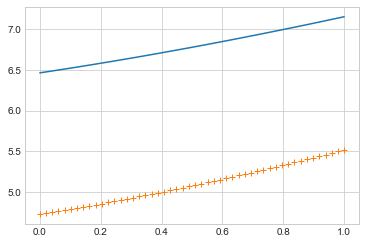

A_c increasing, expected decrease in loss


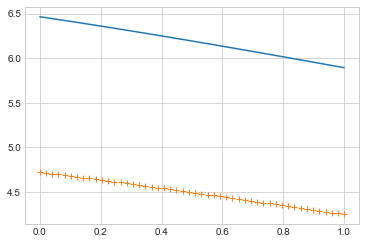

In [177]:

logits = tf.Variable([[1.,20.,1]])
print("logits",logits)
# evidence = tf.exp(tf.clip_by_value(logits/10,-10,10))
# evidence = tf.nn.softplus(logits)
evidence = tf.nn.softplus(logits)
alpha = evidence + 1 
labels = tf.Variable([[0.,1.,0.]])

# def tfGamma(x):
#     # x = tf.clip_by_value(x,0,32)
#     return (tf.math.lgamma(x))
#     # return tf.math.lgamma(x)
#     # return gamma(x)
    

logits = tf.Variable([[1.,10.,1]])
print("labels",logits)
# evidence = tf.exp(tf.clip_by_value(logits/10,-10,10))
# evidence = tf.nn.softplus(logits)
def loss_gamma(labels,logits):
    evidence = tf.nn.softplus(logits)
    alpha = evidence + 1 
    labels = tf.Variable([[0.,1.,0.]])
    def tfGamma(x):
    # x = tf.clip_by_value(x,0,32)
        return (gamma(x))
    ic_mask = tf.cast(1-labels,tf.float32)
    # print("ic_mask", ic_mask)
    alpha = evidence+1
    # print("alpha",alpha)
    from scipy.special import gamma, factorial
    alpha_sum = tf.reduce_sum(alpha)
    # print('a_sum',tfGamma(alpha_sum))
    A = (tfGamma(alpha_sum)/tfGamma(alpha_sum + p))**(1/p)
    # A = tf.exp(tf.math.lgamma(alpha_sum) - tf.math.lgamma(alpha_sum+p))/p
    # print("A",A)
    B_1 = (tfGamma(tf.reduce_sum((alpha+p)*ic_mask,axis=1))/tfGamma(tf.reduce_sum(alpha*ic_mask,axis=1)))
    # print("BB",(tfGamma((alpha)+p)/tfGamma((alpha))))
    # print("B_1", B_1)

    # print("BB", (tfGamma(alpha + p)))
    # print("BB2", tfGamma(alpha))
    B_2 = tf.reduce_sum((tfGamma(alpha + p)/tfGamma(alpha))*ic_mask,axis=1)
    # print("B_2", B_2)
    B = (B_1 + B_2)**(1/p)

    _total_lgamma =  A * B
    return _total_lgamma



def loss_gamma_alternate(labels,logits,p=2):
    evidence = tf.nn.softplus(logits)
    alpha = evidence + 1 
    def tfGamma(x):
    # x = tf.clip_by_value(x,0,32)
        return (tf.math.lgamma(x))
    # return tf.math.lgamma(x)
    # return gamma(x)
    
    ic_mask = tf.cast(1-labels,tf.float32)
    # print("ic_mask", ic_mask)
    alpha = evidence+1
    # print("alpha",alpha)
    from scipy.special import gamma, factorial
    alpha_sum = tf.reduce_sum(alpha)
    # print('a_sum',tfGamma(alpha_sum))
    # A = (tfGamma(alpha_sum)/tfGamma(alpha_sum + p))/p
    A = tf.exp(tf.math.lgamma(alpha_sum) - tf.math.lgamma(alpha_sum+p))**(1/p)
    # print("A",A)
    # B_1 = (tfGamma(tf.reduce_sum((alpha+p)*ic_mask,axis=1))/tfGamma(tf.reduce_sum(alpha*ic_mask,axis=1)))
    B_1 = tf.exp((tf.math.lgamma(tf.reduce_sum((alpha+p)*ic_mask,axis=1))/p) - (tf.math.lgamma(tf.reduce_sum(alpha*ic_mask,axis=1))/p))
    # print(np.exp(sc.gammaln(x+p)/p - sc.gammaln(x)/p))
    # print("BB",(tfGamma((alpha)+p)/tfGamma((alpha))))
    # print("B_1", B_1)

    # print("BB", (tfGamma(alpha + p)))
    # print("BB2", tfGamma(alpha))
    # B_2 = tf.reduce_sum((tfGamma(alpha + p)/tfGamma(alpha))*ic_mask,axis=1)
    B_2 = tf.reduce_sum(tf.exp((tf.math.lgamma(alpha + p)/p) - tf.math.lgamma((alpha/p)))*ic_mask,axis=1)
    # print("B_2", B_2)
    B = (B_1 + B_2)#**(1/p)

    _total_lgamma =  A * B
    return _total_lgamma



# logits = tf.Variable([10,1,0],dtype=tf.float64)
# labels = tf.Variable([0,1,0],dtype=tf.float64)
# print("loss_gamma_tf_alt", (tf.reduce_mean((loss_gamma_alternate(labels,logits)))).numpy())
# # print("mse", mse(labels, logits).numpy())

# print("loss_gamma_tf", (tf.reduce_mean((loss_gamma(labels,logits)))).numpy())

# print("EDL", EDL(labels, logits).numpy())

linspace = np.linspace(0,1)
print("linspace",linspace)
loss = []
loss_alt= []
for i in linspace:
    logits = tf.Variable([[i,0,0]],dtype=tf.float32)
    labels = tf.Variable([[0,1,0]],dtype=tf.float32)
    loss.append(tf.reduce_mean(loss_gamma(labels,logits)).numpy())
    loss_alt.append(tf.reduce_mean(loss_gamma_alternate(labels,logits)).numpy())
import matplotlib.pyplot as plt
print("A_j increasing, expected increase in loss")
plt.plot(linspace,loss,)
plt.plot(linspace,loss_alt,'+')
plt.show()

loss = []
loss_alt= []
for i in linspace:
    logits = tf.Variable([[0,i,0]],dtype=tf.float32)
    labels = tf.Variable([[0,1,0]],dtype=tf.float32)
    loss.append(tf.reduce_mean(loss_gamma(labels,logits)).numpy())
    loss_alt.append(tf.reduce_mean(loss_gamma_alternate(labels,logits)).numpy())
import matplotlib.pyplot as plt

print("A_c increasing, expected decrease in loss")
plt.plot(linspace,loss,)
plt.plot(linspace,loss_alt,'+')
plt.show()

In [522]:

# print((tf.math.lgamma(50.0001234)))
x =tf.Variable([[0,1,0.]],dtype=tf.float64)
y = tf.Variable([[0.,1.,0.]],dtype=tf.float64)

print(gamma(tf.reduce_sum(x))/gamma(tf.reduce_sum(x)+4)**(1/4))

x =tf.Variable([[0.,1,0.]],dtype=tf.float32)
y = tf.Variable([[0.,1.,0.]],dtype=tf.float32)
# print(tf.exp(tf.math.lgamma(tf.reduce_sum(x)) - tf.math.lgamma(tf.reduce_sum(x)+2))**(1/4))
print(tf.exp(tf.math.lgamma(tf.reduce_sum(x)) - tf.math.lgamma(tf.reduce_sum(x)+4))**(1/4))
print(tf.exp(tf.math.lgamma(tf.reduce_sum(x))/4 - tf.math.lgamma(tf.reduce_sum(x)+4)/4))
print("---")


p = 4
B1=(tf.exp(tf.math.lgamma(tf.reduce_sum(x)) - tf.math.lgamma(tf.reduce_sum(x)+p)))
print("B1",B1)
_B1=(tf.exp((tf.math.lgamma(tf.reduce_sum(x))) - (tf.math.lgamma(tf.reduce_sum(x)+p))))

# print("_B1",_B1)

print("----")
x = tf.nn.softplus(x)
x = x+1

print(tf.reduce_sum(gamma(x+p)/gamma(x)))
# print((tf.reduce_sum(gamma(x+p)))/tf.reduce_sum(gamma(x)))
B2 = tf.reduce_sum( tf.exp(tf.math.lgamma(x+p) - tf.math.lgamma(x)))
print("B2",B2)
_B2 = tf.reduce_sum( tf.exp((tf.math.lgamma(x+p)) - (tf.math.lgamma(x)))**(1/p))
__B2 = tf.reduce_sum( tf.exp((tf.math.lgamma(x+p)) - (tf.math.lgamma(x))))

print("result", (B1+B2)**(1/p))

print("result_", (_B1+_B2))
# print(tf.exp(tf.math.lgamma(tf.reduce_sum(x))/4 - tf.math.lgamma(tf.reduce_sum(x)+2)/4))



0.45180100180492244
tf.Tensor(0.45180094, shape=(), dtype=float32)
tf.Tensor(0.45180094, shape=(), dtype=float32)
---
B1 tf.Tensor(0.041666646, shape=(), dtype=float32)
----
tf.Tensor(333.71832, shape=(), dtype=float32)
B2 tf.Tensor(333.71857, shape=(), dtype=float32)
result tf.Tensor(4.274237, shape=(), dtype=float32)
result_ tf.Tensor(10.0555725, shape=(), dtype=float32)


In [11]:
y = tf.Variable([[0.,1.,0.]],dtype=tf.float64)
tf.cast(y,tf.bool)

<tf.Tensor: shape=(1, 3), dtype=bool, numpy=array([[False,  True, False]])>

In [660]:
x =tf.Variable([[14.,14,14.]],dtype=tf.float64)
y = tf.Variable([[0.,1.,0.]],dtype=tf.float64)
x = x + 1
p = 2


y1 = tf.exp(tf.math.lgamma(tf.reduce_sum(x+p,axis=1)))
y2 = tf.exp(tf.math.lgamma(tf.reduce_sum(x,axis=1)))
print("y1",y1,"y2",y2)
z1 = (tf.exp(tf.math.lgamma(x+p)))
z2 = (tf.exp(tf.math.lgamma(x)))
print("z1",z1,"z2",z2)
z = tf.reduce_sum(z1/z2,axis=1)
result3 = ((y1/y2) + tf.reduce_sum(z1 / z2,axis=1)) ** (1/p)
print(result3)

print("----")
y1 = tf.exp(tf.math.lgamma(tf.reduce_sum(x+p,axis=1)))
y2 = tf.exp(tf.math.lgamma(tf.reduce_sum(x,axis=1)))
print("y1",y1,"y2",y2)
z1 = (tf.exp(tf.math.lgamma(x+p)))
z2 = (tf.exp(tf.math.lgamma(x)))
print("z1",z1,"z2",z2)
result4 = (((z) * y2 + y1)** (1/p) /y2** (1/p) ) 
print(result4)

y1 tf.Tensor([3.04140932e+64], shape=(1,), dtype=float64) y2 tf.Tensor([2.65827157e+54], shape=(1,), dtype=float64)
z1 tf.Tensor([[2.09227899e+13 2.09227899e+13 2.09227899e+13]], shape=(1, 3), dtype=float64) z2 tf.Tensor([[8.71782912e+10 8.71782912e+10 8.71782912e+10]], shape=(1, 3), dtype=float64)
tf.Tensor([106964.03470326], shape=(1,), dtype=float64)
----
y1 tf.Tensor([3.04140932e+64], shape=(1,), dtype=float64) y2 tf.Tensor([2.65827157e+54], shape=(1,), dtype=float64)
z1 tf.Tensor([[2.09227899e+13 2.09227899e+13 2.09227899e+13]], shape=(1, 3), dtype=float64) z2 tf.Tensor([[8.71782912e+10 8.71782912e+10 8.71782912e+10]], shape=(1, 3), dtype=float64)
tf.Tensor([106964.03470326], shape=(1,), dtype=float64)


In [23]:
x =tf.Variable([[14.,14,14.]],dtype=tf.float64)
y = tf.Variable([[0.,1.,0.]],dtype=tf.float64)

mask = 1-labels
ic_mask = tf.cast(mask, tf.bool)
ic_mask
tf.boolean_mask(x,ic_mask)

<tf.Tensor: shape=(2,), dtype=float64, numpy=array([14., 14.])>

In [656]:
x = tf.Variable(10.)
y = tf.Variable(3.)
print(gamma(x) / gamma(y))
print(tf.exp(np.log(gamma(x) / gamma(y))))

print(gamma(x/y))



181440.0
tf.Tensor(181440.08, shape=(), dtype=float32)
2.7781582


In [533]:
p = (1/4)
x = (10/5)**p
print(x)


z = ((10**p)/(5**p))
print(z)
print("the power of a value is the same as the power of each internal value")

1.189207115002721
1.189207115002721
the power of a value is the same as the power of each internal value


In [553]:
p = (1/4)
x = (10/2)**p
print((10**p)/(2**p))
z = 10 
print(x)

1.4953487812212205
1.4953487812212205


In [556]:
p = (1/4)
z = 5
x = ((10/3) + z)**p
print(x)
y = ((10 + 3*z)/3)**p
print(y)

1.6990442448471226
1.6990442448471226


In [612]:
p = (1/4)
a = tf.Variable(10.)
b = tf.Variable(3.)
x = tf.Variable(5.)
y = tf.Variable(2.)


# x =tf.Variable([[0,1,0.]],dtype=tf.float64)
# x + 1
# y = tf.Variable([[0.,1.,0.]],dtype=tf.float64)

z = 5
result = ((gamma(a+4)/gamma(b)) + (gamma(x+4)/gamma(y)))**p
# result = (tf.exp(tf.math.lgamma(a)-tf.math.lgamma(b)) +tf.exp(tf.math.lgamma(x)-tf.math.lgamma(y)))**p
print(result)
# result2 = ((gamma(a)/gamma(b)) +(gamma(x)/gamma(y)))
result2 = (tf.exp(tf.math.lgamma(a+4)-tf.math.lgamma(b)) + tf.exp(tf.math.lgamma(x+4)-tf.math.lgamma(y)))**p
print(result2)
y1 = tf.exp(tf.math.lgamma(a+4))
y2 = tf.exp(tf.math.lgamma(b))

z1 = tf.exp(tf.math.lgamma(x+4))
z2 = tf.exp(tf.math.lgamma(y))
result3 = ((y1/y2) + z1 / z2) ** p
print(result3)


result4 = (((z1 / z2) * y2 + y1)** p /y2** p ) 
print(result4)


236.2185452948921
tf.Tensor(236.2185, shape=(), dtype=float32)
tf.Tensor(236.21852, shape=(), dtype=float32)
tf.Tensor(236.2185, shape=(), dtype=float32)


In [598]:
p = 1/4

x = ((10/2)+ (5/2))**p
print(x)
y1 = ((10**p) / (2**p))
y2 = ((5**p) / (2**p))
# y = ((10**(1/4)/(2**(1/4))) + ((5**(1/4)/(2**(1/4)))))
print(y1 + y2)

1.6548754598234365
2.752782210904156


In [314]:
# print(gamma(y))
x = tf.Variable([[  50,50,50,50,50,50,50,50,50,50]],dtype=tf.float32)
x = x + 2
# print(x.dtype)
x = tf.clip_by_value(x,0,32)
print(x)
print(gamma(x))
print(tf.reduce_sum(gamma(x)))
print(tf.reduce_sum(gamma(sum(x))))

tf.Tensor([[32. 32. 32. 32. 32. 32. 32. 32. 32. 32.]], shape=(1, 10), dtype=float32)
[[8.2228384e+33 8.2228384e+33 8.2228384e+33 8.2228384e+33 8.2228384e+33
  8.2228384e+33 8.2228384e+33 8.2228384e+33 8.2228384e+33 8.2228384e+33]]
tf.Tensor(8.2228384e+34, shape=(), dtype=float32)
tf.Tensor(8.2228384e+34, shape=(), dtype=float32)


In [ ]:
logits = tf.Variable([[-1.,-2.,-10.1]])

evidence = tf.nn.softplus(logits)

labels = tf.Variable([[0,1,0]])
alpha = evidence + 1 
incorrect_mask = tf.cast(abs(labels -1),dtype=tf.float32)
print("mask", incorrect_mask)
_A = tf.pow(alpha-1,2)

B_1 = tf.math.polygamma(1.,alpha) 
B_2 = tf.math.polygamma(1., 1 + tf.reduce_sum(incorrect_mask* alpha,axis=1,keepdims=True))
_B = B_1 - B_2

# tf.print(_A,_B,incorrect_mask)
info_Reg = 1 * (.5 * (_A *_B) )
info_Reg *= incorrect_mask
print(info_Reg)
print(tf.reduce_mean(info_Reg,axis=1))

In [427]:
x = 100
y = 5
print(gamma(x)/gamma(y))

print(np.exp(np.log(gamma(x)) - np.log(gamma(y))))

3.8885923101643403e+154
3.8885923101643225e+154


In [74]:
x = tf.Variable([[1.,1.,1.,1.,1.,1.,1.,1.,1.,1.]],tf.float64)
p = 2
print(gamma(x+p))
print(tf.reduce_sum(gamma(x+p)))

print(gamma(x+p))
print((gamma(tf.reduce_sum(x+p))))




[[2. 2. 2. 2. 2. 2. 2. 2. 2. 2.]]
tf.Tensor(20.0, shape=(), dtype=float32)
[[2. 2. 2. 2. 2. 2. 2. 2. 2. 2.]]
8.841762e+30


362880.0

In [94]:
p = 4 
x = 3+p
y = 3

print((gamma(x)/gamma(y))**(1/p))
print(np.exp(np.log(gamma(x))- np.log(gamma(y)))**(1/p))


4.355877174692862
4.355877174692863


In [121]:
x = tf.Variable([[1.,1.,1.,1.,1.,1.,1.,1.,1.,1.]])
y = tf.Variable([[0,0,1,0,0]])
p = 4
print(gamma(x+p)/gamma(x))
print(gamma(tf.reduce_sum(x+p))/gamma(tf.reduce_sum(x)))

b1 = (tf.exp(tf.math.lgamma(tf.reduce_sum(x+p))-tf.math.lgamma(tf.reduce_sum(x))))
print(b1)
b2 = (tf.reduce_sum(tf.exp(tf.math.lgamma((x+p)))- tf.exp(tf.math.lgamma(x))))
print(b2)
print((b1+ b2)**(1/p))

print("---")

b1 = (tf.exp(tf.math.lgamma(tf.reduce_sum(x)+p)-tf.math.lgamma(tf.reduce_sum(x))))
print(b1)
b2 = (tf.reduce_sum(tf.exp(tf.math.lgamma((x+p)))- tf.exp(tf.math.lgamma(x))))
print(b2)
print((b1+ b2)**(1/p))


[[24. 24. 24. 24. 24. 24. 24. 24. 24. 24.]]
inf
tf.Tensor(inf, shape=(), dtype=float32)
tf.Tensor(230.00024, shape=(), dtype=float32)
tf.Tensor(inf, shape=(), dtype=float32)
---
tf.Tensor(17159.955, shape=(), dtype=float32)
tf.Tensor(230.00024, shape=(), dtype=float32)
tf.Tensor(11.48351, shape=(), dtype=float32)


In [11]:
np.exp(0)

1.0

In [176]:
from scipy.special import logsumexp


def brevisCrossEnergy(lambda_callback: lambda_update, input_in=True):
    ''' Proposed Loss function for BrevisNet branch classifiers
        consists of the Cross Entropy loss  + reverse dirichlet KL + regularizing dirichlet entropy mean
    '''
    input_ID = input_in
    def brevisCrossEnergy(p, logits):
        logits += 1e-10
        # evidence = tf.exp(logits)
        evidence = tf.nn.softplus(logits)
        # evidence = tf.exp(tf.clip_by_value(logits/10,-10,10))
        alpha = evidence + 1
        S = tf.reduce_sum(alpha,axis=1,keepdims=True) 
        E = alpha - 1
        m = alpha / S
        A = tf.reduce_sum((p-m)**2, axis=1, keepdims=True) 
        B = tf.reduce_sum(alpha*(S-alpha)/(S*S*(S+1)), axis=1, keepdims=True) 
        
        annealing_coef =  lambda_callback.lambda_t
        
        softmax = tf.nn.softmax(logits)
        # CE = tf.keras.losses.categorical_crossentropy(p,softmax)
        # tf.print(" :",Ec)
       
        
        # tf.print(Ec)
        if tf.math.is_nan(tf.reduce_sum(logits)):
            tf.print("logits",logits, summarize=-1)
        # alp = E*(1-p) + 1 
        C =annealing_coef * DirichletKLLoss(p,logits, True)
        
        # tf.print(C)
        # C = annealing_coef * KL(alp,10)
        # Ec = tf.math.maximum(annealing_coef * ((tf.reduce_logsumexp(logits))),-25)
        # tf.print(":",annealing_coef * Ec)
        D = 0.0001 * -tf.reduce_mean(tfp.distributions.Dirichlet(alpha).entropy()) ###entropy of the dirichlet distribution as a smoothing regularizer. 
        return (A+B) + C + D
    
    return  brevisCrossEnergy

# Ec_out = -torch.logsumexp(x[len(in_set[0]):], dim=1)
# Ec_in = -torch.logsumexp(x[:len(in_set[0])], dim=1)
# loss += 0.1*(torch.pow(F.relu(Ec_in-args.m_in), 2).mean() + torch.pow(F.relu(args.m_out-Ec_out), 2).mean())


def IAD(lambda_callback: lambda_update):

    def IAD(labels, logits):
        # evidence = tf.exp(logits)
        p = 4
#         evidence = tf.nn.softplus(logits)
#         alpha = evidence + 1
#         from scipy.special import gamma, factorial
#         alpha_sum = tf.reduce_sum(alpha)
#         tf.print("Alpha_sum", alpha_sum)
#         tf.print("lg",tf.math.lgamma(alpha_sum))
#         ic_mask = 1-labels
#         A = (tfGamma(alpha_sum)/tfGamma(alpha_sum + p))/p
#         tf.print("A_sum",tfGamma(alpha_sum))
#         tf.print("A_sum+p",tfGamma(alpha_sum+p))
#         tf.print("A",A)
#         B_1 = tfGamma((alpha *ic_mask)+p)/tfGamma((alpha *ic_mask))
#         # tf.print("B_1", B_1)

#         B_2 = ( tfGamma(alpha + p)/tfGamma(alpha))*ic_mask
#         # tf.print("B_2", B_2)
#         B = (B_1 + B_2)/p

#         loss =  A + B
#         tf.print(loss)

        evidence = tf.nn.softmax(logits)
        evidence = tf.cast(evidence,tf.float32)
        
        alpha = evidence + 1 
        ic_mask = tf.cast(1-labels,tf.float32)
        # ic_mask_bool = tf.cast(ic_mask, tf.bool)
        # tf.print("mask", ic_mask_bool)
        
        # tf.print("ic_mask", ic_mask)
        alpha = evidence+1
        # tf.print("alpha",alpha)
        alpha_sum = tf.reduce_sum(alpha)
        # tf.print('a_sum',tfGamma(alpha_sum))
        # A = (tfGamma(alpha_sum)/tfGamma(alpha_sum + p))/p
        A = tf.exp(tf.math.lgamma(alpha_sum) - (tf.math.lgamma(alpha_sum+p)))**(1/p)
        # B_1 = (tfGamma(tf.reduce_sum((alpha+p)*ic_mask,axis=1))/tfGamma(tf.reduce_sum(alpha*ic_mask,axis=1)))
        # _b1 = tf.boolean_mask(alpha, ic_mask_bool,axis=1)
        # _b2 = tf.boolean_mask(alpha , ic_mask_bool,axis=1)
        
        # tf.print("_b1",_b1,_b1.shape,summarize=-1)
        # tf.print("_b2",_b2,_b2.shape,summarize=-1)
        # tf.print("_b1 - _b2",_b1 - _b2, summarize=-1)
        B_1 = tf.exp(tf.math.lgamma(tf.reduce_sum((alpha + p) * ic_mask ,axis=1))) / tf.exp(tf.math.lgamma(tf.reduce_sum(alpha * ic_mask,axis=1)))
        
        # B_1 = tf.exp(tf.math.lgamma(tf.reduce_sum((alpha + p) * ic_mask_bool,axis=1)) - tf.math.lgamma(tf.reduce_sum(alpha,ic_mask_bool,axis=1)))
        B_2 = tf.reduce_sum(tf.exp(tf.math.lgamma(alpha  + p)* ic_mask)/tf.exp(tf.math.lgamma(alpha))* ic_mask,axis=1)
        # tf.print("alpha",tf.boolean_mask(alpha,ic_mask_bool))
        # tf.print("BB_1",(tf.exp(tf.math.lgamma(tf.boolean_mask(alpha + p,ic_mask_bool)))),summarize=-1)
        # tf.print("BB_2",(tf.exp(tf.math.lgamma(tf.boolean_mask(alpha,ic_mask_bool)))),summarize=-1)
        # B_2 = tf.reduce_sum(tf.exp(tf.math.lgamma((alpha + p)*ic_mask)) - tf.exp(tf.math.lgamma(alpha*ic_mask)) ,axis=1)
        B = (B_1 + B_2)**(1/p)
        loss  =  A * B
        
        
        # loss = tf.cast(loss, tf.float32)
#         # tf.print("casted loss", loss)
#         if tf.math.is_nan(tf.reduce_sum(loss)):
#             tf.print("loss",loss, summarize=-1)    
#             # tf.print("alpha",alpha_ic,summarize=-1)
#             tf.print("A",A)

#             tf.print("B_1", B_1)

#             tf.print("B_2", B_2)
            
        # if tf.math.is_nan(tf.reduce_sum(loss)):
            # tf.print("loss",loss, summarize=-1)    
            # tf.print("alpha",alpha_ic,summarize=-1)
        # tf.print("A",A)
        # tf.print("B_1_1", (tf.reduce_sum(alpha * ic_mask ,axis=1)+p) ,summarize=-1)
        # tf.print("B_1_2", tf.exp(tf.math.lgamma(tf.reduce_sum(alpha * ic_mask ,axis=1)+p)),summarize=-1)
        # tf.print("B_1_2_1", (tf.reduce_sum(alpha * ic_mask ,axis=1)+p), summarize=-1)
        # tf.print("B_1_2_2", tf.exp(tf.math.lgamma(tf.reduce_sum(alpha * ic_mask,axis=1))), summarize=-1)
        
        # tf.print("B_1", B_1, summarize=-1)
        
        # tf.print("loss",loss,summarize=-1)

        # alp = E*(1-p) + 1 
        # C =annealing_coef * DirichletKLLoss(p,logits, True)

        annealing_coef =  lambda_callback.lambda_t
#         incorrect_mask = tf.cast(abs(labels -1),dtype=tf.float32)
#         _A = tf.pow(alpha-1,2)
        
#         B_1 = tf.math.polygamma(1.,alpha) 
#         B_2 = tf.math.polygamma(1., 1 + tf.reduce_sum(incorrect_mask* alpha-1,axis=1,keepdims=True))
#         _B = B_1 - B_2
#         info_Reg = incorrect_mask * (.5 * (_A *_B) )
        # info_Reg *= annealing_coef
        
        
        # D = 0.0001 * -tf.reduce_mean(tfp.distributions.Dirichlet(alpha).entropy()) ###entropy of the dirichlet distribution as a smoothing regularizer. 
        # tf.print(tf.reduce_mean((A+B) + info_Reg,axis=1))
        return (loss) #+ info_Reg
    
    return  IAD

def custom_loss(lambda_callback: lambda_update):
    def custom_loss(labels, logits,p=4):
        evidence = tf.nn.softplus(logits)
        evidence = tf.cast(evidence,tf.float32)

        alpha = evidence + 1 
        ic_mask = tf.cast(1-labels,tf.float32)
        # ic_mask = 1-labels
        
        loss1 = (1-tf.reduce_sum(labels * logits))**p
        loss2 =tf.reduce_sum((logits*ic_mask)**p)
    
        # tf.print("loss1",loss1)
        # tf.print("loss2",loss2)
        
        # softmax = tf.nn.softmax(logits)
        # CE = tf.keras.losses.categorical_crossentropy(labels,softmax)
        
        # loss = -tf.reduce_sum(_y_i * tf.math.log(a_i+tf.keras.backend.epsilon()),axis=-1)
        # print("l2",loss2.numpy())
        _loss = ((loss1 + loss2)**(1/p) ) 
        # print("l1+l2",(loss1 + loss2)**(1/p))
    # incorrect_mask = tf.cast(abs(y_i -1),dtype=tf.float32)
        return _loss #+ CE
    return custom_loss

def CE(lambda_callback: lambda_update):
    def CE(labels, logits):
        # evidence = tf.exp(logits)
        evidence = tf.nn.softplus(logits)
        softmax = tf.nn.softmax(logits)
        loss = tf.keras.losses.categorical_crossentropy(labels,softmax)
        tf.print(loss)
        return loss
    
    return  CE


base_model = tf.keras.applications.resnet50.ResNet50(input_shape=(32, 32, 3),
     weights='imagenet',include_top=False)
x = base_model.output
x = tf.keras.layers.GlobalAveragePooling2D()(x)
x = tf.keras.layers.Flatten()(x)
x = tf.keras.layers.Dense(1024, activation="relu")(x)
x = tf.keras.layers.Dense(512, activation="relu")(x)
x = tf.keras.layers.Dense(10, name="classification")(x)

model = tf.keras.models.Model(inputs=base_model.input, outputs=x)
# model = tf.keras.models.load_model('./models/resnet50_finetuned_brev.hdf5')
lambda_callback = lambda_update(10,1,max_t = 1)
# loss = kl_loss(lambda_callback)
loss_fn = custom_loss(lambda_callback)
model.compile(optimizer=tf.optimizers.SGD(learning_rate=0.01, momentum=0.9),
                loss=loss_fn,
                metrics = ['accuracy'])

model.fit(train_ds, validation_data=validation_ds,epochs = 10,callbacks=[lambda_callback])



annealing coef updated to: 0.1
Epoch 1/10
  73/1407 [>.............................] - ETA: 1:04 - loss: nan - accuracy: 0.1066

KeyboardInterrupt: 

In [88]:
tf.executing_eagerly()

True

In [41]:

model = tf.keras.models.load_model('./models/resnet50_finetuned_brev.hdf5')

lambda_callback = lambda_update(10,0,max_t = 1)
loss_fn = brevisCrossEnergy(lambda_callback, False)
model.compile(optimizer="adam",#tf.optimizers.SGD(learning_rate=0.01, momentum=0.9),
                loss=loss_fn,
                metrics = ['accuracy'])
model.evaluate(test_ds)

313/313 [==============================] - 6s 14ms/step - loss: 0.6524 - accuracy: 0.7935


[0.6524369120597839, 0.7935000061988831]

In [65]:
output_ID= getPredictions_Energy(model, test_ds,stopping_point=None)
for i in output_ID:
    i['outlier']=0
print("----")
output_OOD = getPredictions_Energy(model, test_ds100,stopping_point=None)
for i in output_OOD:
    i['correct']=0
    i['outlier']=1
    


----iction: 312 of 313


In [11]:
output_OOD_SVHN = getPredictions_Energy(model, test_ds_svhn,stopping_point=312)
for i in output_OOD_SVHN:
    i['correct']=0
    i['outlier']=1


In [104]:
metrics = ['calibration']
for metric in metrics:
    for output in output_ID:
        linspace = np.linspace(output[metric].min(), output[metric].max(),100)
        _dist = float("inf")
        _count = float("inf")
        for i in linspace:
            
            if metric in ['calibration']:
                count =len(output.loc[output[metric]>=i])
                # print(i,count)
            else:
                count =len(output.loc[output[metric]<=i])
            if count >= .94 * len(output):
                if abs(count -(.95 * len(output))) < _dist:
                    _dist = abs(count -(.95 * len(output)))
                    threshold = i
                    _count = count
        print(metric ,"at best threshold:", threshold, "count",_count, "distance", _dist)
        # print(output.head())

calibration at best threshold: 0.5120138483818131 count 9522 distance 22.0


In [20]:
logits = tf.Variable([[1.,1.,1.,1.,0.1]])
p = tf.Variable([[1.,0.,0.,0.,0.]])
def foo(p,logits):
    # evidence = tf.exp(logits)+1e-10
    evidence = tf.nn.softplus(logits)
    # evidence = tf.exp(tf.clip_by_value(logits/10,-10,10))
    print(evidence)
    
    alpha = evidence + 1
    S = tf.reduce_sum(alpha,axis=1,keepdims=True) 
    E = alpha - 1
    m = alpha / S
    A = tf.reduce_sum((p-m)**2, axis=1, keepdims=True) 
    B = tf.reduce_sum(alpha*(S-alpha)/(S*S*(S+1)), axis=1, keepdims=True) 
    l_infinity_norm = tf.reduce_max(tf.norm(logits, ord = 1, axis = 1))

    print(l_infinity_norm)
    # print(A,B)

foo(tf.Variable([[1.,0.,0.,0.,0.]]),  tf.Variable([[10.,0.,0.,0.,0.]]))
print("-----")
foo(tf.Variable([[1.,0.,0.,0.,0.]]),  tf.Variable([[1.,1.,1.,1.,0.1]]))
print("-----")
foo(tf.Variable([[1.,0.,0.,0.,0.]]),  tf.Variable([[5.,90,-10,0,0]]))

tf.Tensor([[10.000046   0.6931472  0.6931472  0.6931472  0.6931472]], shape=(1, 5), dtype=float32)
tf.Tensor(10.0, shape=(), dtype=float32)
-----
tf.Tensor([[1.3132616 1.3132616 1.3132616 1.3132616 0.7443967]], shape=(1, 5), dtype=float32)
tf.Tensor(4.1, shape=(), dtype=float32)
-----
tf.Tensor([[5.0067153e+00 9.0000000e+01 4.5398901e-05 6.9314718e-01 6.9314718e-01]], shape=(1, 5), dtype=float32)
tf.Tensor(105.0, shape=(), dtype=float32)


In [113]:
metrics = ['calibration']
for metric in metrics:
    for output in output_ID:
        Correct = output.loc[output['correct']==True]
        Incorrect = output.loc[output['correct']==False]
        
        linspace = np.linspace(output[metric].min(), output[metric].max(),100)
        _dist = float("inf")
        _count = float("inf")
        for i in linspace:
            
            if metric in ['calibration']:
                count =len(Correct.loc[Correct[metric]>=i])
                # print(i,count)
            else:
                count =len(Correct.loc[Correct[metric]<=i])
            if count >= .94 * len(Correct):
                if abs(count -(.95 * len(Correct))) < _dist:
                    _dist = abs(count -(.95 * len(Correct)))
                    threshold = i
                    _count = count
        print(metric ,"at best threshold:", threshold, "count",_count, "distance", _dist)
        # print(output.head())

calibration at best threshold: 0.608011124109981 count 7488 distance 4.649999999999636


### IAD regularizer with EDL loss

metric:  entropy_of_expected threshold:  gmean
entropy_of_expected  lr_auc 0.8234313214591444 Best Threshold=-0.015051216498794257, G-Mean=0.7517738392225698, TPR=0.7014218009478673, FPR=0.19425956738768718


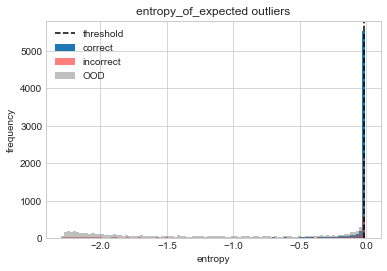

['exit_1']
  Exit_Name  ID_Inputs  OOD_Inputs  Test_Accuracy  Threshold  Accepted ID  Accepted OOD  Accepted_Correct  Accepted_ID_Ratio  Acceptance_Accuracy
0    exit_1      10000       10000         0.7596  -0.015051         5795          1928              5328           0.750356             0.689887
metric:  energy threshold:  gmean
energy  lr_auc 0.17556127382044495 Best Threshold=-88.52739715576172, G-Mean=0.7536210044638278, TPR=0.8015806988352745, FPR=0.2914691943127962


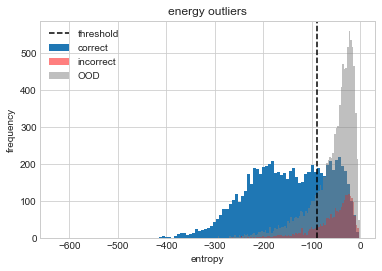

['exit_1']
  Exit_Name  ID_Inputs  OOD_Inputs  Test_Accuracy  Threshold  Accepted ID  Accepted OOD  Accepted_Correct  Accepted_ID_Ratio  Acceptance_Accuracy
0    exit_1      10000       10000         0.7596 -88.527397         5860          1921              5382           0.753117             0.691685


In [67]:
#### 
evaluate.buildCompareDistribPlot(output_ID, output_OOD, ["entropy_of_expected"], "gmean",main_exit_included=False,plot=True)
evaluate.buildCompareDistribPlot(output_ID, output_OOD, ["energy"], "gmean",main_exit_included=False,plot=True)


### EDL with no KL training

edl no KL
-----
metric:  energy threshold:  gmean
energy  lr_auc 0.17160544700206598 Best Threshold=-93.0582504272461, G-Mean=0.7644688725713249, TPR=0.767965367965368, FPR=0.2390117035110533


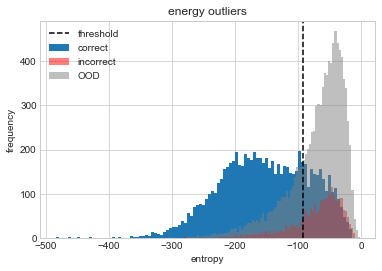

['exit_1']
  Exit_Name  ID_Inputs  OOD_Inputs  Test_Accuracy  Threshold  Accepted ID  Accepted OOD  Accepted_Correct  Accepted_ID_Ratio  Acceptance_Accuracy
0    exit_1      10000       10000          0.769  -93.05825         6389          2421              5852           0.725199             0.664245
metric:  entropy threshold:  gmean
entropy  lr_auc 0.2183294771981378 Best Threshold=2.960053012235189e-36, G-Mean=0.7617270898142575, TPR=0.7597402597402597, FPR=0.23628088426527957


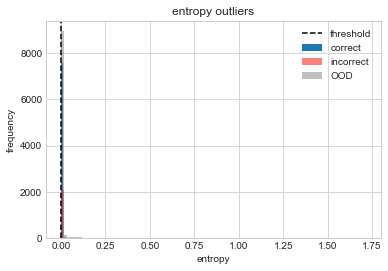

['exit_1']
  Exit_Name  ID_Inputs  OOD_Inputs  Test_Accuracy     Threshold  Accepted ID  Accepted OOD  Accepted_Correct  Accepted_ID_Ratio  Acceptance_Accuracy
0    exit_1      10000       10000          0.769  2.960053e-36         6429          2579              5873           0.713699             0.651976
metric:  energy threshold:  gmean
energy  lr_auc 0.17160544700206598 Best Threshold=-93.0582504272461, G-Mean=0.7644688725713249, TPR=0.767965367965368, FPR=0.2390117035110533


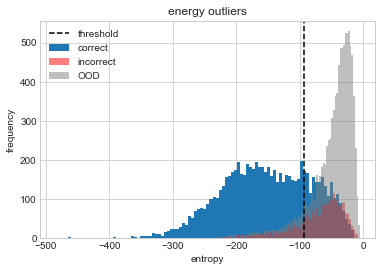

['exit_1']
  Exit_Name  ID_Inputs  OOD_Inputs  Test_Accuracy  Threshold  Accepted ID  Accepted OOD  Accepted_Correct  Accepted_ID_Ratio  Acceptance_Accuracy
0    exit_1      10000       10016          0.769  -93.05825         6389          1044              5852           0.859545               0.7873


In [14]:
#### 

# output_ID[0]['energy'] *= -1
# output_OOD[0]['energy'] *= -1
print("edl no KL")
print("-----")
evaluate.buildCompareDistribPlot(output_ID, output_OOD, ["energy"], "gmean",main_exit_included=False,plot=True)
evaluate.buildCompareDistribPlot(output_ID, output_OOD_SVHN, ["energy"], "gmean",main_exit_included=False,plot=True)


metric:  energy threshold:  gmean
energy  lr_auc 0.18092833123812524 Best Threshold=-7.1485419273376465, G-Mean=0.7485113932605711, TPR=0.8078058379796654, FPR=0.3064307293914545
['exit_1']
5408 inputs accepted 4821 Correct


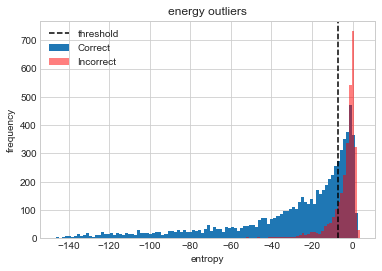

-----------------
  Exit_Name  Predictions  Test_Accuracy  RollOver_Accuracy  Threshold  Accepted  Accepted_Correct  Accepted_Ratio  Acceptance_Accuracy
0    exit_1        10000         0.6951             0.6951  -7.148542      5408              4821          0.5408             0.891457
metric:  energy threshold:  gmean
energy  lr_auc 0.18092833123812524 Best Threshold=-7.1485419273376465, G-Mean=0.7485113932605711, TPR=0.8078058379796654, FPR=0.3064307293914545


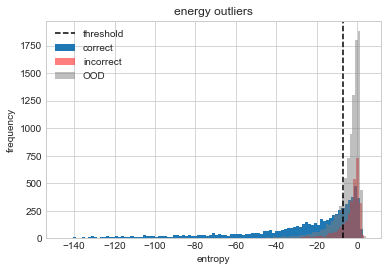

['exit_1']
  Exit_Name  ID_Inputs  OOD_Inputs  Test_Accuracy  Threshold  Accepted ID  Accepted OOD  Accepted_Correct  Accepted_ID_Ratio  Acceptance_Accuracy
0    exit_1      10000       10000         0.6951  -7.148542         5408          2074              4821           0.722801             0.644346


In [82]:
evaluate.calculateBranching(output_ID,threshold="gmean",metrics=["energy"],main_exit_included=False,plot=True)
evaluate.buildCompareDistribPlot(output_ID, output_OOD, ["energy"], "gmean",main_exit_included=False,plot=True)

metric:  energy threshold:  gmean
energy  lr_auc 0.17335474331960543 Best Threshold=-112.84371948242188, G-Mean=0.7591544553134861, TPR=0.7867924528301887, FPR=0.26751269035532993
['exit_1']
6225 inputs accepted 5772 Correct


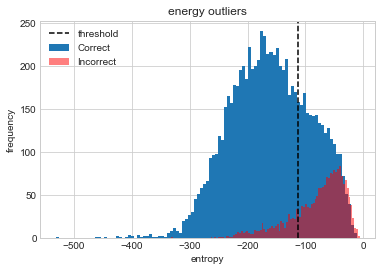

-----------------
  Exit_Name  Predictions  Test_Accuracy  RollOver_Accuracy   Threshold  Accepted  Accepted_Correct  Accepted_Ratio  Acceptance_Accuracy
0    exit_1        10000          0.788              0.788 -112.843719      6225              5772          0.6225             0.927229
metric:  energy threshold:  gmean
energy  lr_auc 0.17335474331960543 Best Threshold=-112.84371948242188, G-Mean=0.7591544553134861, TPR=0.7867924528301887, FPR=0.26751269035532993


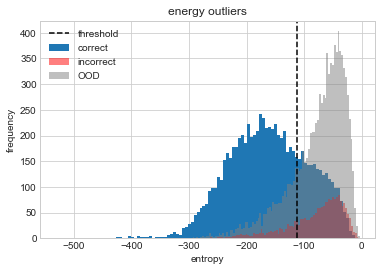

['exit_1']
  Exit_Name  ID_Inputs  OOD_Inputs  Test_Accuracy   Threshold  Accepted ID  Accepted OOD  Accepted_Correct  Accepted_ID_Ratio  Acceptance_Accuracy
0    exit_1      10000       10000          0.788 -112.843719         6225          2001              5772           0.756747             0.701678


In [78]:
#### 

# output_ID[0]['energy'] *= -1
# output_OOD[0]['energy'] *= -1
evaluate.calculateBranching(output_ID,threshold="gmean",metrics=["energy"],main_exit_included=False,plot=True)
evaluate.buildCompareDistribPlot(output_ID, output_OOD, ["energy"], "gmean",main_exit_included=False,plot=True)


### Entropy basic, softmax

metric:  energy threshold:  gmean
energy  lr_auc 0.17714387468758222 Best Threshold=-80.11234283447266, G-Mean=0.7539839972889404, TPR=0.8009278785322649, FPR=0.2902084152575698


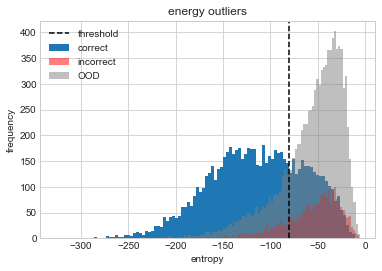

['exit_1']
  Exit_Name  ID_Inputs  OOD_Inputs  Test_Accuracy  Threshold  Accepted ID  Accepted OOD  Accepted_Correct  Accepted_ID_Ratio  Acceptance_Accuracy
0    exit_1      10000       10000         0.7629 -80.112343         5888          1987              5415           0.747683             0.687619
metric:  entropy threshold:  gmean
entropy  lr_auc 0.18754440355811158 Best Threshold=3.566016526157333e-30, G-Mean=0.7613356791654438, TPR=0.8152678194854491, FPR=0.28902870625245775


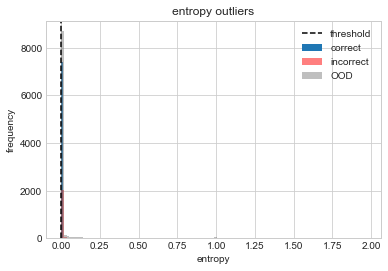

['exit_1']
  Exit_Name  ID_Inputs  OOD_Inputs  Test_Accuracy     Threshold  Accepted ID  Accepted OOD  Accepted_Correct  Accepted_ID_Ratio  Acceptance_Accuracy
0    exit_1      10000       10000         0.7629  3.566017e-30         5863          2080              5424           0.738134             0.682865
metric:  entropy_of_expected threshold:  gmean
entropy_of_expected  lr_auc 0.8288021041599185 Best Threshold=-0.07404013523423499, G-Mean=0.7584931705811183, TPR=0.742954515663914, FPR=0.22564318852804724


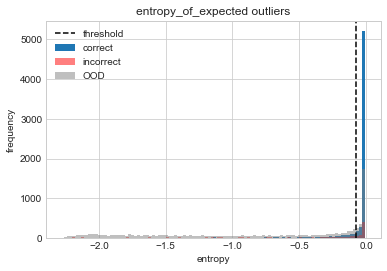

['exit_1']
  Exit_Name  ID_Inputs  OOD_Inputs  Test_Accuracy  Threshold  Accepted ID  Accepted OOD  Accepted_Correct  Accepted_ID_Ratio  Acceptance_Accuracy
0    exit_1      10000       10000         0.7629   -0.07404         6203          2373              5668           0.723298             0.660914


In [75]:
# evaluate.calculateBranching(output_ID,threshold="gmean",metrics=["entropy"],main_exit_included=False,plot=True)
evaluate.buildCompareDistribPlot(output_ID, output_OOD, ["energy"], "gmean",main_exit_included=False,plot=True)
evaluate.buildCompareDistribPlot(output_ID, output_OOD, ["entropy"], "gmean",main_exit_included=False,plot=True)
evaluate.buildCompareDistribPlot(output_ID, output_OOD, ["entropy_of_expected"], "gmean",main_exit_included=False,plot=True)


metric:  entropy threshold:  gmean
entropy  lr_auc 0.16119378747144633 Best Threshold=3.2519803047180176, G-Mean=0.7626920331181143, TPR=0.7808836789900812, FPR=0.2550758159856078
['exit_1']
6284 inputs accepted 5797 Correct


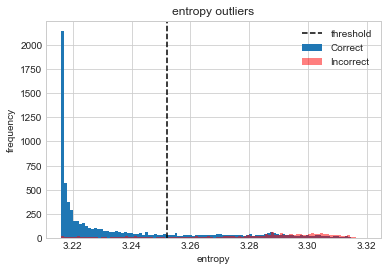

-----------------
  Exit_Name  Predictions  Test_Accuracy  RollOver_Accuracy  Threshold  Accepted  Accepted_Correct  Accepted_Ratio  Acceptance_Accuracy
0    exit_1        10000         0.7782             0.7782    3.25198      6284              5797          0.6284             0.922502
metric:  entropy threshold:  gmean
entropy  lr_auc 0.16119378747144633 Best Threshold=3.2519803047180176, G-Mean=0.7626920331181143, TPR=0.7808836789900812, FPR=0.2550758159856078


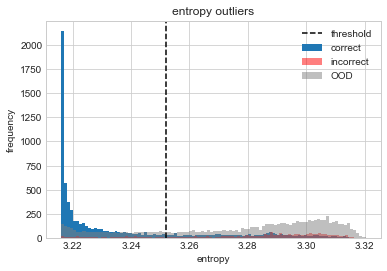

['exit_1']
  Exit_Name  ID_Inputs  OOD_Inputs  Test_Accuracy  Threshold  Accepted ID  Accepted OOD  Accepted_Correct  Accepted_ID_Ratio  Acceptance_Accuracy
0    exit_1      10000       10000         0.7782    3.25198         6284          2471              5797           0.717761             0.662136
metric:  entropy threshold:  gmean
entropy  lr_auc 0.16119378747144633 Best Threshold=3.2519803047180176, G-Mean=0.7626920331181143, TPR=0.7808836789900812, FPR=0.2550758159856078


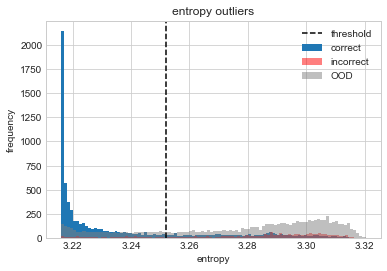

['exit_1']
  Exit_Name  ID_Inputs  OOD_Inputs  Test_Accuracy  Threshold  Accepted ID  Accepted OOD  Accepted_Correct  Accepted_ID_Ratio  Acceptance_Accuracy
0    exit_1      10000       10000         0.7782    3.25198         6284          2471              5797           0.717761             0.662136
metric:  entropy_of_expected threshold:  gmean
entropy_of_expected  lr_auc 0.8387209020191564 Best Threshold=-2.3025015735540744, G-Mean=0.7627921448397497, TPR=0.7555898226676947, FPR=0.22993688007213706


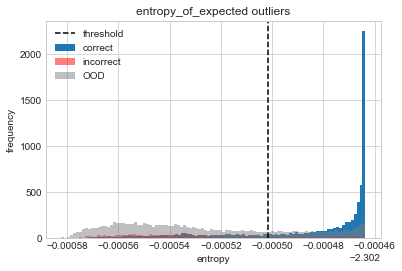

['exit_1']
  Exit_Name  ID_Inputs  OOD_Inputs  Test_Accuracy  Threshold  Accepted ID  Accepted OOD  Accepted_Correct  Accepted_ID_Ratio  Acceptance_Accuracy
0    exit_1      10000       10000         0.7782  -2.302502         6393          2605              5882           0.710491             0.653701


In [20]:
#MAEB with increasing annealing, 5 epochs

# output_ID[0]['energy'] *= -1
# output_OOD[0]['energy'] *= -1
evaluate.calculateBranching(output_ID,threshold="gmean",metrics=["entropy"],main_exit_included=False,plot=True)
evaluate.buildCompareDistribPlot(output_ID, output_OOD, ["entropy"], "gmean",main_exit_included=False,plot=True)
evaluate.buildCompareDistribPlot(output_ID, output_OOD, ["entropy"], "gmean",main_exit_included=False,plot=True)
evaluate.buildCompareDistribPlot(output_ID, output_OOD, ["entropy_of_expected"], "gmean",main_exit_included=False,plot=True)


metric:  energy threshold:  gmean
energy  lr_auc 0.22079788100602044 Best Threshold=1.253725290298462, G-Mean=0.749079566452178, TPR=0.7289879931389366, FPR=0.23027511816749485
['exit_1']
6826 inputs accepted 6351 Correct


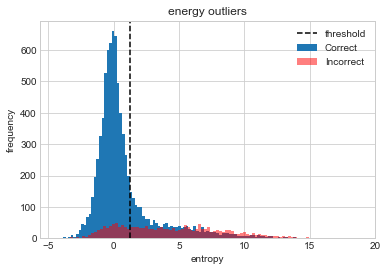

-----------------
  Exit_Name  Predictions  Test_Accuracy  RollOver_Accuracy  Threshold  Accepted  Accepted_Correct  Accepted_Ratio  Acceptance_Accuracy
0    exit_1        10000         0.8251             0.8251   1.253725      6826              6351          0.6826             0.930413
metric:  energy threshold:  gmean
energy  lr_auc 0.22079788100602044 Best Threshold=1.253725290298462, G-Mean=0.749079566452178, TPR=0.7289879931389366, FPR=0.23027511816749485


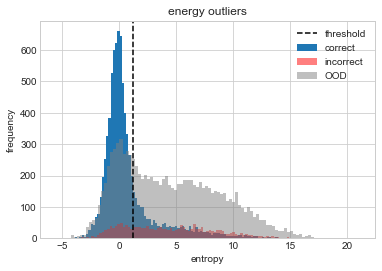

['exit_1']
  Exit_Name  ID_Inputs  OOD_Inputs  Test_Accuracy  Threshold  Accepted ID  Accepted OOD  Accepted_Correct  Accepted_ID_Ratio  Acceptance_Accuracy
0    exit_1      10000       10000         0.8251   1.253725         6826          3046              6351           0.691451             0.643335
metric:  entropy threshold:  gmean
entropy  lr_auc 0.15522903161451262 Best Threshold=1.6765216992453702e-09, G-Mean=0.7759122483901414, TPR=0.8073184676958262, FPR=0.2542722094291601


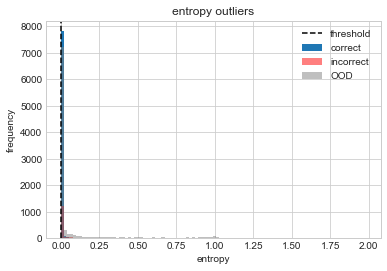

['exit_1']
  Exit_Name  ID_Inputs  OOD_Inputs  Test_Accuracy     Threshold  Accepted ID  Accepted OOD  Accepted_Correct  Accepted_ID_Ratio  Acceptance_Accuracy
0    exit_1      10000       10000         0.8251  1.676522e-09         6491          2360              6153           0.733363             0.695176
metric:  calibration threshold:  gmean
calibration  lr_auc 0.7571872536336535 Best Threshold=1.0, G-Mean=0.7420149173179921, TPR=0.8506847654829718, FPR=0.35277301315037163


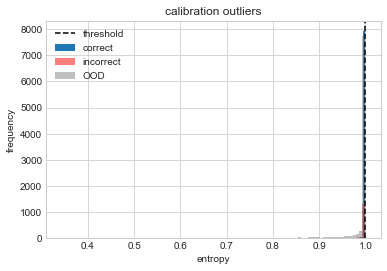

['exit_1']
  Exit_Name  ID_Inputs  OOD_Inputs  Test_Accuracy  Threshold  Accepted ID  Accepted OOD  Accepted_Correct  Accepted_ID_Ratio  Acceptance_Accuracy
0    exit_1      10000       10000         0.8251        1.0         7636          4020              7019           0.655113             0.602179


In [60]:
#MAEB with .1 annealing.


# output_ID[0]['energy'] *= -1
# output_OOD[0]['energy'] *= -1
evaluate.calculateBranching(output_ID,threshold="gmean",metrics=["energy"],main_exit_included=False,plot=True)
evaluate.buildCompareDistribPlot(output_ID, output_OOD, ["energy"], "gmean",main_exit_included=False,plot=True)
evaluate.buildCompareDistribPlot(output_ID, output_OOD, ["entropy"], "gmean",main_exit_included=False,plot=True)
evaluate.buildCompareDistribPlot(output_ID, output_OOD, ["calibration"], "gmean",main_exit_included=False,plot=True)

metric:  energy threshold:  gmean
energy  lr_auc 0.20346721470299695 Best Threshold=-6.480823993682861, G-Mean=0.72717239254512, TPR=0.7791767554479418, FPR=0.32136105860113423


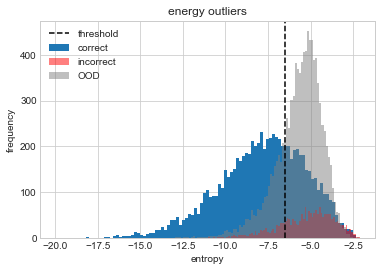

['exit_1']
  Exit_Name  ID_Inputs  OOD_Inputs  Test_Accuracy  Threshold  Accepted ID  Accepted OOD  Accepted_Correct  Accepted_ID_Ratio  Acceptance_Accuracy
0    exit_1      10000       10016         0.7935  -6.480824         5842          2338              5385           0.714181             0.658313
metric:  entropy threshold:  gmean
entropy  lr_auc 0.1550914131312068 Best Threshold=0.5148245692253113, G-Mean=0.7734423599821866, TPR=0.8208232445520581, FPR=0.2712035286704474


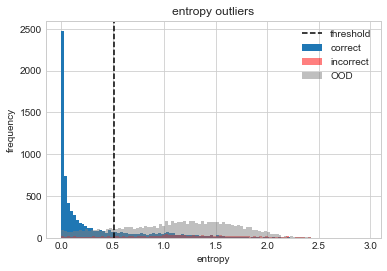

['exit_1']
  Exit_Name  ID_Inputs  OOD_Inputs  Test_Accuracy  Threshold  Accepted ID  Accepted OOD  Accepted_Correct  Accepted_ID_Ratio  Acceptance_Accuracy
0    exit_1      10000       10016         0.7935   0.514825         6154          1692              5783           0.784349             0.737063
metric:  calibration threshold:  gmean
calibration  lr_auc 0.8467247963553755 Best Threshold=0.900549590587616, G-Mean=0.772614004666552, TPR=0.7470699432892249, FPR=0.2009685230024213


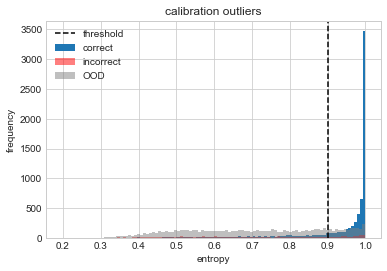

['exit_1']
  Exit_Name  ID_Inputs  OOD_Inputs  Test_Accuracy  Threshold  Accepted ID  Accepted OOD  Accepted_Correct  Accepted_ID_Ratio  Acceptance_Accuracy
0    exit_1      10000       10016         0.7935    0.90055         6343          1980              5928           0.762105             0.712243


In [50]:
evaluate.buildCompareDistribPlot(output_ID, output_OOD_SVHN, ["energy"], "gmean",main_exit_included=False,plot=True)
evaluate.buildCompareDistribPlot(output_ID, output_OOD_SVHN, ["entropy"], "gmean",main_exit_included=False,plot=True)
evaluate.buildCompareDistribPlot(output_ID, output_OOD_SVHN, ["calibration"], "gmean",main_exit_included=False,plot=True)

metric:  energy threshold:  gmean
energy  lr_auc 0.2034238777233069 Best Threshold=-5.694293022155762, G-Mean=0.7259240529492147, TPR=0.7856579984239559, FPR=0.32926829268292684
['exit_1']
5550 inputs accepted 5005 Correct


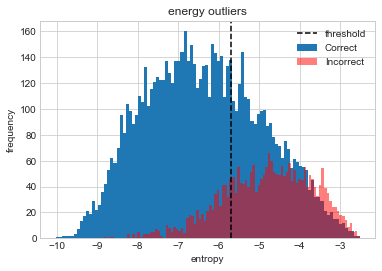

-----------------
  Exit_Name  Predictions  Test_Accuracy  RollOver_Accuracy  Threshold  Accepted  Accepted_Correct  Accepted_Ratio  Acceptance_Accuracy
0    exit_1        10000         0.7462             0.7462  -5.694293      5550              5005           0.555             0.901802
metric:  energy threshold:  gmean
energy  lr_auc 0.2034238777233069 Best Threshold=-5.694293022155762, G-Mean=0.7259240529492147, TPR=0.7856579984239559, FPR=0.32926829268292684


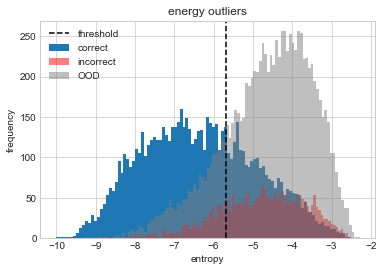

['exit_1']
  Exit_Name  ID_Inputs  OOD_Inputs  Test_Accuracy  Threshold  Accepted ID  Accepted OOD  Accepted_Correct  Accepted_ID_Ratio  Acceptance_Accuracy
0    exit_1      10000       10000         0.7462  -5.694293         5550          1821              5005           0.752951             0.679012


In [27]:
# len(output_ID[0].loc[output_ID[0]['calibration']<.9920002270226526])
# output_ID[0]['energy'] *= -1
# output_OOD[0]['energy'] *= -1
evaluate.calculateBranching(output_ID,threshold="gmean",metrics=["energy"],main_exit_included=False,plot=True)
evaluate.buildCompareDistribPlot(output_ID, output_OOD, ["energy"], "gmean",main_exit_included=False,plot=True)

metric:  calibration threshold:  gmean
calibration  lr_auc 0.8080832287599926 Best Threshold=0.9231361150741577, G-Mean=0.7391455586104364, TPR=0.7225378787878788, FPR=0.24386503067484663
['exit_1']
5977 inputs accepted 5341 Correct


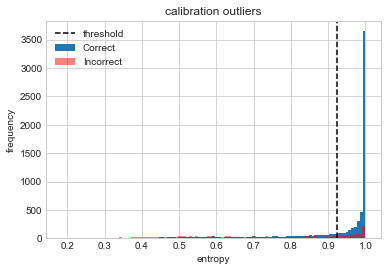

-----------------
  Exit_Name  Predictions  Test_Accuracy  RollOver_Accuracy  Threshold  Accepted  Accepted_Correct  Accepted_Ratio  Acceptance_Accuracy
0    exit_1        10000         0.7392             0.7392   0.923136      5977              5341          0.5977             0.893592
metric:  calibration threshold:  gmean
calibration  lr_auc 0.8080832287599926 Best Threshold=0.9231361150741577, G-Mean=0.7391455586104364, TPR=0.7225378787878788, FPR=0.24386503067484663


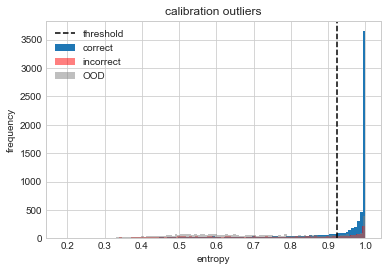

['exit_1']
  Exit_Name  ID_Inputs  OOD_Inputs  Test_Accuracy  Threshold  Accepted ID  Accepted OOD  Accepted_Correct  Accepted_ID_Ratio  Acceptance_Accuracy
0    exit_1      10000        5056         0.7392   0.923136         5977           934              5341           0.864853             0.772826


In [43]:
# len(output_ID[0].loc[output_ID[0]['calibration']<.9920002270226526])
# output_ID[0]['energy'] *= -1
# output_OOD_SVHN[0]['energy'] *= -1
evaluate.calculateBranching(output_ID,threshold= "gmean",metrics=["calibration"],main_exit_included=False,plot=True)
evaluate.buildCompareDistribPlot(output_ID, output_OOD_SVHN, ["calibration"], "gmean",main_exit_included=False,plot=True)


metric:  entropy_of_expected threshold:  gmean
entropy_of_expected  lr_auc 0.24144028820744695 Best Threshold=-2.302582270287931, G-Mean=0.3210840971000664, TPR=0.2536525974025974, FPR=0.593558282208589
['exit_1']
3416 inputs accepted 1868 Correct


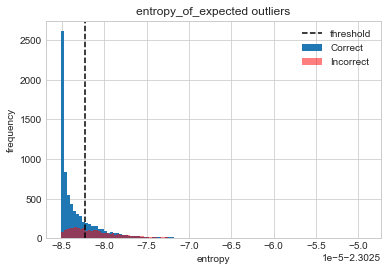

-----------------
  Exit_Name  Predictions  Test_Accuracy  RollOver_Accuracy  Threshold  Accepted  Accepted_Correct  Accepted_Ratio  Acceptance_Accuracy
0    exit_1        10000         0.7392             0.7392  -2.302582      3416              1868          0.3416             0.546838
metric:  entropy_of_expected threshold:  gmean
entropy_of_expected  lr_auc 0.24144028820744695 Best Threshold=-2.302582270287931, G-Mean=0.3210840971000664, TPR=0.2536525974025974, FPR=0.593558282208589


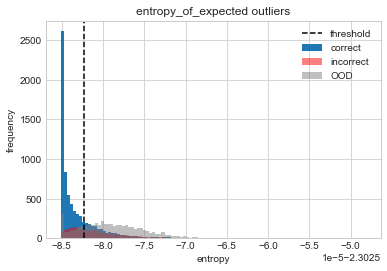

['exit_1']
  Exit_Name  ID_Inputs  OOD_Inputs  Test_Accuracy  Threshold  Accepted ID  Accepted OOD  Accepted_Correct  Accepted_ID_Ratio  Acceptance_Accuracy
0    exit_1      10000        5056         0.7392  -2.302582         3416          3993              1868           0.461061             0.252126


In [39]:
# len(output_ID[0].loc[output_ID[0]['calibration']<.9920002270226526])
# output_ID[0]['energy'] *= -1
# output_OOD[0]['energy'] *= -1
evaluate.calculateBranching(output_ID,threshold= "gmean",metrics=["entropy_of_expected"],main_exit_included=False,plot=True)
evaluate.buildCompareDistribPlot(output_ID, output_OOD_SVHN, ["entropy_of_expected"], "gmean",main_exit_included=False,plot=True)


metric:  energy threshold:  -4.603985699740324
['exit_1']
9066 inputs accepted 7480 Correct


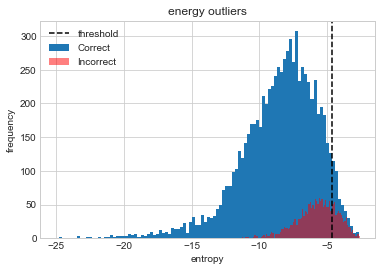

-----------------
  Exit_Name  Predictions  Test_Accuracy  RollOver_Accuracy  Threshold  Accepted  Accepted_Correct  Accepted_Ratio  Acceptance_Accuracy
0    exit_1        10000         0.7887             0.7887  -4.603986      9066              7480          0.9066             0.825061
metric:  energy threshold:  -4.603985699740324


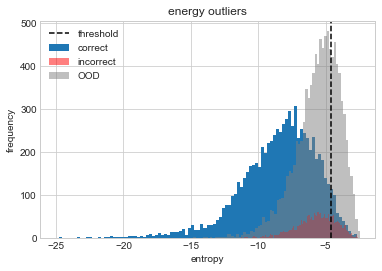

['exit_1']
  Exit_Name  ID_Inputs  OOD_Inputs  Test_Accuracy  Threshold  Accepted ID  Accepted OOD  Accepted_Correct  Accepted_ID_Ratio  Acceptance_Accuracy
0    exit_1      10000       10000         0.7887  -4.603986         9066          6938              7480           0.566483             0.467383


In [112]:
# len(output_ID[0].loc[output_ID[0]['calibration']<.9920002270226526])
evaluate.calculateBranching(output_ID,threshold= -4.603985699740324,metrics=["energy"],main_exit_included=False,plot=True)
evaluate.buildCompareDistribPlot(output_ID, output_OOD, ["energy"], -4.603985699740324,main_exit_included=False,plot=True)

metric:  calibration threshold:  0.608011124109981
['exit_1']
9015 inputs accepted 7488 Correct


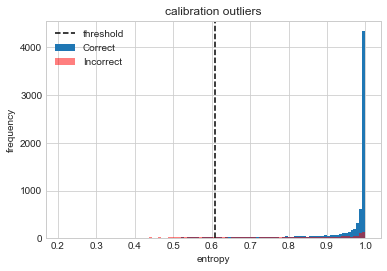

-----------------
  Exit_Name  Predictions  Test_Accuracy  RollOver_Accuracy  Threshold  Accepted  Accepted_Correct  Accepted_Ratio  Acceptance_Accuracy
0    exit_1        10000         0.7887             0.7887   0.608011      9015              7488          0.9015             0.830616
metric:  calibration threshold:  0.608011124109981


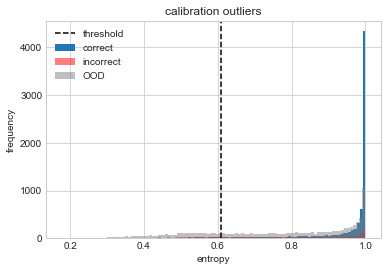

['exit_1']
  Exit_Name  ID_Inputs  OOD_Inputs  Test_Accuracy  Threshold  Accepted ID  Accepted OOD  Accepted_Correct  Accepted_ID_Ratio  Acceptance_Accuracy
0    exit_1      10000       10000         0.7887   0.608011         9015          7270              7488           0.553577              0.45981


In [114]:
# 10 classifier loss
evaluate.calculateBranching(output_ID,threshold= 0.608011124109981,metrics=["calibration"],main_exit_included=False,plot=True)
evaluate.buildCompareDistribPlot(output_ID, output_OOD, ["calibration"], 0.608011124109981,main_exit_included=False,plot=True)

metric:  energy threshold:  gmean
energy  lr_auc 0.21612913865770117 Best Threshold=-7.949747562408447, G-Mean=0.716250537950401, TPR=0.7334260547056096, FPR=0.3005227591482851


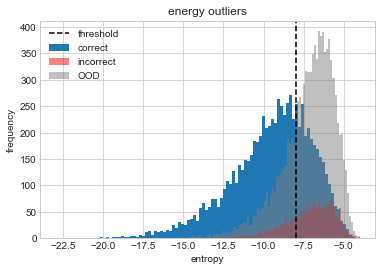

['exit_1']
  Exit_Name  ID_Inputs  OOD_Inputs  Test_Accuracy  Threshold  Accepted ID  Accepted OOD  Accepted_Correct  Accepted_ID_Ratio  Acceptance_Accuracy
0    exit_1      10000       10000         0.7843  -7.949748         6062          2638              5486           0.696782             0.630575


In [49]:
#
evaluate.buildCompareDistribPlot(output_ID, output_OOD, ["energy"], "gmean",main_exit_included=False,plot=True)

metric:  energy threshold:  gmean
energy  lr_auc 0.20346703161736324 Best Threshold=-6.480824947357178, G-Mean=0.72717239254512, TPR=0.7791767554479418, FPR=0.32136105860113423


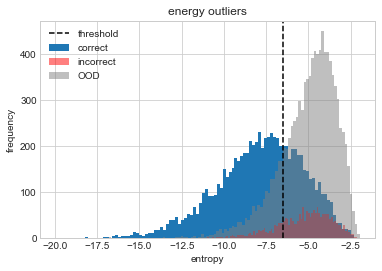

['exit_1']
  Exit_Name  ID_Inputs  OOD_Inputs  Test_Accuracy  Threshold  Accepted ID  Accepted OOD  Accepted_Correct  Accepted_ID_Ratio  Acceptance_Accuracy
0    exit_1      10000       10000         0.7935  -6.480825         5842          1789              5385           0.765562             0.705674


In [43]:

#brevisfinetuned
evaluate.buildCompareDistribPlot(output_ID, output_OOD, ["energy"], "gmean",main_exit_included=False,plot=True)

metric:  entropy threshold:  gmean
entropy  lr_auc 0.16623896968266486 Best Threshold=0.7268590331077576, G-Mean=0.764591262925563, TPR=0.8015762633286972, FPR=0.270687237026648


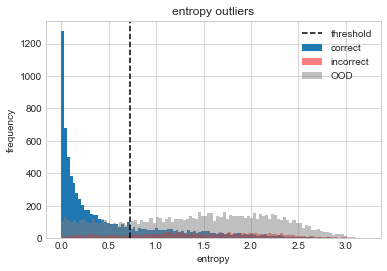

['exit_1']
  Exit_Name  ID_Inputs  OOD_Inputs  Test_Accuracy  Threshold  Accepted ID  Accepted OOD  Accepted_Correct  Accepted_ID_Ratio  Acceptance_Accuracy
0    exit_1      10000       10000         0.7843   0.726859         6149          2315              5720           0.726489             0.675803


In [48]:
# evaluate.calculateBranching(output_ID,threshold="gmean",metrics=["energy"],main_exit_included=False,plot=True)
evaluate.buildCompareDistribPlot(output_ID, output_OOD, ["entropy"], "gmean",main_exit_included=False,plot=True)

metric:  energy threshold:  gmean
energy  lr_auc 0.19471475780987121 Best Threshold=-5.467545986175537, G-Mean=0.7423624715589808, TPR=0.7285291214215203, FPR=0.2435415099071984
['exit_1']
6583 inputs accepted 6032 Correct


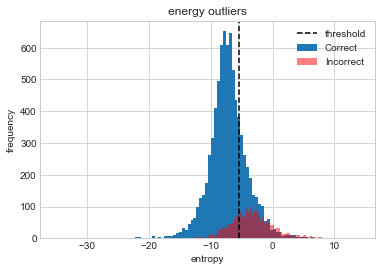

-----------------
  Exit_Name  Predictions  Test_Accuracy  RollOver_Accuracy  Threshold  Accepted  Accepted_Correct  Accepted_Ratio  Acceptance_Accuracy
0    exit_1        10000         0.7974             0.7974  -5.467546      6583              6032          0.6583               0.9163


In [32]:
evaluate.calculateBranching(output_ID,threshold="gmean",metrics=["energy"],main_exit_included=False,plot=True)

metric:  entropy threshold:  gmean
entropy  lr_auc 0.17311562992082932 Best Threshold=9.53557901084423e-06, G-Mean=0.7595122853660139, TPR=0.8019366197183099, FPR=0.28066770186335405
['exit_1']
6010 inputs accepted 5559 Correct


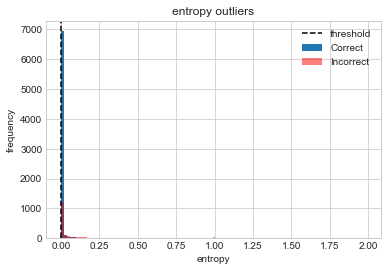

-----------------
  Exit_Name  Predictions  Test_Accuracy  RollOver_Accuracy  Threshold  Accepted  Accepted_Correct  Accepted_Ratio  Acceptance_Accuracy
0    exit_1        10000         0.7728             0.7728    0.00001      6010              5559           0.601             0.924958
metric:  calibration threshold:  gmean
calibration  lr_auc 0.7993558611633569 Best Threshold=0.9999996423721313, G-Mean=0.7597171989770177, TPR=0.71972049689441, FPR=0.19806338028169015
['exit_1']
6012 inputs accepted 5562 Correct


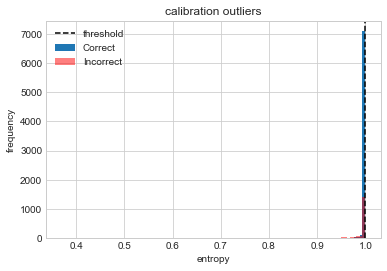

-----------------
  Exit_Name  Predictions  Test_Accuracy  RollOver_Accuracy  Threshold  Accepted  Accepted_Correct  Accepted_Ratio  Acceptance_Accuracy
0    exit_1        10000         0.7728             0.7728        1.0      6012              5562          0.6012              0.92515
metric:  energy threshold:  gmean
energy  lr_auc 0.18841818460582338 Best Threshold=-4.751164436340332, G-Mean=0.7425228212148985, TPR=0.7909330985915493, FPR=0.30292443064182195
['exit_1']
5863 inputs accepted 5387 Correct


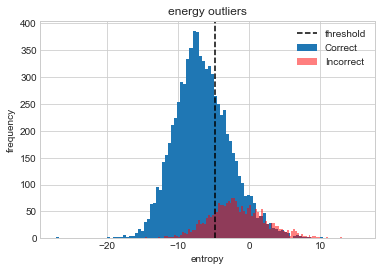

-----------------
  Exit_Name  Predictions  Test_Accuracy  RollOver_Accuracy  Threshold  Accepted  Accepted_Correct  Accepted_Ratio  Acceptance_Accuracy
0    exit_1        10000         0.7728             0.7728  -4.751164      5863              5387          0.5863             0.918813


In [24]:
#### brevisEnergy
evaluate.calculateBranching(output_ID,threshold="gmean",metrics=["entropy"],main_exit_included=False,plot=True)
evaluate.calculateBranching(output_ID,threshold="gmean",metrics=["calibration"],main_exit_included=False,plot=True)
evaluate.calculateBranching(output_ID,threshold="gmean",metrics=["energy"],main_exit_included=False,plot=True)

metric:  entropy threshold:  gmean
entropy  lr_auc 0.15281331794148512 Best Threshold=0.36484479904174805, G-Mean=0.7793896439777206, TPR=0.8260665729020159, FPR=0.26464980297445023
['exit_1']
6157 inputs accepted 5785 Correct


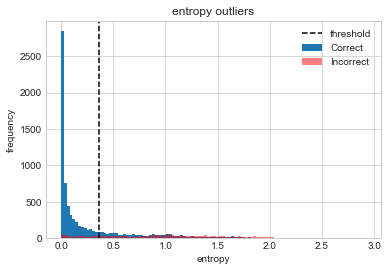

-----------------
  Exit_Name  Predictions  Test_Accuracy  RollOver_Accuracy  Threshold  Accepted  Accepted_Correct  Accepted_Ratio  Acceptance_Accuracy
0    exit_1        10000         0.7867             0.7867   0.364845      6157              5785          0.6157             0.939581
metric:  calibration threshold:  gmean
calibration  lr_auc 0.8474298539520513 Best Threshold=0.9511922001838684, G-Mean=0.7793548530144452, TPR=0.723782890555485, FPR=0.16080637599624942
['exit_1']
6037 inputs accepted 5694 Correct


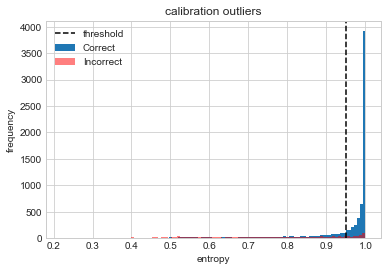

-----------------
  Exit_Name  Predictions  Test_Accuracy  RollOver_Accuracy  Threshold  Accepted  Accepted_Correct  Accepted_Ratio  Acceptance_Accuracy
0    exit_1        10000         0.7867             0.7867   0.951192      6037              5694          0.6037             0.943184
metric:  energy threshold:  gmean
energy  lr_auc 0.20503034776888227 Best Threshold=-8.527923583984375, G-Mean=0.7279295424456429, TPR=0.7684013127051101, FPR=0.31041057582305837
['exit_1']
5920 inputs accepted 5425 Correct


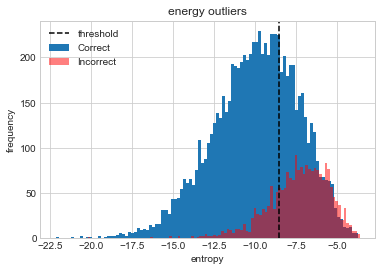

-----------------
  Exit_Name  Predictions  Test_Accuracy  RollOver_Accuracy  Threshold  Accepted  Accepted_Correct  Accepted_Ratio  Acceptance_Accuracy
0    exit_1        10000         0.7867             0.7867  -8.527924      5920              5425           0.592             0.916385


In [18]:
evaluate.calculateBranching(output_ID,threshold="gmean",metrics=["entropy"],main_exit_included=False,plot=True)
evaluate.calculateBranching(output_ID,threshold="gmean",metrics=["calibration"],main_exit_included=False,plot=True)
evaluate.calculateBranching(output_ID,threshold="gmean",metrics=["energy"],main_exit_included=False,plot=True)

metric:  energy threshold:  gmean
energy  lr_auc 0.20503034776888227 Best Threshold=-8.527923583984375, G-Mean=0.7279295424456429, TPR=0.7684013127051101, FPR=0.31041057582305837


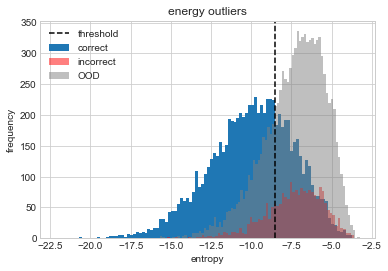

['exit_1']
  Exit_Name  ID_Inputs  OOD_Inputs  Test_Accuracy  Threshold  Accepted ID  Accepted OOD  Accepted_Correct  Accepted_ID_Ratio  Acceptance_Accuracy
0    exit_1      10000       10000         0.7867  -8.527924         5920          2390              5425           0.712395             0.652828
metric:  calibration threshold:  gmean
calibration  lr_auc 0.8474298539520513 Best Threshold=0.9511922001838684, G-Mean=0.7793548530144452, TPR=0.723782890555485, FPR=0.16080637599624942


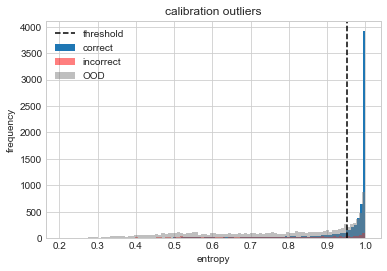

['exit_1']
  Exit_Name  ID_Inputs  OOD_Inputs  Test_Accuracy  Threshold  Accepted ID  Accepted OOD  Accepted_Correct  Accepted_ID_Ratio  Acceptance_Accuracy
0    exit_1      10000       10000         0.7867   0.951192         6037          2500              5694           0.707157             0.666979
metric:  entropy threshold:  mean


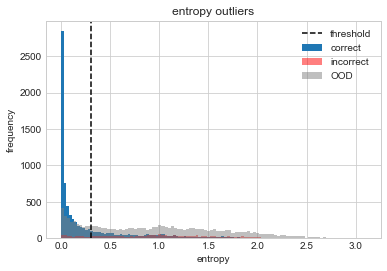

['exit_1']
  Exit_Name  ID_Inputs  OOD_Inputs  Test_Accuracy  Threshold  Accepted ID  Accepted OOD  Accepted_Correct  Accepted_ID_Ratio  Acceptance_Accuracy
0    exit_1      10000       10000         0.7867   0.306079         5905          2309              5581           0.718895              0.67945


In [19]:
evaluate.buildCompareDistribPlot(output_ID, output_OOD, ["energy"], "gmean",main_exit_included=False,plot=True)
evaluate.buildCompareDistribPlot(output_ID, output_OOD, ["calibration"], "gmean",main_exit_included=False,plot=True)
evaluate.buildCompareDistribPlot(output_ID, output_OOD, ["entropy"], "mean",main_exit_included=False,plot=True)

metric:  energy threshold:  gmean
energy  lr_auc 0.18841818460582338 Best Threshold=-4.751164436340332, G-Mean=0.7425228212148985, TPR=0.7909330985915493, FPR=0.30292443064182195


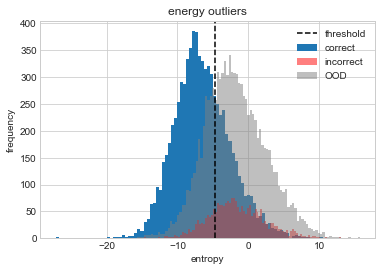

['exit_1']
  Exit_Name  ID_Inputs  OOD_Inputs  Test_Accuracy  Threshold  Accepted ID  Accepted OOD  Accepted_Correct  Accepted_ID_Ratio  Acceptance_Accuracy
0    exit_1      10000       10000         0.7728  -4.751164         5863          2610              5387           0.691963             0.635784


In [25]:
evaluate.buildCompareDistribPlot(output_ID, output_OOD, ["energy"], "gmean",main_exit_included=False,plot=True)


metric:  energy threshold:  gmean
energy  lr_auc 0.19471475780987121 Best Threshold=-5.467545986175537, G-Mean=0.7423624715589808, TPR=0.7285291214215203, FPR=0.2435415099071984


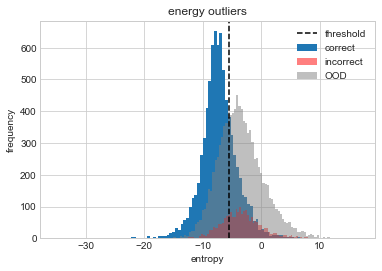

['exit_1']
  Exit_Name  ID_Inputs  OOD_Inputs  Test_Accuracy  Threshold  Accepted ID  Accepted OOD  Accepted_Correct  Accepted_ID_Ratio  Acceptance_Accuracy
0    exit_1      10000       10000         0.7974  -5.467546         6583          3179              6032            0.67435             0.617906


In [33]:
#epochs brevisEnergy 10
evaluate.buildCompareDistribPlot(output_ID, output_OOD, ["energy"], "gmean",main_exit_included=False,plot=True)

metric:  energy threshold:  gmean
energy  lr_auc 0.20346703161736324 Best Threshold=-6.480824947357178, G-Mean=0.72717239254512, TPR=0.7791767554479418, FPR=0.32136105860113423


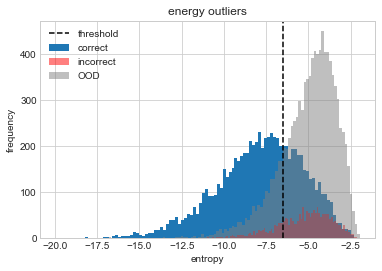

['exit_1']
  Exit_Name  ID_Inputs  OOD_Inputs  Test_Accuracy  Threshold  Accepted ID  Accepted OOD  Accepted_Correct  Accepted_ID_Ratio  Acceptance_Accuracy
0    exit_1      10000       10000         0.7935  -6.480825         5842          1789              5385           0.765562             0.705674
metric:  calibration threshold:  gmean
calibration  lr_auc 0.8467248878981921 Best Threshold=0.9005506634712219, G-Mean=0.772614004666552, TPR=0.7470699432892249, FPR=0.2009685230024213


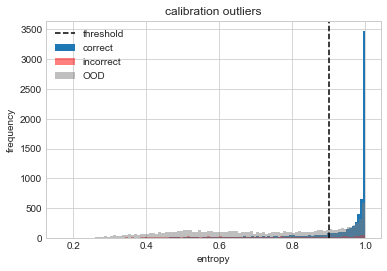

['exit_1']
  Exit_Name  ID_Inputs  OOD_Inputs  Test_Accuracy  Threshold  Accepted ID  Accepted OOD  Accepted_Correct  Accepted_ID_Ratio  Acceptance_Accuracy
0    exit_1      10000       10000         0.7935   0.900551         6343          2700              5928           0.701427             0.655535


In [27]:
evaluate.buildCompareDistribPlot(output_ID, output_OOD, ["energy"], "gmean",main_exit_included=False,plot=True)
evaluate.buildCompareDistribPlot(output_ID, output_OOD, ["calibration"], "gmean",main_exit_included=False,plot=True)
# evaluate.buildCompareDistribPlot(output_ID, output_OOD, ["entropy"], "mean",main_exit_included=False,plot=True)

In [114]:
def brevisCrossEnergy(lambda_callback: lambda_update, input_in=True):
    ''' Proposed Loss function for BrevisNet branch classifiers
        consists of the Cross Entropy loss  + reverse dirichlet KL + regularizing dirichlet entropy mean
    '''
    input_ID = input_in
    m_in = -25
    m_out = -7
    def brevisCrossEnergy(p, logits):
        # logits += 1e-10
        evidence = tf.exp(logits)
#         evidence = tf.exp(tf.clip_by_value(logits/10,-10,10))
        alpha = evidence + 1
        S = tf.reduce_sum(alpha,axis=1,keepdims=True) 
        E = alpha - 1
        m = alpha / S
        A = tf.reduce_sum((p-m)**2, axis=1, keepdims=True) 
        B = tf.reduce_sum(alpha*(S-alpha)/(S*S*(S+1)), axis=1, keepdims=True) 
        
        annealing_coef =  lambda_callback.lambda_t
        
        softmax = tf.nn.softmax(logits)

        CE = tf.keras.losses.categorical_crossentropy(p,softmax)
        Ec = 0
        # tf.print(" :",Ec)
        if input_ID:
            Ec = -tf.reduce_logsumexp(logits)
            Ec = 0.1 * (tf.nn.relu(Ec-m_in)**2)
        else:
            Ec = -tf.reduce_logsumexp(logits)
            Ec = 0.1 * (tf.nn.relu(m_out -Ec)**2)
        
        # tf.print(Ec)
        if tf.math.is_nan(tf.reduce_sum(logits)):
            tf.print("logits",logits, summarize=-1)
        # alp = E*(1-p) + 1 
        C =annealing_coef * DirichletKLLoss(p,logits, True)
        # # tf.print(C)
        # # C = annealing_coef * KL(alp,10)
        # # Ec = tf.math.maximum(annealing_coef * ((tf.reduce_logsumexp(logits))),-25)
        # # tf.print(":",annealing_coef * Ec)
        D = 0.0001 * -tf.reduce_mean(tfp.distributions.Dirichlet(alpha).entropy()) ###entropy of the dirichlet distribution as a smoothing regularizer. 
        # if input_ID:
        #     return CE+Ec
        # else:
        #     return Ec
        return CE + C + D
    
    return  brevisCrossEnergy
# loss = kl_loss(lambda_callback)


class EnergyMetric(tf.keras.metrics.Metric):

    def __init__(self, name='EnergyMetric', **kwargs):
        super(EnergyMetric, self).__init__(name=name, **kwargs)
        self.step =  self.add_weight(name='tp', initializer='zeros')
        self.step.assign(0)
        self.energy = self.add_weight(name='tp', initializer='zeros')
        self.energy_avg=self.add_weight(name='tp', initializer='zeros')
        
    def update_state(self, Energy,batch_size):
        self.step.assign_add(1)
        self.energy.assign_add(Energy)
        # tf.print("step:",self.step,"past_energy",self.energy, "energy", Energy)
        self.energy_avg.assign(self.energy/self.step)
        # self.energy.assign(self.energy /self.step)

    def result(self):
        return self.energy_avg

    def reset_states(self):
        self.energy.assign(0)
        self.step.assign(0)


model = tf.keras.models.load_model('./models/resnet50_finetuned_brev.hdf5')
lambda_callback = lambda_update(100,0,max_t = 1)
# loss_fn = brevisCrossEnergy(lambda_callback, False)
loss_fn = tf.keras.losses.CategoricalCrossentropy(from_logits=True)
model.compile(optimizer="adam",#tf.optimizers.SGD(learning_rate=0.01, momentum=0.9),
                loss=loss_fn,
                metrics = ['accuracy'])
# model.fit(train_ds100.take(1000), validation_data=validation_ds100,epochs = 10,callbacks=[lambda_callback])


import time
def train_model(model, dataset, ood_dataset, epochs = 1):
    
    train_acc_metric = keras.metrics.CategoricalAccuracy()
    
    ID_energy_metric = EnergyMetric(name="IDEnergy")
    OOD_energy_metric = EnergyMetric(name="OODEnergy")
    
    val_acc_metric = keras.metrics.CategoricalAccuracy()
    loss_fn = model.loss
    opt_fn = model.optimizer
    
    annealing_coef=0
    @tf.function
    def double_step(X, y, X_ood):
        m_in = -25
        m_out = -7
        
        with tf.GradientTape() as tape:
            # make a prediction using the model and then calculate the # loss
            logits = model(X,training=True)
            softmax= tf.nn.softmax(logits)
            ood_logits = model(X_ood)
            softmax_ood = tf.nn.softmax(ood_logits)
            loss_value = tf.reduce_mean(loss_fn(y, logits))
            
            Ec_in = -tf.reduce_logsumexp(logits,axis=1)
            
    
            Ec_ood = -tf.reduce_logsumexp(ood_logits,axis=1)
        
            # tf.print(tf.reduce_mean((tf.nn.relu(Ec_in -m_in))))
            Ec_in = tf.reduce_mean(0.001 * (tf.nn.relu(Ec_in -m_in)**2))
            Ec_ood = tf.reduce_mean(tf.nn.relu(m_out-Ec_ood)**2)
            
            ID_energy_metric.update_state(Ec_in,len(logits))
            OOD_energy_metric.update_state(Ec_ood,len(ood_logits))
            
            # tf.print(Ec_in, Ec_ood)
            # Add any extra losses created during the forward pass.
            loss_value += (sum(model.losses) + Ec_in )#+ Ec_ood) 
            
        # calculate the gradients using our tape and then update the # model weights
        grads = tape.gradient(loss_value, model.trainable_variables)
        opt_fn.apply_gradients(zip(grads, model.trainable_variables))
        train_acc_metric.update_state(y, logits)
        
        return loss_value

            
    @tf.function  
    def train_step(X, y):
        # keep track of our gradients
        with tf.GradientTape() as tape:
            # make a prediction using the model and then calculate the # loss
            logits = model(X,training=True)
            loss_value = tf.reduce_mean(loss_fn(y, logits))
            # Add any extra losses created during the forward pass.
            loss_value += sum(model.losses)
            
        # calculate the gradients using our tape and then update the # model weights
        grads = tape.gradient(loss_value, model.trainable_variables)
        opt_fn.apply_gradients(zip(grads, model.trainable_variables))
        train_acc_metric.update_state(y, logits)
        # accuracy = tf.reduce_sum(tf.one_hot(tf.argmax(pred,axis=1),10)*y)
        return loss_value
    
    @tf.function  
    def test_step(X, y):
        logits = model(X,training=False)
        loss_value = tf.reduce_mean(loss_fn(y, logits))
        loss_value += sum(model.losses)
        val_acc_metric.update_state(y, val_logits)
            
        # calculate the gradients using our tape and then update the # model weights
        grads = tape.gradient(loss_value, model.trainable_variables)
        opt_fn.apply_gradients(zip(grads, model.trainable_variables))
        train_acc_metric.update_state(y, logits)
        # accuracy = tf.reduce_sum(tf.one_hot(tf.argmax(pred,axis=1),10)*y)
        return loss_value
    
    for epoch in range(0, epochs):
        # show the current epoch number
        print("[INFO] starting epoch {}/{}...".format(
            epoch + 1, epochs), end="")
        
        print("")
        
        # epochStart = time.time()
        it = iter(dataset)
        
        it_ood = iter(ood_dataset)
        # loop over the data in batch size increments
        limit = 10
        loss = 0
        accuracy = 0
        batch_count=len(dataset)
        
        for i, (x,y) in enumerate(dataset):
        # for i, element in enumerate(dataset):
            # sys.stdout.flush()
            # determine starting and ending slice indexes for the current
            # batch
            # take a step
            # x, y = next(it)
            # print(x)
            x_ood, y_ood = next(it_ood)
            # print(x.shape,y.shape)
            
            # loss = train_step(x,y)
            loss = double_step(x, y, x_ood)
            
            # loss , _accuracy = double_step(x, y, x_ood, model.loss, model.optimizer)
            # loss += _loss 
            # print(accuracy, _accuracy)
            
            train_acc = train_acc_metric.result()        
            # accuracy += _accuracy
            loss_str = "{0:.4f}".format(loss)
            acc_str = "{0:.4f}".format(float(train_acc))
            E_id = "{0:.4f}".format(float(ID_energy_metric.result()))
            E_ood = "{0:.4f}".format(float(OOD_energy_metric.result()))
            # print(E_id, E_ood)
            metrics_str = "ID_energy {}, OOD_energy {}".format(E_id,E_ood)
            print("{}/{}, loss: {}, Accuracy: {} {}".format(i+1,batch_count, loss_str, acc_str,metrics_str), end="\r")
            
            ### TODO, breaks on the final accuracy of an epoch, not sure why.
            # time.sleep(0)  # EDIT, somehow even this works too.
            # sys.stdout.flush()
            
            # Reset training metrics at the end of each epoch
        # annealing_coef += 0.01
        train_acc_metric.reset_states()
        ID_energy_metric.reset_states()
        OOD_energy_metric.reset_states()
        print()
        
        # show timing information for the epoch
        # epochEnd = time.time()
        # elapsed = (epochEnd - epochStart) / 60.0
        # print("took {:.4} minutes".format(elapsed))
        
train_model(model,train_ds,train_ds100,10)
# print(len(train_ds))
# print(len(test_ds))
    

[INFO] starting epoch 1/10...
1407/1407, loss: 1.2824, Accuracy: 0.5849 ID_energy 0.0854, OOD_energy 2947773.0000
[INFO] starting epoch 2/10...
1407/1407, loss: 1.6656, Accuracy: 0.6965 ID_energy 0.0073, OOD_energy 367.9426
[INFO] starting epoch 3/10...


KeyboardInterrupt: 

In [26]:

base_model = tf.keras.applications.resnet50.ResNet50(input_shape=(32, 32, 3),
     weights='imagenet',include_top=False)


x = base_model.output
x = tf.keras.layers.GlobalAveragePooling2D()(x)
x = tf.keras.layers.Flatten()(x)
x = tf.keras.layers.Dense(1024, activation="relu")(x)
x = tf.keras.layers.Dense(512, activation="relu")(x)
x = tf.keras.layers.Dense(10, name="classification")(x)

model_energy = tf.keras.models.Model(inputs=base_model.input, outputs=x)

lambda_callback = lambda_update(1000,0,max_t = 0.01)
branch_loss = brevisEnergy(lambda_callback)
# branch_loss = keras.losses.CategoricalCrossentropy(from_logits=True)
trunk_loss = keras.losses.CategoricalCrossentropy(from_logits=True)
# loss = kl_loss(lambda_callback)
earlyStop = tf.keras.callbacks.EarlyStopping(monitor="val_accuracy",patience=4,restore_best_weights=True)

model_energy.compile(loss=trunk_loss, optimizer=tf.optimizers.SGD(learning_rate=0.001, momentum=0.9), metrics=['accuracy'])
model_energy.fit(train_ds,validation_data=validation_ds,epochs = 1,callbacks=[lambda_callback,earlyStop])


model_energy.compile(loss=branch_loss, optimizer=tf.optimizers.SGD(learning_rate=0.001, momentum=0.9), metrics=['accuracy'])
model_energy.fit(train_ds,validation_data=validation_ds,epochs = 20,callbacks=[lambda_callback,earlyStop])
model_energy.save('./models/resnetfinetuned_brevis.h5')

annealing coef updated to: 0
1407/1407 [==============================] - 74s 50ms/step - loss: 1.2647 - accuracy: 0.5640 - val_loss: 0.8481 - val_accuracy: 0.7112
annealing coef updated to: 0
Epoch 1/20
1407/1407 [==============================] - 79s 53ms/step - loss: 0.5749 - accuracy: 0.7112 - val_loss: 0.3499 - val_accuracy: 0.7630
annealing coef updated to: 0.001
Epoch 2/20
1407/1407 [==============================] - 74s 52ms/step - loss: 0.4162 - accuracy: 0.7518 - val_loss: 0.3634 - val_accuracy: 0.7804
annealing coef updated to: 0.002
Epoch 3/20
1407/1407 [==============================] - 74s 52ms/step - loss: 0.3589 - accuracy: 0.7940 - val_loss: 0.3596 - val_accuracy: 0.7844
annealing coef updated to: 0.003
Epoch 4/20
1407/1407 [==============================] - 74s 52ms/step - loss: 0.3144 - accuracy: 0.8259 - val_loss: 0.3705 - val_accuracy: 0.7908
annealing coef updated to: 0.004
Epoch 5/20
1407/1407 [==============================] - 75s 54ms/step - loss: 0.2851 - accu

In [27]:
model_energy.evaluate(test_ds)

313/313 [==============================] - 5s 16ms/step - loss: 0.4630 - accuracy: 0.8089


[0.4630222022533417, 0.808899998664856]

In [44]:
model_energy = tf.keras.models.load_model('./models/resnetfinetuned_brevis.h5',custom_objects={'brevisEnergy':branch_loss})
output_ID_brev= evaluate.getPredictions_Energy(model_energy, test_ds,stopping_point=None)
for i in output_ID_brev:
    i['outlier']=0
output_OOD_brev = evaluate.getPredictions_Energy(model_energy, test_ds100,stopping_point=None)
for i in output_OOD_brev:
    i['correct']=0
    i['outlier']=1
    

outputs 1
outputs 1n: 312 of 313


In [25]:

base_model = tf.keras.applications.resnet50.ResNet50(input_shape=(32, 32, 3),
     weights='imagenet',include_top=False)


x = base_model.output
x = tf.keras.layers.GlobalAveragePooling2D()(x)
x = tf.keras.layers.Flatten()(x)
x = tf.keras.layers.Dense(1024, activation="relu")(x)
x = tf.keras.layers.Dense(512, activation="relu")(x)
x = tf.keras.layers.Dense(10, name="classification")(x)

model_energy = tf.keras.models.Model(inputs=base_model.input, outputs=x)

lambda_callback = lambda_update(1000,0,max_t = 0.01)
branch_loss = brevisEnergy(lambda_callback)
# branch_loss = keras.losses.CategoricalCrossentropy(from_logits=True)
trunk_loss = keras.losses.CategoricalCrossentropy(from_logits=True)
# loss = kl_loss(lambda_callback)
earlyStop = tf.keras.callbacks.EarlyStopping(monitor="val_accuracy",patience=4,restore_best_weights=True)

model_energy.compile(loss=trunk_loss, optimizer=tf.optimizers.SGD(learning_rate=0.001, momentum=0.9), metrics=['accuracy'])

model_energy.fit(train_ds,validation_data=validation_ds,epochs = 30,callbacks=[lambda_callback,earlyStop])
model_energy.save('./models/resnetfinetuned_CE.h5')

annealing coef updated to: 0
Epoch 1/30
1407/1407 [==============================] - 76s 51ms/step - loss: 1.2152 - accuracy: 0.5799 - val_loss: 0.9171 - val_accuracy: 0.6816
annealing coef updated to: 0.001
Epoch 2/30
1407/1407 [==============================] - 70s 50ms/step - loss: 0.7452 - accuracy: 0.7448 - val_loss: 0.7242 - val_accuracy: 0.7500
annealing coef updated to: 0.002
Epoch 3/30
1407/1407 [==============================] - 68s 49ms/step - loss: 0.5647 - accuracy: 0.8070 - val_loss: 0.6581 - val_accuracy: 0.7758
annealing coef updated to: 0.003
Epoch 4/30
1149/1407 [=======================>......] - ETA: 12s - loss: 0.4408 - accuracy: 0.8473

KeyboardInterrupt: 

In [24]:

x = base_model.output
x = tf.keras.layers.GlobalAveragePooling2D()(x)
x = tf.keras.layers.Flatten()(x)
x = tf.keras.layers.Dense(1024, activation="relu")(x)
x = tf.keras.layers.Dense(512, activation="relu")(x)
x = tf.keras.layers.Dense(10, name="classification")(x)

model = tf.keras.models.Model(inputs=base_model.input, outputs=x)


model.compile(optimizer='adam', 
                loss='categorical_crossentropy',
                metrics = ['accuracy'])

# model.summary()
# train_ds, test_ds, validation_ds = prepareDataset(32)
EPOCHS = 3
# checkpoint = tf.keras.callbacks.ModelCheckpoint("models/resnet50_finetuned.hdf5", monitor='val_loss', verbose=1, mode='max')
history = model.fit(train_ds, epochs=20, validation_data = validation_ds, batch_size=64,callbacks=[])

loss, accuracy = model.evaluate(test_ds, batch_size=64)

Epoch 1/20
1407/1407 [==============================] - 81s 54ms/step - loss: 1.9734 - accuracy: 0.2523 - val_loss: 1.7286 - val_accuracy: 0.3156
Epoch 2/20
 266/1407 [====>.........................] - ETA: 57s - loss: 1.7349 - accuracy: 0.3459

KeyboardInterrupt: 

In [22]:
###############################
print("energy")
evaluate.calculateBranching(output_ID_brev_2,threshold="mean",metrics=["energy"],main_exit_included=True,plot=False)
print("entropy")
evaluate.calculateBranching(output_ID_branch_CE,threshold="mean",metrics=["entropy"],main_exit_included=True,plot=False)

energy
metric:  energy threshold:  mean
['exit_1', 'exit_2', 'exit_3']
['exit_1', 'exit_2', 'exit_3']
   Exit_Name  Predictions  Test_Accuracy  RollOver_Accuracy  Threshold  Accepted  Accepted_Correct  Accepted_Ratio  Acceptance_Accuracy
0     exit_1        10000         0.6459           0.645900 -32.640465      3382              3123        0.338200             0.923418
1     exit_2         6618         0.6843           0.569507 -37.452072      1023               895        0.154578             0.874878
2  Main_exit         5595         0.7715           0.658624  -9.975258      5595              3685        1.000000             0.658624
entropy
metric:  entropy threshold:  mean
['exit_1', 'exit_2', 'exit_3']
['exit_1', 'exit_2', 'exit_3']
   Exit_Name  Predictions  Test_Accuracy  RollOver_Accuracy  Threshold  Accepted  Accepted_Correct  Accepted_Ratio  Acceptance_Accuracy
0     exit_1        10000         0.7390           0.739000   0.370840      5358              4927         0.53580

energy
metric:  energy threshold:  mean
['exit_1']
4180 inputs accepted 4032 Correct


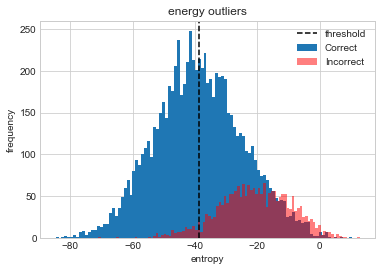

-----------------
  Exit_Name  Predictions  Test_Accuracy  RollOver_Accuracy  Threshold  Accepted  Accepted_Correct  Accepted_Ratio  Acceptance_Accuracy
0    exit_1        10000         0.7885             0.7885 -38.598537      4180              4032           0.418             0.964593
energy
metric:  energy threshold:  mean
['exit_1']
4315 inputs accepted 4214 Correct


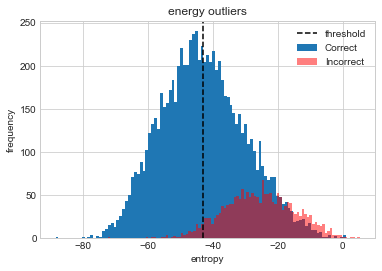

-----------------
  Exit_Name  Predictions  Test_Accuracy  RollOver_Accuracy  Threshold  Accepted  Accepted_Correct  Accepted_Ratio  Acceptance_Accuracy
0    exit_1        10000         0.8089             0.8089 -42.889851      4315              4214          0.4315             0.976593
entropy
metric:  entropy threshold:  mean
['exit_1']
7492 inputs accepted 6879 Correct


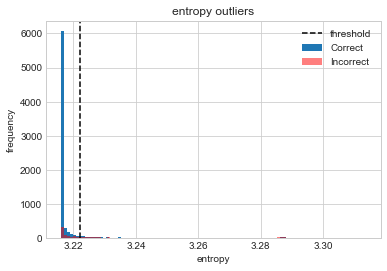

-----------------
  Exit_Name  Predictions  Test_Accuracy  RollOver_Accuracy  Threshold  Accepted  Accepted_Correct  Accepted_Ratio  Acceptance_Accuracy
0    exit_1        10000         0.8151             0.8151   3.221968      7492              6879          0.7492             0.918179
calibration
metric:  calibration threshold:  mean
['exit_1']
7630 inputs accepted 6974 Correct


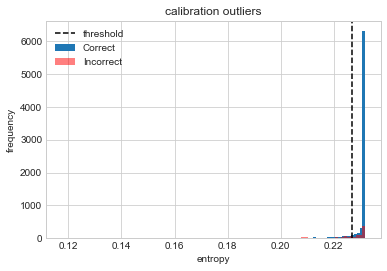

-----------------
  Exit_Name  Predictions  Test_Accuracy  RollOver_Accuracy  Threshold  Accepted  Accepted_Correct  Accepted_Ratio  Acceptance_Accuracy
0    exit_1        10000         0.8151             0.8151   0.226737      7630              6974           0.763             0.914024


In [52]:

print("energy")
evaluate.calculateBranching(output_ID_brev,threshold="mean",metrics=["energy"],main_exit_included=False,plot=True)

print("entropy")
evaluate.calculateBranching(output_ID,threshold="mean",metrics=["entropy"],main_exit_included=False,plot=True)

print("calibration")
evaluate.calculateBranching(output_ID,threshold="mean",metrics=["calibration"],main_exit_included=False,plot=True)

energy
metric:  energy threshold:  mean
['exit_1', 'exit_2', 'exit_3']
['exit_1', 'exit_2', 'exit_3']
   Exit_Name  ID_Inputs  OOD_Inputs  Test_Accuracy  Threshold  Accepted ID  Accepted OOD  Accepted_Correct  Accepted_ID_Ratio  Acceptance_Accuracy
0     exit_1      10000       10000         0.6459 -32.640465         3382           958              3123           0.779263             0.719585
1     exit_2       6618        9042         0.6843 -37.452072         1023           516               895           0.664717             0.581546
2  Main_exit       5595        8526         0.7715         NA         5595          8526              3685           0.396218             0.260959
entropy
metric:  entropy threshold:  mean
['exit_1', 'exit_2', 'exit_3']
['exit_1', 'exit_2', 'exit_3']
   Exit_Name  ID_Inputs  OOD_Inputs  Test_Accuracy Threshold  Accepted ID  Accepted OOD  Accepted_Correct  Accepted_ID_Ratio  Acceptance_Accuracy
0     exit_1      10000       10000         0.7390   0.37084

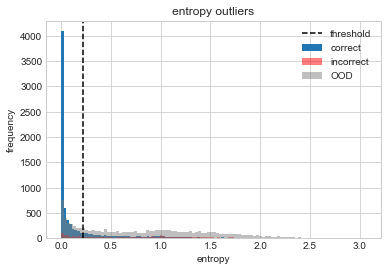

['exit_1', 'exit_2', 'exit_3']
  Exit_Name  ID_Inputs  OOD_Inputs  Test_Accuracy  Threshold  Accepted ID  Accepted OOD  Accepted_Correct  Accepted_ID_Ratio  Acceptance_Accuracy
0    exit_1      10000       10000         0.7994   0.223908         6364          2466              5943           0.720725             0.673046
metric:  energy threshold:  mean


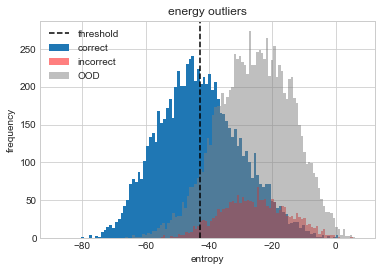

['exit_1', 'exit_2', 'exit_3']
  Exit_Name  ID_Inputs  OOD_Inputs  Test_Accuracy  Threshold  Accepted ID  Accepted OOD  Accepted_Correct  Accepted_ID_Ratio  Acceptance_Accuracy
0    exit_1      10000       10000         0.8089 -42.889851         4315           738              4214           0.853948              0.83396
Brev
metric:  entropy threshold:  PR_AUC


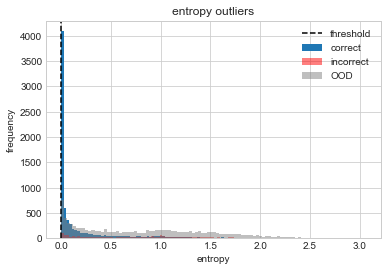

['exit_1', 'exit_2', 'exit_3']
  Exit_Name  ID_Inputs  OOD_Inputs  Test_Accuracy  Threshold  Accepted ID  Accepted OOD  Accepted_Correct  Accepted_ID_Ratio  Acceptance_Accuracy
0    exit_1      10000       10000         0.7994   0.002367         2007           109              1984           0.948488             0.937618
metric:  energy threshold:  PR_AUC


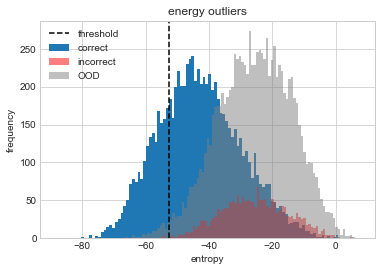

['exit_1', 'exit_2', 'exit_3']
  Exit_Name  ID_Inputs  OOD_Inputs  Test_Accuracy  Threshold  Accepted ID  Accepted OOD  Accepted_Correct  Accepted_ID_Ratio  Acceptance_Accuracy
0    exit_1      10000       10000         0.8089 -52.784325         1912           132              1901           0.935421             0.930039


In [59]:
#####################################
print("energy")
evaluate.buildCompareDistribPlot(output_ID_brev_2, output_OOD_brev_2, ["energy"], "mean",main_exit_included=True,plot=False)
print("entropy")
evaluate.buildCompareDistribPlot(output_ID_branch_CE, output_OOD_branch_CE, ["entropy"], "mean",main_exit_included=True,plot=False)
print("energy")
evaluate.buildCompareDistribPlot(output_ID_brev_2, output_OOD_brev_2, ["energy"], "PR_AUC",main_exit_included=True,plot=False)
print("entropy")
evaluate.buildCompareDistribPlot(output_ID_branch_CE, output_OOD_branch_CE, ["entropy"], "PR_AUC",main_exit_included=True,plot=False)

main_BREV_ID = output_ID_brev_2[0]
main_BREV_OOD = output_OOD_brev_2[0]


main_CE_ID = output_ID_branch_CE[0]
main_CE_OOD = output_OOD_branch_CE[0]

print("----------")
print("only the main branch")
evaluate.buildCompareDistribPlot([main_CE_ID], [main_CE_OOD], ["entropy"], "mean",main_exit_included=False,plot=True)

evaluate.buildCompareDistribPlot(output_ID_brev, output_OOD_brev, ["energy"], "mean",main_exit_included=False,plot=True)



# print("Brev2")
# evaluate.buildCompareDistribPlot([main_BREV_ID], [main_BREV_OOD], ["energy"], "mean",main_exit_included=False,plot=True)

print("Brev")
evaluate.buildCompareDistribPlot([main_CE_ID], [main_CE_OOD], ["entropy"], "PR_AUC",main_exit_included=False,plot=True)
evaluate.buildCompareDistribPlot(output_ID_brev, output_OOD_brev, ["energy"], "PR_AUC",main_exit_included=False,plot=True)

metric:  energy threshold:  mean


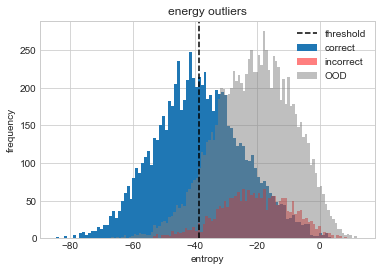

['exit_1']
  Exit_Name  ID_Inputs  OOD_Inputs  Test_Accuracy  Threshold  Accepted ID  Accepted OOD  Accepted_Correct  Accepted_ID_Ratio  Acceptance_Accuracy
0    exit_1      10000       10000         0.7885 -38.598537         4180           853              4032           0.830519             0.801113
energy
metric:  energy threshold:  mean


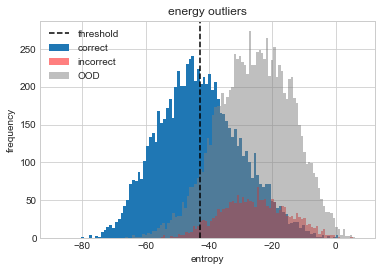

['exit_1']
  Exit_Name  ID_Inputs  OOD_Inputs  Test_Accuracy  Threshold  Accepted ID  Accepted OOD  Accepted_Correct  Accepted_ID_Ratio  Acceptance_Accuracy
0    exit_1      10000       10000         0.8089 -42.889851         4315           738              4214           0.853948              0.83396
entropy
metric:  entropy threshold:  mean


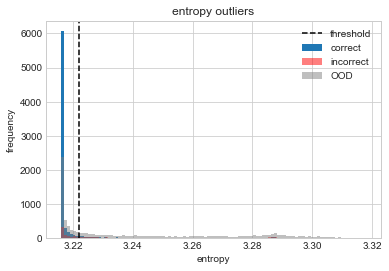

['exit_1']
  Exit_Name  ID_Inputs  OOD_Inputs  Test_Accuracy  Threshold  Accepted ID  Accepted OOD  Accepted_Correct  Accepted_ID_Ratio  Acceptance_Accuracy
0    exit_1      10000       10000         0.8151   3.221968         7492          3884              6879           0.658579             0.604694
calibration
metric:  calibration threshold:  mean


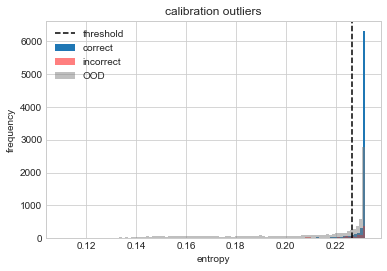

['exit_1']
  Exit_Name  ID_Inputs  OOD_Inputs  Test_Accuracy  Threshold  Accepted ID  Accepted OOD  Accepted_Correct  Accepted_ID_Ratio  Acceptance_Accuracy
0    exit_1      10000       10000         0.8151   0.226737         7630          4102              6974           0.650358             0.594443


In [51]:
evaluate.buildCompareDistribPlot(output_ID_brev_2, output_OOD_brev_2, ["energy"], "mean",main_exit_included=False,plot=True)

print("energy")
evaluate.buildCompareDistribPlot(output_ID_brev, output_OOD_brev, ["energy"], "mean",main_exit_included=False,plot=True)

print("entropy")
evaluate.buildCompareDistribPlot(output_ID, output_OOD, ["entropy"], "mean",main_exit_included=False,plot=True)


print("calibration")
evaluate.buildCompareDistribPlot(output_ID, output_OOD, ["calibration"], "mean",main_exit_included=False,plot=True)


In [ ]:
import random
seed = 42
random.seed(seed)
tf.random.set_seed(seed)
np.random.seed(seed)

trunk_loss = keras.losses.CategoricalCrossentropy(from_logits=False)
model = brevis.BranchModel(name="../models/resnet50_finetuned.hdf5", custom_objects={})
model.compile(loss=[trunk_loss], optimizer=tf.optimizers.SGD(learning_rate=0.001, momentum=0.9), preset="")
model.evaluate(test_ds)
outputs = [ [model.get_layer("branch_exit").get_output_at(0)],
            [model.get_layer("branch_exit").get_output_at(0),model.get_layer("branch_exit_1").get_output_at(0)],
            [model.get_layer("branch_exit").get_output_at(0),model.get_layer("branch_exit_1").get_output_at(0),model.get_layer("dense_2").get_output_at(0)]
          ]

# for _outputs in outputs:
    # temp_model = tf.keras.models.Model(inputs=model.inputs, outputs=_outputs)
    # Calculae FLOPS
    # print(temp_model.outputs)
flops = get_flops(model, batch_size=1)
print(f"FLOPS: {flops / 10 ** 9:.03} G")


In [ ]:
from keras_flops import get_flops

flops = get_flops(model, batch_size=1)

Instructions for updating:
Use `tf.compat.v1.graph_util.tensor_shape_from_node_def_name`


In [ ]:
print(f"FLOPS: {flops / 10 ** 9:.03} G")

FLOPS: 7.76 G


In [10]:
import random
seed = 42
random.seed(seed)
tf.random.set_seed(seed)
np.random.seed(seed)
tf.keras.backend.clear_session()
def _branch_flat(prevLayer, targets=None, teacher_sm = None, teaching_features=None):
    """ Add a new branch to a model connecting at the output of prevLayer. 
        NOTE: use the substring "branch" in all names for branch nodes. this is used as an identifier of the branching layers as opposed to the main branch layers for training
    """ 
#     branchLayer = keras.layers.Flatten(name=tf.compat.v1.get_default_graph().unique_name("branch_flatten"))(prevLayer)
#     branchLayer = keras.layers.Dense(124, activation="relu",name=tf.compat.v1.get_default_graph().unique_name("branch124"))(branchLayer)
#     branchLayer = keras.layers.Dense(64, activation="relu",name=tf.compat.v1.get_default_graph().unique_name("branch64"))(branchLayer)
#     output = keras.layers.Dense(10, name=tf.compat.v1.get_default_graph().unique_name("branch_exit"))(branchLayer)
    
    branchLayer = layers.Flatten(name=tf.compat.v1.get_default_graph().unique_name("branch_flatten"))(prevLayer)
    branchLayer = layers.Dense(1024, activation="relu",name=tf.compat.v1.get_default_graph().unique_name("branch1024"))(branchLayer)
    branchLayer = layers.Dense(512, activation="relu",name=tf.compat.v1.get_default_graph().unique_name("branch512"))(branchLayer)
    # output = branch.CrossEntropyEndpoint(targets.shape[-1], name=tf.compat.v1.get_default_graph().unique_name("branch_softmax"))(branchLayer, targets)
    output = keras.layers.Dense(10, name=tf.compat.v1.get_default_graph().unique_name("branch_exit"))(branchLayer)
    output = (layers.Softmax(name=tf.compat.v1.get_default_graph().unique_name("branch_softmax"))(output))
    return output

def _branch_conv1(prevLayer, targets=None, teacher_sm = None, teaching_features=None):
    """ Add a new branch to a model connecting at the output of prevLayer. 
        NOTE: use the substring "branch" in all names for branch nodes. this is used as an identifier of the branching layers as opposed to the main branch layers for training
    """ 
#     branchLayer = keras.layers.Flatten(name=tf.compat.v1.get_default_graph().unique_name("branch_flatten"))(prevLayer)
#     branchLayer = keras.layers.Dense(124, activation="relu",name=tf.compat.v1.get_default_graph().unique_name("branch124"))(branchLayer)
#     branchLayer = keras.layers.Dense(64, activation="relu",name=tf.compat.v1.get_default_graph().unique_name("branch64"))(branchLayer)
#     output = keras.layers.Dense(10, name=tf.compat.v1.get_default_graph().unique_name("branch_exit"))(branchLayer)
    branchLayer = keras.layers.Conv2D(filters=64, kernel_size=(1,1), strides=(1,1), activation='relu',name=tf.compat.v1.get_default_graph().unique_name("branch_conv2d"), input_shape=(prevLayer.shape))(prevLayer)
    branchLayer = keras.layers.BatchNormalization(name=tf.compat.v1.get_default_graph().unique_name("branch_batchnorm"))(branchLayer)  
    branchLayer = keras.layers.Conv2D(filters=64, kernel_size=(1,1), strides=(1,1), activation='relu',name=tf.compat.v1.get_default_graph().unique_name("branch_conv2d"), input_shape=(branchLayer.shape))(branchLayer)
    branchLayer = keras.layers.BatchNormalization(name=tf.compat.v1.get_default_graph().unique_name("branch_batchnorm"))(branchLayer)  
    # branchLayer = keras.layers.MaxPool2D(pool_size=(3,3), strides=(2,2),name=tf.compat.v1.get_default_graph().unique_name("branch_maxpool"))(branchLayer)
    # branchLayer = keras.layers.Dropout(0.2,name=tf.compat.v1.get_default_graph().unique_name("branch_dropout"))(branchLayer)
    branchLayer = keras.layers.Conv2D(filters=256, kernel_size=(1,1), strides=(2,2), activation='relu',name=tf.compat.v1.get_default_graph().unique_name("branch_conv2d"), input_shape=(branchLayer.shape))(branchLayer)
    branchLayer = keras.layers.BatchNormalization(name=tf.compat.v1.get_default_graph().unique_name("branch_batchnorm"))(branchLayer)
    # branchLayer = keras.layers.MaxPool2D(pool_size=(3,3), strides=(2,2),name=tf.compat.v1.get_default_graph().unique_name("branch_maxpool"))(branchLayer)
    # branchLayer = keras.layers.Dropout(0.2,name=tf.compat.v1.get_default_graph().unique_name("branch_dropout"))(branchLayer)
    branchLayer = layers.Flatten(name=tf.compat.v1.get_default_graph().unique_name("branch_flatten"))(branchLayer)
    branchLayer = layers.Dense(1024,activation='relu',name=tf.compat.v1.get_default_graph().unique_name("branch_dense"))(branchLayer)
    branchLayer = keras.layers.Dropout(0.2,name=tf.compat.v1.get_default_graph().unique_name("branch_dropout"))(branchLayer)
    branchLayer = layers.Dense(512,activation='relu',name=tf.compat.v1.get_default_graph().unique_name("branch_dense"))(branchLayer)
    output = keras.layers.Dense(10, name=tf.compat.v1.get_default_graph().unique_name("branch_exit"))(branchLayer)
    # output = (layers.Softmax(name=tf.compat.v1.get_default_graph().unique_name("branch_softmax"))(output))
    return output

def _branch_conv2(prevLayer, targets=None, teacher_sm = None, teaching_features=None):
    """ Add a new branch to a model connecting at the output of prevLayer. 
        NOTE: use the substring "branch" in all names for branch nodes. this is used as an identifier of the branching layers as opposed to the main branch layers for training
    """ 
#     branchLayer = keras.layers.Flatten(name=tf.compat.v1.get_default_graph().unique_name("branch_flatten"))(prevLayer)
#     branchLayer = keras.layers.Dense(124, activation="relu",name=tf.compat.v1.get_default_graph().unique_name("branch124"))(branchLayer)
#     branchLayer = keras.layers.Dense(64, activation="relu",name=tf.compat.v1.get_default_graph().unique_name("branch64"))(branchLayer)
#     output = keras.layers.Dense(10, name=tf.compat.v1.get_default_graph().unique_name("branch_exit"))(branchLayer)
    branchLayer = keras.layers.Conv2D(filters=128, kernel_size=(1,1), strides=(1,1), activation='relu',name=tf.compat.v1.get_default_graph().unique_name("branch_conv2d"), input_shape=(prevLayer.shape))(prevLayer)
    branchLayer = keras.layers.BatchNormalization(name=tf.compat.v1.get_default_graph().unique_name("branch_batchnorm"))(branchLayer)  
    branchLayer = keras.layers.Conv2D(filters=128, kernel_size=(1,1), strides=(1,1), activation='relu',name=tf.compat.v1.get_default_graph().unique_name("branch_conv2d"), input_shape=(branchLayer.shape))(branchLayer)
    branchLayer = keras.layers.BatchNormalization(name=tf.compat.v1.get_default_graph().unique_name("branch_batchnorm"))(branchLayer)  
    branchLayer = keras.layers.MaxPool2D(pool_size=(3,3), strides=(2,2),name=tf.compat.v1.get_default_graph().unique_name("branch_maxpool"))(branchLayer)
    # branchLayer = keras.layers.Dropout(0.2,name=tf.compat.v1.get_default_graph().unique_name("branch_dropout"))(branchLayer)
    branchLayer = keras.layers.Conv2D(filters=512, kernel_size=(1,1), strides=(1,1), activation='relu',name=tf.compat.v1.get_default_graph().unique_name("branch_conv2d"), input_shape=(branchLayer.shape))(branchLayer)
    branchLayer = keras.layers.BatchNormalization(name=tf.compat.v1.get_default_graph().unique_name("branch_batchnorm"))(branchLayer)
    branchLayer = keras.layers.MaxPool2D(pool_size=(3,3), strides=(2,2),name=tf.compat.v1.get_default_graph().unique_name("branch_maxpool"))(branchLayer)
    # branchLayer = keras.layers.Dropout(0.2,name=tf.compat.v1.get_default_graph().unique_name("branch_dropout"))(branchLayer)
    branchLayer = layers.Flatten(name=tf.compat.v1.get_default_graph().unique_name("branch_flatten"))(branchLayer)
    branchLayer = layers.Dense(1024,activation='relu',name=tf.compat.v1.get_default_graph().unique_name("branch_dense"))(branchLayer)
    branchLayer = keras.layers.Dropout(0.2,name=tf.compat.v1.get_default_graph().unique_name("branch_dropout"))(branchLayer)
    branchLayer = layers.Dense(512,activation='relu',name=tf.compat.v1.get_default_graph().unique_name("branch_dense"))(branchLayer)
    output = keras.layers.Dense(10, name=tf.compat.v1.get_default_graph().unique_name("branch_exit"))(branchLayer)
    # output = (layers.Softmax(name=tf.compat.v1.get_default_graph().unique_name("branch_softmax"))(output))
    return output
lambda_callback = lambda_update(1000,0,max_t = 0.01)
branch_loss = brevisEnergy(lambda_callback)
# branch_loss = keras.losses.CategoricalCrossentropy(from_logits=True)
trunk_loss = keras.losses.CategoricalCrossentropy(from_logits=True)
# loss = kl_loss(lambda_callback)
earlyStop = tf.keras.callbacks.EarlyStopping(monitor="val_accuracy",patience=4,restore_best_weights=True)


base_model = tf.keras.applications.resnet50.ResNet50(input_shape=(32, 32, 3),
     weights='imagenet',include_top=False)
x = base_model.output
x = tf.keras.layers.GlobalAveragePooling2D()(x)
x = tf.keras.layers.Flatten()(x)
x = tf.keras.layers.Dense(1024, activation="relu")(x)
x = tf.keras.layers.Dense(512, activation="relu")(x)
x = tf.keras.layers.Dense(10, name="classification")(x)

resnet = tf.keras.models.Model(inputs=base_model.input, outputs=x)


# base_model.compile(optimizer='adam', 
#                 loss=trunk_loss,
#                 metrics = ['accuracy'])

# model.summary()
# train_ds, test_ds, validation_ds = prepareDataset(32)
# EPOCHS = 3
# checkpoint = tf.keras.callbacks.ModelCheckpoint("models/resnet50_finetuned.hdf5", monitor='val_loss', verbose=1, mode='max')
# history = base_model.fit(train_ds, epochs=1, validation_data = validation_ds, batch_size=64,callbacks=[])



model = brevis.BranchModel(model=resnet, custom_objects={})
# model.add_branches([_branch_flat,_branch_flat],
#                           ["conv2_block1_out","conv2_block3_out",
#                             # "dense"
#                           ],
#                           target_input=False,loop=False,num_outputs=10)

model.add_branches([_branch_conv1,_branch_conv2],
                          ["conv2_block1_out","conv2_block3_out",
                            # "dense"
                          ],
                          target_input=False,loop=False,num_outputs=10)
model.compile(loss = [trunk_loss,branch_loss,branch_loss], optimizer=tf.optimizers.SGD(learning_rate=0.001, momentum=0.9),metrics=['accuracy'])
# model.compile(loss=[branch_loss], optimizer=tf.optimizers.SGD(learning_rate=0.001, momentum=0.9), preset="", metrics=['accuracy'])
# model.fit(train_ds, epochs = 1, validation_data=validation_ds, transfer=False,callbacks=[lambda_callback])


Matching Branchpoint by id number
Matching Branchpoint by name
add Branch to branch point  conv2_block1_out
add Branch to branch point  conv2_block3_out
KerasTensor(type_spec=TensorSpec(shape=(None, 32, 32, 3), dtype=tf.float32, name='input_1'), name='input_1', description="created by layer 'input_1'")
[<KerasTensor: shape=(None, 10) dtype=float32 (created by layer 'classification')>, <KerasTensor: shape=(None, 10) dtype=float32 (created by layer 'branch_exit')>, <KerasTensor: shape=(None, 10) dtype=float32 (created by layer 'branch_exit_1')>]
branch added <brevis.core_v2.BranchModel object at 0x000002673EB10108>

preset: Other


In [11]:
model.fit(train_ds, epochs = 10,validation_data=validation_ds, transfer=False,callbacks=[lambda_callback])

Setting Main Layers  and branch layers training to true
annealing coef updated to: 0
Epoch 1/10
1407/1407 [==============================] - 115s 73ms/step - loss: 3.0899 - classification_loss: 1.2151 - branch_exit_loss: 0.9392 - branch_exit_1_loss: 0.9355 - classification_accuracy: 0.5828 - branch_exit_accuracy: 0.1591 - branch_exit_1_accuracy: 0.1729 - val_loss: 2.7658 - val_classification_loss: 0.9152 - val_branch_exit_loss: 0.9320 - val_branch_exit_1_loss: 0.9185 - val_classification_accuracy: 0.6896 - val_branch_exit_accuracy: 0.2096 - val_branch_exit_1_accuracy: 0.2192
annealing coef updated to: 0.001
Epoch 2/10
1407/1407 [==============================] - 100s 71ms/step - loss: 2.5908 - classification_loss: 0.7500 - branch_exit_loss: 0.9310 - branch_exit_1_loss: 0.9098 - classification_accuracy: 0.7446 - branch_exit_accuracy: 0.2304 - branch_exit_1_accuracy: 0.2855 - val_loss: 2.4259 - val_classification_loss: 0.6796 - val_branch_exit_loss: 0.9002 - val_branch_exit_1_loss: 0.846

In [13]:
model.evaluate(test_ds)
output_ID_brev_2= evaluate.getPredictions_Energy(model, test_ds,stopping_point=None)
for i in output_ID_brev_2:
    i['outlier']=0
output_OOD_brev_2 = evaluate.getPredictions_Energy(model, test_ds100,stopping_point=None)
for i in output_OOD_brev_2:
    i['correct']=0
    i['outlier']=1

outputs 3


In [18]:
import random
seed = 42
random.seed(seed)
tf.random.set_seed(seed)
np.random.seed(seed)
tf.keras.backend.clear_session()
def _branch_flat(prevLayer, targets=None, teacher_sm = None, teaching_features=None):
    """ Add a new branch to a model connecting at the output of prevLayer. 
        NOTE: use the substring "branch" in all names for branch nodes. this is used as an identifier of the branching layers as opposed to the main branch layers for training
    """ 
#     branchLayer = keras.layers.Flatten(name=tf.compat.v1.get_default_graph().unique_name("branch_flatten"))(prevLayer)
#     branchLayer = keras.layers.Dense(124, activation="relu",name=tf.compat.v1.get_default_graph().unique_name("branch124"))(branchLayer)
#     branchLayer = keras.layers.Dense(64, activation="relu",name=tf.compat.v1.get_default_graph().unique_name("branch64"))(branchLayer)
#     output = keras.layers.Dense(10, name=tf.compat.v1.get_default_graph().unique_name("branch_exit"))(branchLayer)
    
    branchLayer = layers.Flatten(name=tf.compat.v1.get_default_graph().unique_name("branch_flatten"))(prevLayer)
    branchLayer = layers.Dense(1024, activation="relu",name=tf.compat.v1.get_default_graph().unique_name("branch1024"))(branchLayer)
    branchLayer = layers.Dense(512, activation="relu",name=tf.compat.v1.get_default_graph().unique_name("branch512"))(branchLayer)
    # output = branch.CrossEntropyEndpoint(targets.shape[-1], name=tf.compat.v1.get_default_graph().unique_name("branch_softmax"))(branchLayer, targets)
    output = keras.layers.Dense(10, name=tf.compat.v1.get_default_graph().unique_name("branch_exit"))(branchLayer)
    output = (layers.Softmax(name=tf.compat.v1.get_default_graph().unique_name("branch_softmax"))(output))
    return output

def _branch_conv1(prevLayer, targets=None, teacher_sm = None, teaching_features=None):
    """ Add a new branch to a model connecting at the output of prevLayer. 
        NOTE: use the substring "branch" in all names for branch nodes. this is used as an identifier of the branching layers as opposed to the main branch layers for training
    """ 
#     branchLayer = keras.layers.Flatten(name=tf.compat.v1.get_default_graph().unique_name("branch_flatten"))(prevLayer)
#     branchLayer = keras.layers.Dense(124, activation="relu",name=tf.compat.v1.get_default_graph().unique_name("branch124"))(branchLayer)
#     branchLayer = keras.layers.Dense(64, activation="relu",name=tf.compat.v1.get_default_graph().unique_name("branch64"))(branchLayer)
#     output = keras.layers.Dense(10, name=tf.compat.v1.get_default_graph().unique_name("branch_exit"))(branchLayer)
    branchLayer = keras.layers.Conv2D(filters=64, kernel_size=(1,1), strides=(1,1), activation='relu',name=tf.compat.v1.get_default_graph().unique_name("branch_conv2d"), input_shape=(prevLayer.shape))(prevLayer)
    branchLayer = keras.layers.BatchNormalization(name=tf.compat.v1.get_default_graph().unique_name("branch_batchnorm"))(branchLayer)  
    branchLayer = keras.layers.Conv2D(filters=64, kernel_size=(1,1), strides=(1,1), activation='relu',name=tf.compat.v1.get_default_graph().unique_name("branch_conv2d"), input_shape=(branchLayer.shape))(branchLayer)
    branchLayer = keras.layers.BatchNormalization(name=tf.compat.v1.get_default_graph().unique_name("branch_batchnorm"))(branchLayer)  
    # branchLayer = keras.layers.MaxPool2D(pool_size=(3,3), strides=(2,2),name=tf.compat.v1.get_default_graph().unique_name("branch_maxpool"))(branchLayer)
    # branchLayer = keras.layers.Dropout(0.2,name=tf.compat.v1.get_default_graph().unique_name("branch_dropout"))(branchLayer)
    branchLayer = keras.layers.Conv2D(filters=256, kernel_size=(1,1), strides=(2,2), activation='relu',name=tf.compat.v1.get_default_graph().unique_name("branch_conv2d"), input_shape=(branchLayer.shape))(branchLayer)
    branchLayer = keras.layers.BatchNormalization(name=tf.compat.v1.get_default_graph().unique_name("branch_batchnorm"))(branchLayer)
    # branchLayer = keras.layers.MaxPool2D(pool_size=(3,3), strides=(2,2),name=tf.compat.v1.get_default_graph().unique_name("branch_maxpool"))(branchLayer)
    # branchLayer = keras.layers.Dropout(0.2,name=tf.compat.v1.get_default_graph().unique_name("branch_dropout"))(branchLayer)
    branchLayer = layers.Flatten(name=tf.compat.v1.get_default_graph().unique_name("branch_flatten"))(branchLayer)
    branchLayer = layers.Dense(1024,activation='relu',name=tf.compat.v1.get_default_graph().unique_name("branch_dense"))(branchLayer)
    branchLayer = keras.layers.Dropout(0.2,name=tf.compat.v1.get_default_graph().unique_name("branch_dropout"))(branchLayer)
    branchLayer = layers.Dense(512,activation='relu',name=tf.compat.v1.get_default_graph().unique_name("branch_dense"))(branchLayer)
    output = keras.layers.Dense(10, name=tf.compat.v1.get_default_graph().unique_name("branch_exit"))(branchLayer)
    # output = (layers.Softmax(name=tf.compat.v1.get_default_graph().unique_name("branch_softmax"))(output))
    return output

def _branch_conv2(prevLayer, targets=None, teacher_sm = None, teaching_features=None):
    """ Add a new branch to a model connecting at the output of prevLayer. 
        NOTE: use the substring "branch" in all names for branch nodes. this is used as an identifier of the branching layers as opposed to the main branch layers for training
    """ 
#     branchLayer = keras.layers.Flatten(name=tf.compat.v1.get_default_graph().unique_name("branch_flatten"))(prevLayer)
#     branchLayer = keras.layers.Dense(124, activation="relu",name=tf.compat.v1.get_default_graph().unique_name("branch124"))(branchLayer)
#     branchLayer = keras.layers.Dense(64, activation="relu",name=tf.compat.v1.get_default_graph().unique_name("branch64"))(branchLayer)
#     output = keras.layers.Dense(10, name=tf.compat.v1.get_default_graph().unique_name("branch_exit"))(branchLayer)
    branchLayer = keras.layers.Conv2D(filters=128, kernel_size=(1,1), strides=(1,1), activation='relu',name=tf.compat.v1.get_default_graph().unique_name("branch_conv2d"), input_shape=(prevLayer.shape))(prevLayer)
    branchLayer = keras.layers.BatchNormalization(name=tf.compat.v1.get_default_graph().unique_name("branch_batchnorm"))(branchLayer)  
    branchLayer = keras.layers.Conv2D(filters=128, kernel_size=(1,1), strides=(1,1), activation='relu',name=tf.compat.v1.get_default_graph().unique_name("branch_conv2d"), input_shape=(branchLayer.shape))(branchLayer)
    branchLayer = keras.layers.BatchNormalization(name=tf.compat.v1.get_default_graph().unique_name("branch_batchnorm"))(branchLayer)  
    branchLayer = keras.layers.MaxPool2D(pool_size=(3,3), strides=(2,2),name=tf.compat.v1.get_default_graph().unique_name("branch_maxpool"))(branchLayer)
    # branchLayer = keras.layers.Dropout(0.2,name=tf.compat.v1.get_default_graph().unique_name("branch_dropout"))(branchLayer)
    branchLayer = keras.layers.Conv2D(filters=512, kernel_size=(1,1), strides=(1,1), activation='relu',name=tf.compat.v1.get_default_graph().unique_name("branch_conv2d"), input_shape=(branchLayer.shape))(branchLayer)
    branchLayer = keras.layers.BatchNormalization(name=tf.compat.v1.get_default_graph().unique_name("branch_batchnorm"))(branchLayer)
    branchLayer = keras.layers.MaxPool2D(pool_size=(3,3), strides=(2,2),name=tf.compat.v1.get_default_graph().unique_name("branch_maxpool"))(branchLayer)
    # branchLayer = keras.layers.Dropout(0.2,name=tf.compat.v1.get_default_graph().unique_name("branch_dropout"))(branchLayer)
    branchLayer = layers.Flatten(name=tf.compat.v1.get_default_graph().unique_name("branch_flatten"))(branchLayer)
    branchLayer = layers.Dense(1024,activation='relu',name=tf.compat.v1.get_default_graph().unique_name("branch_dense"))(branchLayer)
    branchLayer = keras.layers.Dropout(0.2,name=tf.compat.v1.get_default_graph().unique_name("branch_dropout"))(branchLayer)
    branchLayer = layers.Dense(512,activation='relu',name=tf.compat.v1.get_default_graph().unique_name("branch_dense"))(branchLayer)
    output = keras.layers.Dense(10, name=tf.compat.v1.get_default_graph().unique_name("branch_exit"))(branchLayer)
    # output = (layers.Softmax(name=tf.compat.v1.get_default_graph().unique_name("branch_softmax"))(output))
    return output
lambda_callback = lambda_update(1000,0,max_t = 0.01)
# branch_loss = brevisEnergy(lambda_callback)
branch_CR_loss = keras.losses.CategoricalCrossentropy(from_logits=True)
trunk_loss = keras.losses.CategoricalCrossentropy(from_logits=True)
# loss = kl_loss(lambda_callback)
earlyStop = tf.keras.callbacks.EarlyStopping(monitor="val_accuracy",patience=4,restore_best_weights=True)


base_model = tf.keras.applications.resnet50.ResNet50(input_shape=(32, 32, 3),
     weights='imagenet',include_top=False)
x = base_model.output
x = tf.keras.layers.GlobalAveragePooling2D()(x)
x = tf.keras.layers.Flatten()(x)
x = tf.keras.layers.Dense(1024, activation="relu")(x)
x = tf.keras.layers.Dense(512, activation="relu")(x)
x = tf.keras.layers.Dense(10, name="classification")(x)

resnet = tf.keras.models.Model(inputs=base_model.input, outputs=x)


# base_model.compile(optimizer='adam', 
#                 loss=trunk_loss,
#                 metrics = ['accuracy'])

# model.summary()
# train_ds, test_ds, validation_ds = prepareDataset(32)
# EPOCHS = 3
# checkpoint = tf.keras.callbacks.ModelCheckpoint("models/resnet50_finetuned.hdf5", monitor='val_loss', verbose=1, mode='max')
# history = base_model.fit(train_ds, epochs=1, validation_data = validation_ds, batch_size=64,callbacks=[])



model_CE = brevis.BranchModel(model=resnet, custom_objects={})
# model.add_branches([_branch_flat,_branch_flat],
#                           ["conv2_block1_out","conv2_block3_out",
#                             # "dense"
#                           ],
#                           target_input=False,loop=False,num_outputs=10)

model_CE.add_branches([_branch_conv1,_branch_conv2],
                          ["conv2_block1_out","conv2_block3_out",
                            # "dense"
                          ],
                          target_input=False,loop=False,num_outputs=10)
model_CE.compile(loss = trunk_loss, optimizer=tf.optimizers.SGD(learning_rate=0.001, momentum=0.9),metrics=['accuracy'])
# model.compile(loss=[branch_loss], optimizer=tf.optimizers.SGD(learning_rate=0.001, momentum=0.9), preset="", metrics=['accuracy'])
model_CE.fit(train_ds, epochs = 10, validation_data=validation_ds, transfer=False,callbacks=[lambda_callback])


Matching Branchpoint by id number
Matching Branchpoint by name
add Branch to branch point  conv2_block1_out
add Branch to branch point  conv2_block3_out
KerasTensor(type_spec=TensorSpec(shape=(None, 32, 32, 3), dtype=tf.float32, name='input_1'), name='input_1', description="created by layer 'input_1'")
[<KerasTensor: shape=(None, 10) dtype=float32 (created by layer 'classification')>, <KerasTensor: shape=(None, 10) dtype=float32 (created by layer 'branch_exit')>, <KerasTensor: shape=(None, 10) dtype=float32 (created by layer 'branch_exit_1')>]
branch added <brevis.core_v2.BranchModel object at 0x000002679C54E0C8>

preset: Other
Setting Main Layers  and branch layers training to true
annealing coef updated to: 0
Epoch 1/10
1407/1407 [==============================] - 88s 59ms/step - loss: 3.7572 - classification_loss: 1.2518 - branch_exit_loss: 1.2262 - branch_exit_1_loss: 1.2792 - classification_accuracy: 0.5664 - branch_exit_accuracy: 0.5656 - branch_exit_1_accuracy: 0.5462 - val_loss

In [19]:
output_ID_branch_CE= evaluate.getPredictions_Energy(model_CE, test_ds,stopping_point=None)
for i in output_ID_branch_CE:
    i['outlier']=0
output_OOD_branch_CE = evaluate.getPredictions_Energy(model_CE, test_ds100,stopping_point=None)
for i in output_OOD_branch_CE:
    i['correct']=0
    i['outlier']=1
    

outputs 3
outputs 3n: 312 of 313


In [ ]:
model.evaluate(test_ds)
lambda_callback = lambda_update(1000,lambda_t=5,max_t = 0.01)
model.fit(train_ds, epochs = 5, validation_data=validation_ds, transfer=False,callbacks=[lambda_callback])

313/313 [==============================] - 7s 21ms/step - loss: 2.2825 - classification_loss: 0.9932 - branch_exit_loss: 0.6975 - branch_exit_1_loss: 0.5917 - classification_accuracy: 0.8029 - branch_exit_accuracy: 0.5674 - branch_exit_1_accuracy: 0.6372
Setting Main Layers  and branch layers training to true
annealing coef updated to: 0.005
Epoch 1/5
1407/1407 [==============================] - 98s 70ms/step - loss: 1.1941 - classification_loss: 0.0383 - branch_exit_loss: 0.6348 - branch_exit_1_loss: 0.5211 - classification_accuracy: 0.9870 - branch_exit_accuracy: 0.6106 - branch_exit_1_accuracy: 0.6925 - val_loss: 1.1616 - val_classification_loss: 0.0531 - val_branch_exit_loss: 0.5978 - val_branch_exit_1_loss: 0.5106 - val_classification_accuracy: 0.9812 - val_branch_exit_accuracy: 0.6354 - val_branch_exit_1_accuracy: 0.7130
annealing coef updated to: 0.006
Epoch 2/5
1407/1407 [==============================] - 98s 70ms/step - loss: 1.1043 - classification_loss: 0.0370 - branch_exit_

In [ ]:
lambda_callback = lambda_update(1000,lambda_t=5,max_t = 0.01)
model.fit(train_ds, epochs = 5, validation_data=validation_ds, transfer=False,callbacks=[lambda_callback])

Setting Main Layers  and branch layers training to true
annealing coef updated to: 0.005
Epoch 1/5
1407/1407 [==============================] - 100s 71ms/step - loss: 0.7635 - classification_loss: 0.0275 - branch_exit_loss: 0.4153 - branch_exit_1_loss: 0.3207 - classification_accuracy: 0.9912 - branch_exit_accuracy: 0.7094 - branch_exit_1_accuracy: 0.7846 - val_loss: 0.8855 - val_classification_loss: 0.0978 - val_branch_exit_loss: 0.4484 - val_branch_exit_1_loss: 0.3394 - val_classification_accuracy: 0.9662 - val_branch_exit_accuracy: 0.6798 - val_branch_exit_1_accuracy: 0.7642
annealing coef updated to: 0.006
Epoch 2/5
1407/1407 [==============================] - 100s 71ms/step - loss: 0.7185 - classification_loss: 0.0340 - branch_exit_loss: 0.3892 - branch_exit_1_loss: 0.2953 - classification_accuracy: 0.9879 - branch_exit_accuracy: 0.7270 - branch_exit_1_accuracy: 0.8000 - val_loss: 0.9852 - val_classification_loss: 0.1900 - val_branch_exit_loss: 0.4506 - val_branch_exit_1_loss: 0.3

In [117]:
model.save('./models/journal_models/resnet_B_Bconv3_10.h5')

In [10]:
model = tf.keras.models.load_model('./models/journal_models/resnet_Brev_Bflat.h5',custom_objects={"BranchModel":brevis.BranchModel,"brevisEnergy":brevisEnergy})
lambda_callback = lambda_update(1000,0,max_t = 0.01)
loss_fn = brevisEnergy(lambda_callback)
# loss_fn = brevis.utils.evidence_crossentropy(num_outputs=10)
trunk_loss = keras.losses.CategoricalCrossentropy(from_logits=False)
model.compile(loss = [trunk_loss,loss_fn,loss_fn], optimizer=tf.optimizers.SGD(learning_rate=0.001, momentum=0.9))



preset: Other

preset: Other


In [16]:
# outputs = [ [model.get_layer("branch_exit").get_output_at(0)],
#             [model.get_layer("branch_exit").get_output_at(0),model.get_layer("branch_exit_1").get_output_at(0)],
#             [model.get_layer("branch_exit").get_output_at(0),model.get_layer("branch_exit_1").get_output_at(0),model.get_layer("dense_2").get_output_at(0)]
#           ]
# from keras_flops import get_flops    
# for _outputs in outputs:
#     temp_model = tf.keras.models.Model(inputs=model.inputs, outputs=_outputs)
#     # Calculae FLOPS
#     print(temp_model.outputs)
#     flops = get_flops(temp_model, batch_size=1)
#     print(f"FLOPS: {flops / 10 ** 9:.03} G")
    
    

[<KerasTensor: shape=(None, 10) dtype=float32 (created by layer 'branch_exit')>]
Instructions for updating:
Use `tf.compat.v1.graph_util.tensor_shape_from_node_def_name`
FLOPS: 0.23 G
[<KerasTensor: shape=(None, 10) dtype=float32 (created by layer 'branch_exit')>, <KerasTensor: shape=(None, 10) dtype=float32 (created by layer 'branch_exit_1')>]
FLOPS: 1.14 G
[<KerasTensor: shape=(None, 10) dtype=float32 (created by layer 'branch_exit')>, <KerasTensor: shape=(None, 10) dtype=float32 (created by layer 'branch_exit_1')>, <KerasTensor: shape=(None, 10) dtype=float32 (created by layer 'dense_2')>]
FLOPS: 1.63 G


In [13]:
model.save("./models/journal_models/alexnet_CE_branch_f_5.h5",save_traces=False,include_optimizer=True)

In [15]:

model.evaluate(test_ds)

313/313 [==============================] - 11s 34ms/step - loss: 2.7760 - dense_2_loss: 0.6712 - branch_softmax_loss: 1.2198 - branch_softmax_1_loss: 0.8850 - dense_2_accuracy: 0.8155 - branch_softmax_accuracy: 0.5994 - branch_softmax_1_accuracy: 0.7132


[2.775993585586548,
 0.6712445020675659,
 1.219782829284668,
 0.884965717792511,
 0.815500020980835,
 0.599399983882904,
 0.7131999731063843]

In [12]:
# model.save("./models/journal_models/alexnet_Brev_branch_f_1.h5",save_traces=False,include_optimizer=False)
# model = keras.models.load_model("./models/journal_models/alexnet_Brev_branch_f_1.h5",custom_objects={"BranchModel":brevis.BranchModel,"brevisEnergy":brevisEnergy})

In [7]:
#### next model
import random
seed = 42
random.seed(seed)
tf.random.set_seed(seed)
np.random.seed(seed)
tf.keras.backend.clear_session()
def _branch_conv1(prevLayer, targets=None, teacher_sm = None, teaching_features=None):
    """ Add a new branch to a model connecting at the output of prevLayer. 
        NOTE: use the substring "branch" in all names for branch nodes. this is used as an identifier of the branching layers as opposed to the main branch layers for training
    """ 
#     branchLayer = keras.layers.Flatten(name=tf.compat.v1.get_default_graph().unique_name("branch_flatten"))(prevLayer)
#     branchLayer = keras.layers.Dense(124, activation="relu",name=tf.compat.v1.get_default_graph().unique_name("branch124"))(branchLayer)
#     branchLayer = keras.layers.Dense(64, activation="relu",name=tf.compat.v1.get_default_graph().unique_name("branch64"))(branchLayer)
#     output = keras.layers.Dense(10, name=tf.compat.v1.get_default_graph().unique_name("branch_exit"))(branchLayer)
    branchLayer = keras.layers.Conv2D(filters=64, kernel_size=(1,1), strides=(1,1), activation='relu',name=tf.compat.v1.get_default_graph().unique_name("branch_conv2d"), input_shape=(prevLayer.shape))(prevLayer)
    branchLayer = keras.layers.BatchNormalization(name=tf.compat.v1.get_default_graph().unique_name("branch_batchnorm"))(branchLayer)
    branchLayer = keras.layers.MaxPool2D(pool_size=(3,3), strides=(2,2),name=tf.compat.v1.get_default_graph().unique_name("branch_maxpool"))(branchLayer)
    # branchLayer = keras.layers.Dropout(0.2,name=tf.compat.v1.get_default_graph().unique_name("branch_dropout"))(branchLayer)
    branchLayer = keras.layers.Conv2D(filters=32, kernel_size=(1,1), strides=(1,1), activation='relu',name=tf.compat.v1.get_default_graph().unique_name("branch_conv2d"), input_shape=(branchLayer.shape))(branchLayer)
    branchLayer = keras.layers.BatchNormalization(name=tf.compat.v1.get_default_graph().unique_name("branch_batchnorm"))(branchLayer)
    branchLayer = keras.layers.MaxPool2D(pool_size=(3,3), strides=(2,2),name=tf.compat.v1.get_default_graph().unique_name("branch_maxpool"))(branchLayer)
    # branchLayer = keras.layers.Dropout(0.2,name=tf.compat.v1.get_default_graph().unique_name("branch_dropout"))(branchLayer)
    branchLayer = layers.Flatten(name=tf.compat.v1.get_default_graph().unique_name("branch_flatten"))(branchLayer)
    branchLayer = layers.Dense(512,name=tf.compat.v1.get_default_graph().unique_name("branch_4096"))(branchLayer)
    branchLayer = keras.layers.Dropout(0.2,name=tf.compat.v1.get_default_graph().unique_name("branch_dropout"))(branchLayer)
    output = keras.layers.Dense(10, name=tf.compat.v1.get_default_graph().unique_name("branch_exit"))(branchLayer)
    # output = (layers.Softmax(name=tf.compat.v1.get_default_graph().unique_name("branch_softmax"))(branchLayer))
    return output

def _branch_conv2(prevLayer, targets=None, teacher_sm = None, teaching_features=None):
    """ Add a new branch to a model connecting at the output of prevLayer. 
        NOTE: use the substring "branch" in all names for branch nodes. this is used as an identifier of the branching layers as opposed to the main branch layers for training
    """ 
#     branchLayer = keras.layers.Flatten(name=tf.compat.v1.get_default_graph().unique_name("branch_flatten"))(prevLayer)
#     branchLayer = keras.layers.Dense(124, activation="relu",name=tf.compat.v1.get_default_graph().unique_name("branch124"))(branchLayer)
#     branchLayer = keras.layers.Dense(64, activation="relu",name=tf.compat.v1.get_default_graph().unique_name("branch64"))(branchLayer)
#     output = keras.layers.Dense(10, name=tf.compat.v1.get_default_graph().unique_name("branch_exit"))(branchLayer)
    branchLayer = keras.layers.Conv2D(filters=96, kernel_size=(1,1), strides=(1,1), activation='relu',name=tf.compat.v1.get_default_graph().unique_name("branch_conv2d"), input_shape=(prevLayer.shape))(prevLayer)
    branchLayer = keras.layers.BatchNormalization(name=tf.compat.v1.get_default_graph().unique_name("branch_batchnorm"))(branchLayer)
    branchLayer = keras.layers.MaxPool2D(pool_size=(3,3), strides=(2,2),name=tf.compat.v1.get_default_graph().unique_name("branch_maxpool"))(branchLayer)
    # branchLayer = keras.layers.Dropout(0.2,name=tf.compat.v1.get_default_graph().unique_name("branch_dropout"))(branchLayer)
    branchLayer = layers.Flatten(name=tf.compat.v1.get_default_graph().unique_name("branch_flatten"))(branchLayer)
    branchLayer = layers.Dense(128,name=tf.compat.v1.get_default_graph().unique_name("branch_4096"))(branchLayer)
    branchLayer = keras.layers.Dropout(0.2,name=tf.compat.v1.get_default_graph().unique_name("branch_dropout"))(branchLayer)
    output = keras.layers.Dense(10, name=tf.compat.v1.get_default_graph().unique_name("branch_exit"))(branchLayer)
    # output = (layers.Softmax(name=tf.compat.v1.get_default_graph().unique_name("branch_softmax"))(branchLayer))
    return output


lambda_callback = lambda_update(1000,0,max_t = 0.01)
loss_fn = brevisEnergy(lambda_callback)
# loss_fn = brevisCrossEnergy(lambda_callback)
brevisCrossEnergy
# loss_fn = brevis.utils.evidence_crossentropy(num_outputs=10)
trunk_loss = keras.losses.CategoricalCrossentropy(from_logits=False)
# loss = kl_loss(lambda_callback)
earlyStop = tf.keras.callbacks.EarlyStopping(monitor="val_accuracy",patience=4,restore_best_weights=True)


model = brevis.BranchModel(name="../models/alexNetv6_logits.hdf5", custom_objects={})
model.add_branches([_branch_conv1,_branch_conv2],
                          ["max_pooling2d",
                            "max_pooling2d_1",
                            # "dense"
                          ],
                          target_input=False,loop=False,num_outputs=10)
# model.compile(loss = [trunk_loss,loss,loss,loss], optimizer=tf.optimizers.SGD(learning_rate=0.001, momentum=0.9))
model.compile(loss=[trunk_loss,loss_fn,loss_fn], optimizer=tf.optimizers.SGD(learning_rate=0.001, momentum=0.9), preset="", metrics=['accuracy'])



Matching Branchpoint by id number
Matching Branchpoint by name
add Branch to branch point  max_pooling2d
add Branch to branch point  max_pooling2d_1
KerasTensor(type_spec=TensorSpec(shape=(None, 227, 227, 3), dtype=tf.float32, name='input_2'), name='input_2', description="created by layer 'input_2'")
[<KerasTensor: shape=(None, 10) dtype=float32 (created by layer 'dense_2')>, <KerasTensor: shape=(None, 10) dtype=float32 (created by layer 'branch_exit')>, <KerasTensor: shape=(None, 10) dtype=float32 (created by layer 'branch_exit_1')>]
branch added <brevis.core_v2.BranchModel object at 0x000002174EF99548>

preset: Other


In [8]:
model.fit(train_ds, epochs = 5, validation_data=validation_ds, transfer=False,callbacks=[lambda_callback])

Setting Main Layers  and branch layers training to true
annealing coef updated to: 0
Epoch 1/5
1407/1407 [==============================] - 184s 125ms/step - loss: 1.8590 - dense_2_loss: 0.1850 - branch_exit_loss: 0.8893 - branch_exit_1_loss: 0.7847 - dense_2_accuracy: 0.9358 - branch_exit_accuracy: 0.2478 - branch_exit_1_accuracy: 0.3668 - val_loss: 2.1173 - val_dense_2_loss: 0.6510 - val_branch_exit_loss: 0.8179 - val_branch_exit_1_loss: 0.6483 - val_dense_2_accuracy: 0.8088 - val_branch_exit_accuracy: 0.3482 - val_branch_exit_1_accuracy: 0.5118
annealing coef updated to: 0.001
Epoch 2/5
1407/1407 [==============================] - 187s 131ms/step - loss: 1.6249 - dense_2_loss: 0.1723 - branch_exit_loss: 0.7996 - branch_exit_1_loss: 0.6529 - dense_2_accuracy: 0.9389 - branch_exit_accuracy: 0.4255 - branch_exit_1_accuracy: 0.5721 - val_loss: 2.0154 - val_dense_2_loss: 0.6554 - val_branch_exit_loss: 0.7499 - val_branch_exit_1_loss: 0.6101 - val_dense_2_accuracy: 0.8158 - val_branch_exi

In [75]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 32, 32, 3)]  0           []                               
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 38, 38, 3)    0           ['input_1[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 16, 16, 64)   9472        ['conv1_pad[0][0]']              
                                                                                                  
 conv1_bn (BatchNormalization)  (None, 16, 16, 64)   256         ['conv1_conv[0][0]']             
                                                                                              

In [34]:
# model.save("./models/journal_models/alexnet_Brevis_branch_conv_5_2.h5",save_traces=False,include_optimizer=True)
model = tf.keras.models.load_model("./models/journal_models/alexnet_Brevis_branch_conv_5_2.h5",custom_objects={"BranchModel":brevis.BranchModel,"brevisEnergy":brevisEnergy(lambda_callback)})


preset: Other


In [35]:
model.compile(optimizer='adam', loss=brevisEnergy(lambda_callback),  metrics=['accuracy'])
model.evaluate(test_ds)


preset: Other
313/313 [==============================] - 17s 53ms/step - loss: 2.2439 - dense_2_loss: 0.9963 - branch_exit_loss: 0.6929 - branch_exit_1_loss: 0.5546 - dense_2_accuracy: 0.8080 - branch_exit_accuracy: 0.5721 - branch_exit_1_accuracy: 0.6850


[2.243851661682129,
 0.9963380098342896,
 0.6928719282150269,
 0.5546406507492065,
 0.8080000281333923,
 0.5720999836921692,
 0.6850000023841858]

In [36]:
model.save("./models/journal_models/alexnet_CE_branch_f_5-2.h5",save_traces=False,include_optimizer=True)

In [27]:
model.evaluate(test_ds)

313/313 [==============================] - 18s 56ms/step - loss: 2.2353 - dense_2_loss: 0.7013 - branch_exit_loss: 0.6774 - branch_exit_1_loss: 0.8566 - accuracy: 0.3633


[2.2352519035339355,
 0.7012845277786255,
 0.6773951053619385,
 0.8565727472305298,
 0.36329999566078186,
 0.36329999566078186,
 0.36329999566078186]

In [150]:
model = tf.keras.models.load_model("./models/journal_models/resnet_Brev_Bconv3_10.h5",custom_objects={"BranchModel":brevis.BranchModel,"brevisEnergy":brevisEnergy(lambda_callback)})
# model = keras.Model.load_model("./models/journal_models/alexnet_Brevis_branch_conv_5.h5")
model.evaluate(test_ds)


preset: Other
313/313 [==============================] - 8s 21ms/step - loss: 2.3050 - classification_loss: 1.0074 - branch_exit_loss: 0.6627 - branch_exit_1_loss: 0.6350 - accuracy: 0.7151


[2.3050315380096436,
 1.0073935985565186,
 0.6626823544502258,
 0.6349552273750305,
 0.7150999903678894,
 0.7150999903678894,
 0.7150999903678894]

In [170]:
output_ID= getPredictions_Energy(model, test_ds,stopping_point=None)
for i in output_ID:
    i['outlier']=0

#make sure there are no mistaken corrects in outlier data
# output_OOD['correct']=0
# output_OOD['outlier']=1
# output_ID['outlier']=0


outputs 3


In [171]:
output_OOD = getPredictions_Energy(model, test_ds100,stopping_point=None)
for i in output_OOD:
    i['correct']=0
    i['outlier']=1

outputs 3


In [164]:
def save_outputs(filename,outputs):
    from openpyxl import Workbook
    wb= Workbook()
    ws=wb.active
    with pd.ExcelWriter('./csv/'+filename+'.xlsx', engine="openpyxl") as writer:
        writer.book=wb
        writer.sheets = dict((ws.title, ws) for ws in wb.worksheets)

        #useful code
        for i, df in enumerate(outputs):
            name = "exit{}".format(i+1)
            df.to_excel(writer, name)
        # df.to_excel(writer, sheet, ...)
        writer.save()
    wb.close()
    
def read_outputs(fileName):
    output_test = list(pd.read_excel('./csv/'+fileName+'.xlsx',['exit1','exit2','exit3']).values())
    # for i in output_test:
        # print(i.head())
    return output_test

save_outputs('resnet_Brev_Bconv3_10_ID',output_ID)
save_outputs('resnet_Brev_Bconv3_10_OOD',output_OOD)

In [173]:
with pd.option_context('expand_frame_repr', False):
    for i in output_ID:
        
        print(i.head())
    print("--------------")
    for i in output_OOD:
        
        print(i.head())
        

   x  y    uncert    energy  Energy_softmax  Energy_evidence  Energy_alpha  Energy_Mass   entropy  calibration  confidence_alea_uncert  entropy_of_expected  expected_entropy  mutual_information      EPKL  differential_entropy  correct  outlier
0  3  3  0.497384 -2.461149       -2.403591        -3.313614     -4.313614    -2.402586  3.216030     0.231968                0.171204            -2.278841         -2.089367           -0.189474 -0.414398             14.262419        1        0
1  8  8  0.497435 -2.432473       -2.403007        -3.313173     -4.313173    -2.402586  3.271933     0.182824                0.144098            -2.292037         -2.099593           -0.192444 -0.420816             14.129582        1        0
2  8  8  0.497385 -2.461149       -2.403591        -3.313614     -4.313614    -2.402586  3.216031     0.231967                0.171204            -2.278841         -2.089367           -0.189474 -0.414398             14.262417        1        0
3  0  0  0.497385 -2.461

In [176]:
save_outputs('resnet_B_Bconv3_10_ID',output_ID)

In [177]:
save_outputs('resnet_B_Bconv3_10_OOD',output_OOD)

In [137]:
output_ID_brevis = read_outputs('alexnet_B_Bconv3_10_ID')
output_OOD_brevis = read_outputs('alexnet_B_Bconv3_10_OOD')


In [56]:
outputs = [ [model.get_layer("branch_exit").get_output_at(0)],
            [model.get_layer("branch_exit").get_output_at(0),model.get_layer("branch_exit_1").get_output_at(0)],
            [model.get_layer("branch_exit").get_output_at(0),model.get_layer("branch_exit_1").get_output_at(0),model.get_layer("classification").get_output_at(0)]
          ]
from keras_flops import get_flops    
for _outputs in outputs:
    temp_model = tf.keras.models.Model(inputs=model.inputs, outputs=_outputs)
    # Calculae FLOPS
    print(temp_model.outputs)
    flops = get_flops(temp_model, batch_size=1)
    print(f"FLOPS: {flops / 10 ** 9:.03} G")
    

[<KerasTensor: shape=(None, 10) dtype=float32 (created by layer 'branch_exit')>]
FLOPS: 0.0508 G
[<KerasTensor: shape=(None, 10) dtype=float32 (created by layer 'branch_exit')>, <KerasTensor: shape=(None, 10) dtype=float32 (created by layer 'branch_exit_1')>]
FLOPS: 0.148 G
[<KerasTensor: shape=(None, 10) dtype=float32 (created by layer 'branch_exit')>, <KerasTensor: shape=(None, 10) dtype=float32 (created by layer 'branch_exit_1')>, <KerasTensor: shape=(None, 10) dtype=float32 (created by layer 'classification')>]
FLOPS: 0.279 G


In [31]:
output_OOD_svhn = getPredictions_Energy(model, test_ds_svhn,stopping_point=313)
output_OOD_svhn['correct']=0
output_OOD_svhn['outlier']=1
output_ID['outlier']=0

prediction: 313 of 814


In [42]:
# print(output_ID.head())
# print(output_OOD_svhn.head())

In [105]:
from numpy import sqrt
from numpy import argmax
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, precision_recall_curve, plot_precision_recall_curve

from matplotlib import pyplot
def calc_AUC(output_df,metrics=['energy'],plot=False):
    lessThanMetrics = ["energy","uncert","entropy"]
    _thresholds = []
    y_test = np.int32(output_df['correct'])
    plots = []
    for metric in metrics:    
        lr_auc = roc_auc_score(y_test, output_df[metric])
        if metric in lessThanMetrics:
            pos_label = 0
        else:
            pos_label = 1
        fpr, tpr, thresholds = roc_curve(y_test, output_df[metric],pos_label=pos_label)
        gmeans = sqrt(tpr * (1-fpr))
        # print(gmeans)
        # locate the index of the largest g-mean
        ix = argmax(gmeans)
        threshold = thresholds[ix]
        print(metric," lr_auc",lr_auc, 'Best Threshold={}, G-Mean={}, TPR={}, FPR={}'.format(threshold, gmeans[ix],tpr[ix],fpr[ix]))
        _thresholds.append(threshold)
        # plot the roc curve for the model
        plots.append({"fpr":fpr,"tpr":tpr,"label":metric, "ix":ix})
    if plot:
        pyplot.plot([0,1], [0,1], linestyle='--', label='No Skill')
        for plot in plots:
            ix = plot['ix']
            pyplot.plot(plot["fpr"], plot["tpr"],  label=plot['label'])

            pyplot.scatter(plot["fpr"][ix], plot["tpr"][ix], marker='o', color='black')
        # axis labels
        pyplot.xlabel('False Positive Rate')
        pyplot.ylabel('True Positive Rate')
        pyplot.title(metric)
        pyplot.legend()
        # show the plot
        pyplot.show()
    return _thresholds


def calculateBranching(outputs,metrics=["energy"], threshold=None, main_exit_included=True,plot=True):
    lessThanMetrics = ["energy","uncert","entropy"]
    if type(metrics ) is not list:
        metrics = [metrics]
    for j, metric in enumerate(metrics):
        print("metric: ", metric, "threshold: ",threshold)
        rollOver_indices = pd.Index([])
        _predictions = outputs.copy()
            # print(_branch_predictions)
        if main_exit_included:
            _predictions.append(_predictions.pop(0))
        Accepted_df = pd.DataFrame()

        Accepted_list =[]
        Acceptance_correct =[]
        Input_predictions =[]
        Branch_cost =[17443270,29419724,132134023] #flat exit costs
        # Branch_cost =[482376,1517643,80095445,114361924,112698838] #Conv2d exit costs

        # Base_cost = 112698838
        Branch_flops = []
        Thresholds=[]
        Test_accuracy =[]
        Rollover_accuracy=[]
        Results=[]

        
        _threshold = 0
        for i, output in enumerate(_predictions): 
            Test_accuracy.append(len(output.loc[(output["correct"] == True)])/len(output))
            # if len(rollOver_indices)>0:
            #     if plot:
            #         print("rollover enabled, {} predictions provided".format(len(rollOver_indices)))
            #     output = output.iloc[rollOver_indices]
            if threshold:
                if type(threshold) is list:
                    if j >= len(threshold): #no threshold in the array so treat as None.
                        continue
                    _threshold = threshold[j]
                else:
                    _threshold = threshold
                if _threshold == "mean":
                    # _threshold = np.array(ID[metric]).mean()
                    Correct = output.loc[(output["correct"] == True)]
                    _threshold = np.array(Correct[metric]).mean()
                if _threshold == "gmean":
                    AUC_thresholds = calc_AUC(output, metrics=metrics,plot = False)
                    _threshold = AUC_thresholds[j]
                if _threshold == "PR_AUC":
                    precision_, recall_, proba = precision_recall_curve(output['correct'], output[metric])
                    _threshold = sorted(list(zip(np.abs(precision_ - recall_), proba)), key=lambda i: i[0], reverse=False)[0][1]
                else:
                    _threshold = np.float32(_threshold)
            
            if len(rollOver_indices)>0:
                if plot:
                    print("rollover enabled, {} predictions provided".format(len(rollOver_indices)))
                output = output.iloc[rollOver_indices]
            Thresholds.append(_threshold)
            if main_exit_included and i == len(_predictions)-1 :
                if plot:
                    print("main_exit")
                Accepted = output
            else:
                if metric in lessThanMetrics: ## metrics that require less than metric
                    # hist = output.hist(bins=10)
                    # print(model.output[i].name)
                    Accepted = output.loc[(output[metric] <= _threshold)]
                    # print("Accuracy", len(Accepted), Accepted.groupby("testy").count())
                    Rejected = output.loc[(output[metric] > _threshold)]
                else:
                    Accepted = output.loc[(output[metric] >= _threshold)]
                    # print("Accuracy", len(Accepted), Accepted.groupby("testy").count())
                    Rejected = output.loc[(output[metric] < _threshold)]
                rollOver_indices = Rejected.index
            # Accepted_df = pd.concat([Accepted_df, Accepted])
            Results.append(Accepted)
            Accepted_list.append(len(Accepted))
            Acceptance_correct.append(len(Accepted.loc[(Accepted['correct'] == True)]))
            Input_predictions.append(len(output))
            # Branch_flops.append(len(Accepted)* Branch_cost[i]) 
            Correct = output.loc[(output["correct"] == True)]
            Incorrect = output.loc[(output["correct"] == False)]
            Rollover_accuracy.append(len(Correct)/len(output))
            
            
            if plot:
                print(len(Accepted),"inputs accepted", len(Accepted.loc[(Accepted['correct'] == True)]),"Correct")
                _ = plt.hist(Correct[metric].tolist(), bins=100)  # arguments are passed to np.histogram
                _ = plt.hist(Incorrect[metric].tolist(), bins=100,color ="red", alpha = 0.5)  # arguments are passed to np.histogram
                plt.axvline(x=_threshold, color='k', linestyle='--',label="threshold")
                plt.title(metric + " outliers")
                plt.legend(["threshold","Correct","Incorrect"])
                plt.xlabel("entropy")
                plt.ylabel("frequency")
                plt.show()
            # cumulativeClassification(output['correct'].tolist(),output['uncert'].tolist(),20,thresholdType="<=")
                print("-----------------")
        _Results = pd.concat(Results)
        # print(_Results)
        # print(_Results.groupby("testy").count())
        df = pd.DataFrame({
            "Exit_Name":["branch1","branch2","main"],
            "Predictions":Input_predictions,
            "Test_Accuracy":Test_accuracy,
            "RollOver_Accuracy":Rollover_accuracy,
            "Threshold":Thresholds,
            "Accepted":Accepted_list,
            "Accepted_Correct":Acceptance_correct,
            "Accepted_Ratio":np.array(Accepted_list)/np.array(Input_predictions),
            "Acceptance_Accuracy":np.array(Acceptance_correct)/np.array(Accepted_list),
            
            # "Flops":Branch_flops,
            # "Cost Ratio":,                                  
                          })
        with pd.option_context('expand_frame_repr', False):
            print (df)
        # print("thresholds", Thresholds)
        # print("input_predictions",Input_predictions)
        # print("Accepted_list",Accepted_list)
        # print("Acceptance_correct",Acceptance_correct)
        # print("overall Accuracy", sum(Acceptance_correct)/sum(Accepted_list))
        # print("branch_cost", Branch_flops)
        # print("base cost: ",sum(Branch_flops)," total cost:", sum(Accepted_list)*Base_cost)
        # print("cost difference: ",sum(Branch_flops)/(10000*Base_cost))

    
# calculateBranching(output_test,threshold=["PR_AUC","mean","gmean"],metrics=["uncert","uncert","uncert"],plot=False)

metric:  calibration threshold:  PR_AUC
7323 inputs accepted 6184 Correct


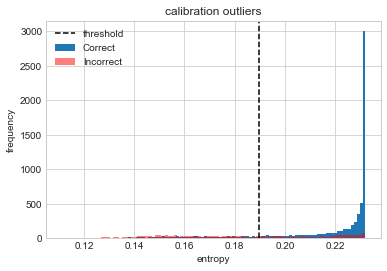

-----------------
rollover enabled, 2677 predictions provided
1533 inputs accepted 1094 Correct


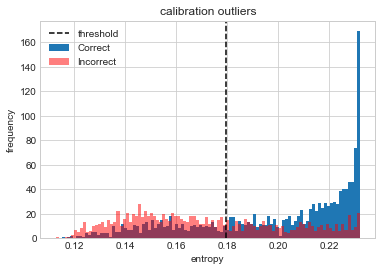

-----------------
rollover enabled, 1144 predictions provided
main_exit
1144 inputs accepted 657 Correct


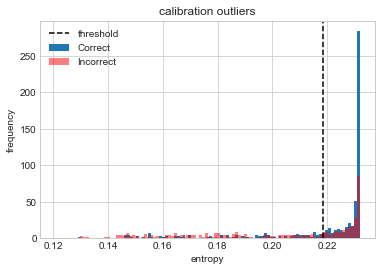

-----------------
  Exit_Name  Predictions  Test_Accuracy  RollOver_Accuracy  Threshold  Accepted  Accepted_Correct  Accepted_Ratio  Acceptance_Accuracy
0   branch1        10000         0.7323           0.732300   0.189781      7323              6184        0.732300             0.844463
1   branch2         2677         0.7537           0.559582   0.179688      1533              1094        0.572656             0.713633
2      main         1144         0.8095           0.574301   0.218630      1144               657        1.000000             0.574301
metric:  calibration threshold:  mean
  Exit_Name  Predictions  Test_Accuracy  RollOver_Accuracy  Threshold  Accepted  Accepted_Correct  Accepted_Ratio  Acceptance_Accuracy
0   branch1        10000         0.7323           0.732300   0.215663      5808              5220        0.580800             0.898760
1   branch2         4192         0.7537           0.591126   0.213668      1445              1189        0.344704             0.822837

In [124]:
calculateBranching(output_ID,threshold="PR_AUC",metrics=["calibration"],plot=True)
calculateBranching(output_ID,threshold="mean",metrics=["calibration"],plot=False)
calculateBranching(output_ID,threshold="gmean",metrics=["calibration"],plot=False)

metric:  energy threshold:  PR_AUC
2603 inputs accepted 2454 Correct


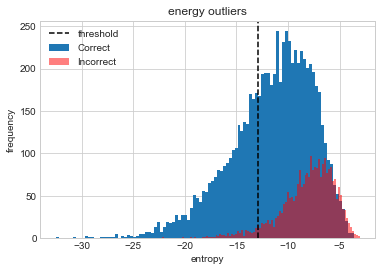

-----------------
rollover enabled, 7397 predictions provided
1172 inputs accepted 1100 Correct


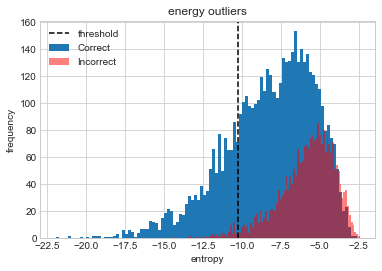

-----------------
rollover enabled, 6225 predictions provided
main_exit
6225 inputs accepted 4535 Correct


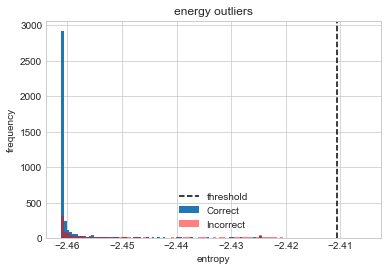

-----------------
  Exit_Name  Predictions  Test_Accuracy  RollOver_Accuracy  Threshold  Accepted  Accepted_Correct  Accepted_Ratio  Acceptance_Accuracy
0   branch1        10000         0.7398           0.739800 -12.896572      2603              2454        0.260300             0.942758
1   branch2         7397         0.7257           0.658510 -10.258673      1172              1100        0.158443             0.938567
2      main         6225         0.8125           0.728514  -2.410617      6225              4535        1.000000             0.728514
metric:  entropy threshold:  PR_AUC
2603 inputs accepted 2548 Correct


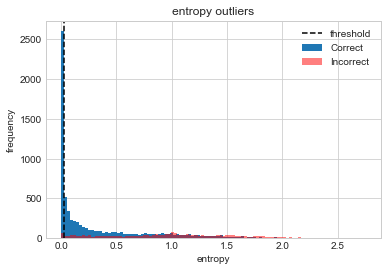

-----------------
rollover enabled, 7397 predictions provided
1176 inputs accepted 1125 Correct


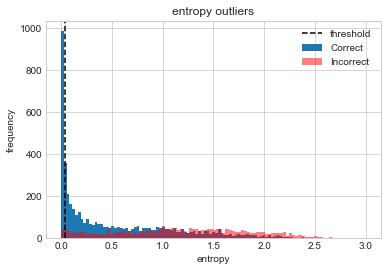

-----------------
rollover enabled, 6221 predictions provided
main_exit
6221 inputs accepted 4486 Correct


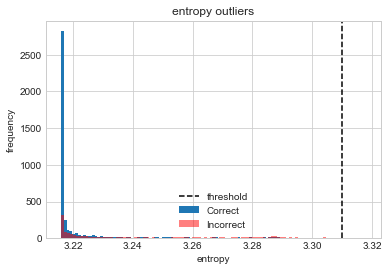

-----------------
  Exit_Name  Predictions  Test_Accuracy  RollOver_Accuracy  Threshold  Accepted  Accepted_Correct  Accepted_Ratio  Acceptance_Accuracy
0   branch1        10000         0.7398           0.739800   0.024893      2603              2548        0.260300             0.978871
1   branch2         7397         0.7257           0.650128   0.036116      1176              1125        0.158983             0.956633
2      main         6221         0.8125           0.721106   3.309832      6221              4486        1.000000             0.721106


In [174]:
calculateBranching(output_ID,threshold="PR_AUC",metrics=["energy"],plot=True)
calculateBranching(output_ID,threshold="PR_AUC",metrics=["entropy"],plot=True)
# calculateBranching(output_ID,threshold="gmean",metrics=["energy"],plot=False)

metric:  entropy threshold:  PR_AUC
2678 inputs accepted 2628 Correct


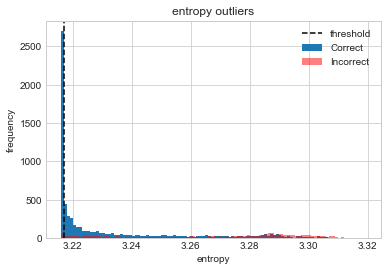

-----------------
rollover enabled, 7322 predictions provided
913 inputs accepted 885 Correct


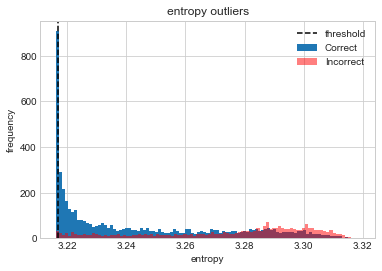

-----------------
rollover enabled, 6409 predictions provided
main_exit
6409 inputs accepted 4605 Correct


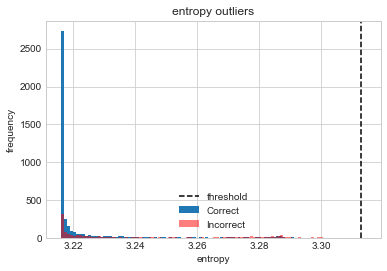

-----------------
  Exit_Name  Predictions  Test_Accuracy  RollOver_Accuracy  Threshold  Accepted  Accepted_Correct  Accepted_Ratio  Acceptance_Accuracy
0   branch1        10000         0.7323           0.732300   3.216938      2678              2628        0.267800             0.981329
1   branch2         7322         0.7537           0.679049   3.216995       913               885        0.124693             0.969332
2      main         6409         0.8095           0.718521   3.312944      6409              4605        1.000000             0.718521
metric:  entropy threshold:  mean
  Exit_Name  Predictions  Test_Accuracy  RollOver_Accuracy  Threshold  Accepted  Accepted_Correct  Accepted_Ratio  Acceptance_Accuracy
0   branch1        10000         0.7323           0.732300   3.234372      5561              5043        0.556100             0.906851
1   branch2         4439         0.7537           0.598558   3.236634      1427              1195        0.321469             0.837421
2  

In [167]:
calculateBranching(output_ID,threshold="PR_AUC",metrics=["entropy"],plot=True)
calculateBranching(output_ID,threshold="mean",metrics=["entropy"],plot=False)
calculateBranching(output_ID,threshold="gmean",metrics=["entropy"],plot=False)

metric:  uncert
4084 inputs accepted 3284 Correct


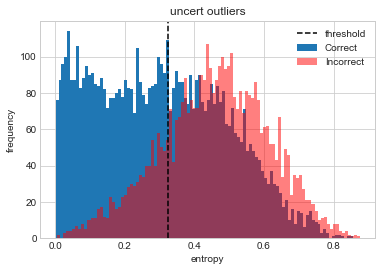

-----------------
rollover enabled, 5916 predictions provided
534 inputs accepted 500 Correct


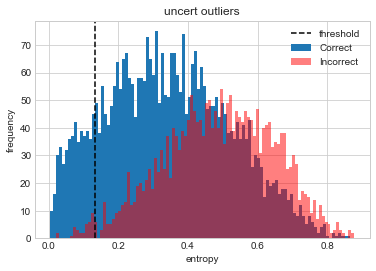

-----------------
rollover enabled, 5382 predictions provided
main_exit
5382 inputs accepted 3859 Correct


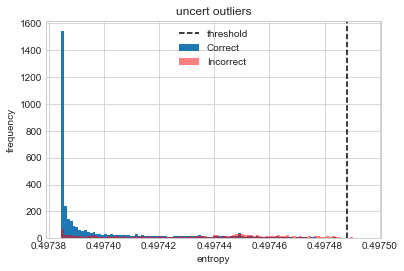

-----------------
  Exit_Name  Predictions  Test_Accuracy  RollOver_Accuracy  Threshold  Accepted  Accepted_Correct  Accepted_Ratio  Acceptance_Accuracy         Flops
0   branch1        10000         0.5917           0.591700   0.323077      4084              3284        0.408400             0.804114   71238314680
1   branch2         5916         0.7139           0.613083   0.134503       534               500        0.090264             0.936330   15710132616
2      main         5382         0.8091           0.717020   0.497488      5382              3859        1.000000             0.717020  711145311786
thresholds [0.32307744, 0.1345032, 0.4974882]
input_predictions [10000, 5916, 5382]
Accepted_list [4084, 534, 5382]
Acceptance_correct [3284, 500, 3859]
overall Accuracy 0.7643
branch_cost [71238314680, 15710132616, 711145311786]
base cost:  798093759082  total cost: 1126988380000
cost difference:  0.7081650292454656


In [34]:
calculateBranching(output_ID,threshold="PR_AUC",metrics=["uncert"],plot=)

In [132]:
import math
def buildCompareDistribPlot(ID,OOD,metrics=["energy"], threshold=None, legend=["In Distribution","Out of Distribution"],main_exit_included=True,plot=True):
        lessThanMetrics = ["energy","uncert","entropy"]
        if type(metrics ) is not list:
            metrics = [metrics]
        for j, metric in enumerate(metrics):
            print("metric: ", metric, "threshold: ",threshold)
            rollOver_ID_indices = pd.Index([])
            rollOver_OOD_indices = pd.Index([])
            
            _ID = ID.copy()
            _OOD = OOD.copy()
                # print(_branch_predictions)
            if main_exit_included:
                _ID.append(_ID.pop(0))
                _OOD.append(_OOD.pop(0))
            Accepted_df = pd.DataFrame()
            Input_ID=[]
            Input_OOD=[]
            Accepted_list =[]
            Accepted_ID_list = []
            Accepted_OOD_list = []
            Acceptance_correct =[]
            Input_predictions =[]
            Accepted_Ratio_list=[]
            Accepted_Accuracy_list=[]
            # Branch_cost =[17443270,29419724,132134023] #flat exit costs
            # Branch_cost =[482376,1517643,80095445,114361924,112698838] #Conv2d exit costs

            # Base_cost = 112698838
            Branch_flops = []
            Thresholds=[]
            Test_accuracy =[]
            Rollover_accuracy=[]
            Results=[]
            for i, (output_ID, output_OOD) in enumerate(zip(_ID, _OOD)): 
                Test_accuracy.append(len(output_ID.loc[(output_ID["correct"] == True)])/len(output_ID))
                
                legend = ["threshold","correct","incorrect", "OOD"]
                Correct = output_ID.loc[(output_ID['correct'] == True)]
                Incorrect = output_ID.loc[(output_ID['correct'] == False)]
                if plot:
                    _ = plt.hist(Correct[metric].tolist(), bins=100)  # arguments are passed to np.histogram
                    _ = plt.hist(Incorrect[metric].tolist(), bins=100,color ="red", alpha = 0.5)  # arguments are passed to np.histogram
                    _ = plt.hist(output_OOD[metric].tolist(), bins=100,color="grey",alpha=0.5)  # arguments are passed to np.histogram

                
                if threshold:
                    if type(threshold) is list:
                        if j >= len(threshold): #no threshold in the array so treat as None.
                            continue
                        _threshold = threshold[j]
                    else:
                        _threshold = threshold
                    if _threshold == "mean":
                        # _threshold = np.array(ID[metric]).mean()
                        Correct = output.loc[(output_ID["correct"] == True)]
                        _threshold = np.array(Correct[metric]).mean()
                    if _threshold == "gmean":
                        AUC_thresholds = calc_AUC(output_ID, metrics=metrics,plot = False)
                        _threshold = AUC_thresholds[j]
                    if _threshold == "PR_AUC":
                        precision_, recall_, proba = precision_recall_curve(output_ID['correct'], output_ID[metric])
                        _threshold = sorted(list(zip(np.abs(precision_ - recall_), proba)), key=lambda i: i[0], reverse=False)[0][1]
                    else:
                        _threshold = np.float32(_threshold)

                if len(rollOver_ID_indices)>0:
                    # print("rollover enabled, {} ID predictions provided".format(len(rollOver_ID_indices)))
                    output_ID = output_ID.iloc[rollOver_ID_indices]
                if len(rollOver_OOD_indices)>0:
                    # if plot:
                    # print("rollover enabled, {} OOD predictions provided".format(len(rollOver_OOD_indices)))
                    output_OOD = output_OOD.iloc[rollOver_OOD_indices]
                    
                if plot:
                    plt.axvline(x=_threshold, color='k', linestyle='--',label="threshold")
                    plt.title(metric + " outliers")
                    plt.legend(legend)
                    plt.xlabel("entropy")
                    plt.ylabel("frequency")
                    plt.show()
                if main_exit_included and i == len(_ID)-1 :
                    _threshold
                    if plot:
                        print("main_exit")
                    OOD_accepted = output_OOD
                    OOD_rejected = None
                    ID_accepted = output_ID
                    ID_rejected = None
                    accepted_correct = ID_accepted.loc[(ID_accepted["correct"] == True )] #TP
                    rejected_correct = None
                    accepted_incorrect = ID_accepted.loc[(ID_accepted[metric] ==False)] #FP
                    rejected_incorrect = None
                    accepted_ID_acc = len(accepted_correct) / (len( ID_accepted))
                    overall_accepted_acc = len(accepted_correct) / (len( ID_accepted) + len(OOD_accepted))
                    _threshold = "NA"
                    ### make a threshold that accepts everything, if less than, set to inf, if greater than, set to neg inf?
                    # if metric in lessThanMetrics:
                        # _threshold = math.inf
                    # else:
                        # _threshold = -math.inf
                # print(_threshold)
                else:
                    if metric in lessThanMetrics: ## metrics that require less than metric
                        OOD_accepted = output_OOD.loc[(output_OOD[metric].tolist() <= _threshold)] #FP
                        OOD_rejected = output_OOD.loc[(output_OOD[metric].tolist() > _threshold)] #TN
                        ID_accepted = output_ID.loc[(output_ID[metric] <= _threshold)] #TP
                        ID_rejected = output_ID.loc[(output_ID[metric] > _threshold)] #FN


                        accepted_correct = ID_accepted.loc[(ID_accepted["correct"] == True )] #TP
                        rejected_correct = ID_rejected.loc[(ID_rejected["correct"] == True)]  #FN

                        accepted_incorrect = ID_accepted.loc[(ID_accepted[metric] ==False)] #FP
                        rejected_incorrect = ID_rejected.loc[(ID_rejected[metric] ==False)] #TN

                        accepted_ID_acc = len(accepted_correct) / (len( ID_accepted))
                        overall_accepted_acc = len(accepted_correct) / (len( ID_accepted) + len(OOD_accepted))
                        # print("OOD accepted:", len(OOD_accepted),": with threshold:",_threshold )
                        # print("ID accepted:", len(ID_accepted), ":with acc:",(accepted_ID_acc))
                        # print("overall Accepted acc:",(overall_accepted_acc))

                        # print("OOD accepted with avg ID ",metric," threshold of ",_threshold, ": ", len(OOD.loc[(OOD[metric].tolist() <= _threshold)]), "out of ", len(OOD))
                        # print("ID accepted with avg ID ",metric," threshold of ",_threshold, ": ", len(ID.loc[(ID[metric] <= _threshold)]), "out of ", len(ID), "with acc of ", len(ID.loc[(ID[metric] <= _threshold) & ID['correct'] == True])/len(ID.loc[(ID[metric] <= _threshold)]))
                        # print("Overall accuracy of accepted inputs:", len(ID.loc[(ID[metric] <= _threshold) & ID['correct'] == True])/(len(ID.loc[(ID[metric] <= _threshold)])+len(OOD.loc[(OOD[metric] <= _threshold)])))
                    else: ### metrics that require greater than metric
                        OOD_accepted = output_OOD.loc[(output_OOD[metric].tolist() >= _threshold)] #FP
                        OOD_rejected = output_OOD.loc[(output_OOD[metric].tolist() < _threshold)] #TN
                        ID_accepted = output_ID.loc[(output_ID[metric] >= _threshold)] #TP
                        ID_rejected = output_ID.loc[(output_ID[metric] < _threshold)] #FN

                        accepted_correct = ID_accepted.loc[(ID_accepted["correct"] == True )] #TP
                        rejected_correct = ID_rejected.loc[(ID_rejected["correct"] == True)]  #FN

                        accepted_incorrect = ID_accepted.loc[(ID_accepted[metric] ==False)] #FP
                        rejected_incorrect = ID_rejected.loc[(ID_rejected[metric] ==False)] #TN



                        accepted_ID_acc = len(accepted_correct) / (len( ID_accepted))
                        overall_accepted_acc = len(accepted_correct) / (len( ID_accepted) + len(OOD_accepted))
                        # print("OOD accepted:", len(OOD_accepted),": with threshold:",_threshold )
                        # print("ID accepted:", len(ID_accepted), ":with acc:",(accepted_ID_acc))
                        # print("overall Accepted acc:",(overall_accepted_acc))

                        # print("OOD accepted with avg ID ",metric," threshold of ",_threshold, ": ", len(OOD.loc[(OOD[metric].tolist() >= _threshold)]), "out of ", len(OOD))
                        # print("ID accepted with avg ID ",metric," threshold of ",_threshold, ": ", len(ID.loc[(ID[metric] >= _threshold)]), "out of ", len(ID), "with acc of ", len(ID.loc[(ID[metric] >= _threshold) & ID['correct'] == True])/len(ID.loc[(ID[metric] >= _threshold)]))
                        # print("Overall accuracy of accepted inputs:", len(ID.loc[(ID[metric] <= _threshold) & ID['correct'] == True])/(len(ID.loc[(ID[metric] >= _threshold)])+len(OOD.loc[(OOD[metric] >= _threshold)])))
                    rollOver_ID_indices = ID_rejected.index
                    rollOver_OOD_indices = OOD_rejected.index
                
                Thresholds.append(_threshold)
                
                Results.append(accepted_correct +accepted_incorrect)
                Input_ID.append(len(output_ID))
                Input_OOD.append(len(output_OOD))
                Accepted_ID_list.append(len(ID_accepted))
                Accepted_OOD_list.append(len(OOD_accepted))
                Accepted_Ratio_list.append(len(ID_accepted)/(len(ID_accepted)+ len(OOD_accepted)))
                Acceptance_correct.append(len(accepted_correct))
                Accepted_Accuracy_list.append(overall_accepted_acc)
            df = pd.DataFrame({
            "Exit_Name":["branch1","branch2","main"],
            "ID_Inputs":Input_ID,
            "OOD_Inputs":Input_OOD,
            "Test_Accuracy":Test_accuracy,
            # "RollOver_Accuracy":Rollover_accuracy,
            "Threshold":Thresholds,
            "Accepted ID":Accepted_ID_list,
            "Accepted OOD":Accepted_OOD_list,
                
            "Accepted_Correct":Acceptance_correct,
            "Accepted_ID_Ratio":Accepted_Ratio_list,
            "Acceptance_Accuracy":Accepted_Accuracy_list,

            # "Flops":Branch_flops,
            # "Cost Ratio":,                                  
                          })
            with pd.option_context('expand_frame_repr', False):
                print (df)
                # print("TPR_ID-OOD",len(ID_accepted)/(len(ID_accepted) + len(ID_rejected)))
                # print("TPR_acc",len(accepted_correct)/(len(accepted_correct) + len(rejected_correct)))
                # if len(OOD) > 0:
                #     print("FPR_ID-OOD",len(OOD_accepted)/(len(OOD_accepted) + len(OOD_rejected)))
                # else: 
                #     print("FPR for OOD is div by zero, was OOD included?")
                # print("FPR_acc",len(accepted_incorrect)/(len(accepted_incorrect) + len(rejected_incorrect)))

In [178]:
buildCompareDistribPlot(output_ID_brev, output_OOD_brev, ["energy"], "PR_AUC",plot=False)

# buildCompareDistribPlot(output_ID, output_OOD, ["uncert"], "PR_AUC",plot=False)

# buildCompareDistribPlot(output_ID, output_OOD, ["calibration"], "PR_AUC",plot=False)

buildCompareDistribPlot(output_ID, output_OOD, ["entropy"], "PR_AUC",plot=False)
# buildCompareDistribPlot(output_ID, output_OOD, ["entropy"], "gmean",plot=True)

metric:  energy threshold:  PR_AUC
  Exit_Name  ID_Inputs  OOD_Inputs  Test_Accuracy  Threshold  Accepted ID  Accepted OOD  Accepted_Correct  Accepted_ID_Ratio  Acceptance_Accuracy
0   branch1      10000       10000         0.6612 -37.700043         3389           787              3173           0.811542             0.759818
1   branch2       6611        9213         0.7151  -47.37019          683           212               647           0.763128             0.722905
2      main       5928        9001         0.8074         NA         5928          9001              4230           0.397080             0.283341
metric:  entropy threshold:  PR_AUC
  Exit_Name  ID_Inputs  OOD_Inputs  Test_Accuracy Threshold  Accepted ID  Accepted OOD  Accepted_Correct  Accepted_ID_Ratio  Acceptance_Accuracy
0   branch1      10000       10000         0.7398  0.024893         2603           383              2548           0.871735             0.853315
1   branch2       7397        9617         0.7257  0.03

In [162]:
with pd.option_context('expand_frame_repr', False):
    for i in output_OOD:
        print(i.head())
        print(len(i.loc[i['entropy'] <=3.216938]))

   x   y    uncert    energy  Energy_softmax  Energy_evidence  Energy_alpha  Energy_Mass   entropy  calibration  confidence_alea_uncert  entropy_of_expected  expected_entropy  mutual_information      EPKL  differential_entropy  correct  outlier
0  5  49  0.497463 -2.418402       -2.402769        -3.312940     -4.312940    -2.402586  3.297531     0.138352                0.120285            -2.297697         -2.103796           -0.193901 -0.423970             14.066739        0        1
1  3  33  0.497443 -2.428442       -2.402927        -3.313111     -4.313111    -2.402586  3.279820     0.171133                0.137802            -2.293844         -2.100982           -0.192863 -0.421719             14.111050        0        1
2  4  72  0.497395 -2.455043       -2.403464        -3.313520     -4.313520    -2.402586  3.227911     0.223475                0.166434            -2.281703         -2.091598           -0.190106 -0.415763             14.233979        0        1
3  3  51  0.497457 -

In [163]:
with pd.option_context('expand_frame_repr', False):
    for i in output_ID:
        print(i.head())
        print(len(i.loc[i['entropy'] <=3.216938]))

   x  y    uncert    energy  Energy_softmax  Energy_evidence  Energy_alpha  Energy_Mass   entropy  calibration  confidence_alea_uncert  entropy_of_expected  expected_entropy  mutual_information      EPKL  differential_entropy  correct  outlier
0  3  3  0.497384 -2.461150       -2.403591        -3.313614     -4.313614    -2.402586  3.216028     0.231969                0.171205            -2.278840         -2.089366           -0.189474 -0.414397             14.262423        1        0
1  1  8  0.497385 -2.461076       -2.403590        -3.313613     -4.313613    -2.402586  3.216172     0.231869                0.171149            -2.278875         -2.089394           -0.189482 -0.414414             14.262078        0        0
2  8  8  0.497385 -2.461042       -2.403589        -3.313612     -4.313612    -2.402586  3.216238     0.231823                0.171123            -2.278891         -2.089406           -0.189485 -0.414422             14.261919        1        0
3  0  0  0.497385 -2.461

In [138]:
from numpy import sqrt
from numpy import argmax
from sklearn.datasets import make_classification
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score

from sklearn.metrics import precision_recall_curve
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, precision_recall_curve, plot_precision_recall_curve

from matplotlib import pyplot
# metrics = ['energy','entropy_of_expected']
def calc_AUC(output_df,metrics=['energy'],plot=False):
    lessThanMetrics = ["energy","uncert","entropy"]
    _thresholds = []
    y_test = np.int32(output_df['correct'])
    plots = []
    for metric in metrics:    
        lr_auc = roc_auc_score(y_test, output_df[metric])
        if metric in lessThanMetrics:
            pos_label = 0
        else:
            pos_label = 1
        fpr, tpr, thresholds = roc_curve(y_test, output_df[metric],pos_label=pos_label)
        gmeans = sqrt(tpr * (1-fpr))
        # print(gmeans)
        # locate the index of the largest g-mean
        ix = argmax(gmeans)
        threshold = thresholds[ix]
        print(metric," lr_auc",lr_auc, 'Best Threshold={}, G-Mean={}, TPR={}, FPR={}'.format(threshold, gmeans[ix],tpr[ix],fpr[ix]))
        _thresholds.append(threshold)
        # plot the roc curve for the model
        plots.append({"fpr":fpr,"tpr":tpr,"label":metric, "ix":ix})
    if plot:
        pyplot.plot([0,1], [0,1], linestyle='--', label='No Skill')
        for plot in plots:
            ix = plot['ix']
            pyplot.plot(plot["fpr"], plot["tpr"],  label=plot['label'])

            pyplot.scatter(plot["fpr"][ix], plot["tpr"][ix], marker='o', color='black')
        # axis labels
        pyplot.xlabel('False Positive Rate')
        pyplot.ylabel('True Positive Rate')
        pyplot.title(metric)
        pyplot.legend()
        # show the plot
        pyplot.show()
    return _thresholds

def buildCompareDistribPlot(ID,OOD=None,metrics=["energy"], threshold=None, legend=["In Distribution","Out of Distribution"]):
        AUC_thresholds = calc_AUC(ID, metrics=metrics,plot = True)
        lessThanMetrics = ["energy","uncert","entropy"]
        if type(metrics ) is not list:
            metrics = [metrics]
        for i, metric in enumerate(metrics):
            # _ = plt.hist(ID[metric].tolist(), bins=100)  # arguments are passed to np.histogram
            legend = ["threshold","correct","incorrect", "OOD"]
            Correct = ID.loc[(ID['correct'] == True)]
            Incorrect = ID.loc[(ID['correct'] == False)]
            _ = plt.hist(Correct[metric].tolist(), bins=100)  # arguments are passed to np.histogram
            _ = plt.hist(Incorrect[metric].tolist(), bins=100,color ="red", alpha = 0.5)  # arguments are passed to np.histogram
            if OOD is None:
                OOD = pd.DataFrame(columns=ID.columns)
            _ = plt.hist(OOD[metric].tolist(), bins=100,color="grey",alpha=0.5)  # arguments are passed to np.histogram
            # plt.title("Histogram with 'auto' bins")
            
            
            if threshold:
                if type(threshold) is list:
                    if i >= len(threshold): #no threshold in the array so treat as None.
                        continue
                    _threshold = threshold[i]
                else:
                    _threshold = threshold
                if _threshold == "mean":
                    # _threshold = np.array(ID[metric]).mean()
                    _threshold = np.array(Correct[metric]).mean()
                if _threshold == "gmean":
                    _threshold = AUC_thresholds[i]
                    # _threshold = np.array(ID[metric]).mean()
                    # fpr, tpr, thresholds = roc_curve(np.int32(ID['correct']), ID[metric],pos_label=0)
                    # gmeans = sqrt(tpr * (1-fpr))
                    # ix = argmax(gmeans)
                    # _threshold = thresholds[ix]
                if _threshold == "PR_AUC":
                    precision_, recall_, proba = precision_recall_curve(ID['correct'], ID[metric])
                    _threshold = sorted(list(zip(np.abs(precision_ - recall_), proba)), key=lambda i: i[0], reverse=False)[0][1]
                else:
                    _threshold = np.float32(_threshold)
                plt.axvline(x=_threshold, color='k', linestyle='--',label="threshold")
                plt.title(metric + " outliers")
                plt.legend(legend)
                plt.xlabel("entropy")
                plt.ylabel("frequency")
                plt.show()
                if metric in lessThanMetrics: ## metrics that require less than metric
                    OOD_accepted = OOD.loc[(OOD[metric].tolist() <= _threshold)] #FP
                    OOD_rejected = OOD.loc[(OOD[metric].tolist() > _threshold)] #TN
                    ID_accepted = ID.loc[(ID[metric] <= _threshold)] #TP
                    ID_rejected = ID.loc[(ID[metric] > _threshold)] #FN
                    
                    
                    accepted_correct = Correct.loc[(Correct[metric] <= _threshold)] #TP
                    rejected_correct = Correct.loc[(Correct[metric] > _threshold)]  #FN
                    
                    accepted_incorrect = Incorrect.loc[(Incorrect[metric] <= _threshold)] #FP
                    rejected_incorrect = Incorrect.loc[(Incorrect[metric] > _threshold)] #TN
                    
                    accepted_ID_acc = len(accepted_correct) / (len( ID_accepted))
                    overall_accepted_acc = len(accepted_correct) / (len( ID_accepted) + len(OOD_accepted))
                    print("OOD accepted:", len(OOD_accepted),": with threshold:",_threshold )
                    print("ID accepted:", len(ID_accepted), ":with acc:",(accepted_ID_acc))
                    print("overall Accepted acc:",(overall_accepted_acc))
                    
                    # print("OOD accepted with avg ID ",metric," threshold of ",_threshold, ": ", len(OOD.loc[(OOD[metric].tolist() <= _threshold)]), "out of ", len(OOD))
                    # print("ID accepted with avg ID ",metric," threshold of ",_threshold, ": ", len(ID.loc[(ID[metric] <= _threshold)]), "out of ", len(ID), "with acc of ", len(ID.loc[(ID[metric] <= _threshold) & ID['correct'] == True])/len(ID.loc[(ID[metric] <= _threshold)]))
                    # print("Overall accuracy of accepted inputs:", len(ID.loc[(ID[metric] <= _threshold) & ID['correct'] == True])/(len(ID.loc[(ID[metric] <= _threshold)])+len(OOD.loc[(OOD[metric] <= _threshold)])))
                else: ### metrics that require greater than metric
                    OOD_accepted = OOD.loc[(OOD[metric].tolist() >= _threshold)] #FP
                    OOD_rejected = OOD.loc[(OOD[metric].tolist() < _threshold)] #TN
                    ID_accepted = ID.loc[(ID[metric] >= _threshold)] #TP
                    ID_rejected = ID.loc[(ID[metric] < _threshold)] #FN
                    
                    accepted_correct = Correct.loc[(Correct[metric] >= _threshold)] #TP
                    rejected_correct = Correct.loc[(Correct[metric] < _threshold)]  #FN
                    
                    accepted_incorrect = Incorrect.loc[(Incorrect[metric] >= _threshold)] #FP
                    rejected_incorrect = Incorrect.loc[(Incorrect[metric] < _threshold)] #TN
                    
                    
                    
                    accepted_ID_acc = len(accepted_correct) / (len( ID_accepted))
                    overall_accepted_acc = len(accepted_correct) / (len( ID_accepted) + len(OOD_accepted))
                    print("OOD accepted:", len(OOD_accepted),": with threshold:",_threshold )
                    print("ID accepted:", len(ID_accepted), ":with acc:",(accepted_ID_acc))
                    print("overall Accepted acc:",(overall_accepted_acc))
                    
                    # print("OOD accepted with avg ID ",metric," threshold of ",_threshold, ": ", len(OOD.loc[(OOD[metric].tolist() >= _threshold)]), "out of ", len(OOD))
                    # print("ID accepted with avg ID ",metric," threshold of ",_threshold, ": ", len(ID.loc[(ID[metric] >= _threshold)]), "out of ", len(ID), "with acc of ", len(ID.loc[(ID[metric] >= _threshold) & ID['correct'] == True])/len(ID.loc[(ID[metric] >= _threshold)]))
                    # print("Overall accuracy of accepted inputs:", len(ID.loc[(ID[metric] <= _threshold) & ID['correct'] == True])/(len(ID.loc[(ID[metric] >= _threshold)])+len(OOD.loc[(OOD[metric] >= _threshold)])))
                
                print("TPR_ID-OOD",len(ID_accepted)/(len(ID_accepted) + len(ID_rejected)))
                print("TPR_acc",len(accepted_correct)/(len(accepted_correct) + len(rejected_correct)))
                if len(OOD) > 0:
                    print("FPR_ID-OOD",len(OOD_accepted)/(len(OOD_accepted) + len(OOD_rejected)))
                else: 
                    print("FPR for OOD is div by zero, was OOD included?")
                print("FPR_acc",len(accepted_incorrect)/(len(accepted_incorrect) + len(rejected_incorrect)))

energy  lr_auc 0.4420954222816514 Best Threshold=0.6266776323318481, G-Mean=0.5392735832037918, TPR=0.5870374968959523, FPR=0.5046040515653776
uncert  lr_auc 0.6111945439769917 Best Threshold=0.6424882411956787, G-Mean=0.4214332071208849, TPR=0.4315867891730817, FPR=0.58848150008371
entropy  lr_auc 0.23908319995230584 Best Threshold=1.1779698133468628, G-Mean=0.6944930195760037, TPR=0.7442264713185994, FPR=0.3519169596517663
calibration  lr_auc 0.767563131018646 Best Threshold=0.6875507235527039, G-Mean=0.7005592552981639, TPR=0.6845806127574083, FPR=0.28308914824931714


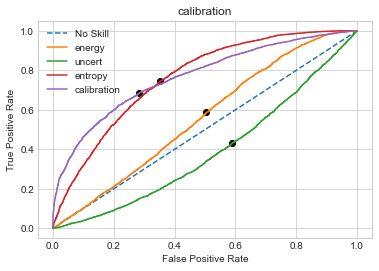

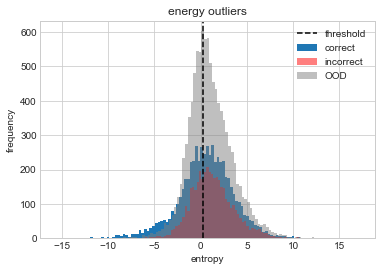

OOD accepted: 3935 : with threshold: 0.2630725
ID accepted: 4028 :with acc: 0.6519364448857994
overall Accepted acc: 0.32977521034785884
TPR_ID-OOD 0.4028
TPR_acc 0.43964506947932364
FPR_ID-OOD 0.3935
FPR_acc 0.3481499875838093


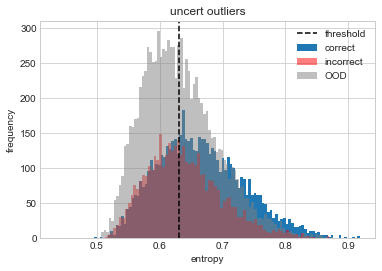

OOD accepted: 5368 : with threshold: 0.6314874
ID accepted: 4028 :with acc: 0.5034756703078451
overall Accepted acc: 0.21583652618135377
TPR_ID-OOD 0.4028
TPR_acc 0.33952787543947766
FPR_ID-OOD 0.5368
FPR_acc 0.4966476285075739


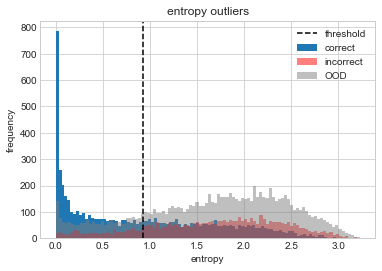

OOD accepted: 1908 : with threshold: 0.92764586
ID accepted: 4028 :with acc: 0.8331678252234359
overall Accepted acc: 0.5653638814016172
TPR_ID-OOD 0.4028
TPR_acc 0.5618617110329818
FPR_ID-OOD 0.1908
FPR_acc 0.16687360317854483


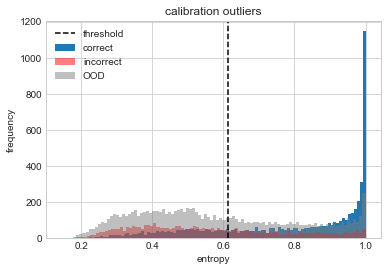

OOD accepted: 4024 : with threshold: 0.61402047
ID accepted: 5973 :with acc: 0.7461911937050059
overall Accepted acc: 0.4458337501250375
TPR_ID-OOD 0.5973
TPR_acc 0.7461911937050059
FPR_ID-OOD 0.4024
FPR_acc 0.376458902408741


In [ ]:
buildCompareDistribPlot(output_ID, output_OOD, ["energy",'uncert','entropy','calibration'], "PR_AUC")

energy  lr_auc 0.2722029825472649 Best Threshold=-32.56050109863281, G-Mean=0.66607395848115, TPR=0.7126696832579186, FPR=0.3774752475247525
uncert  lr_auc 0.31638608086275255 Best Threshold=0.1802276074886322, G-Mean=0.62938448550687, TPR=0.6555429864253394, FPR=0.39573019801980197
entropy  lr_auc 0.2374392213330496 Best Threshold=0.00043300143443048, G-Mean=0.7017048641576846, TPR=0.7774321266968326, FPR=0.3666460396039604
calibration  lr_auc 0.7540569278930156 Best Threshold=0.9999741315841675, G-Mean=0.7015787824510725, TPR=0.6338180693069307, FPR=0.2234162895927602


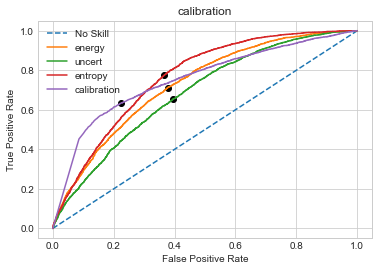

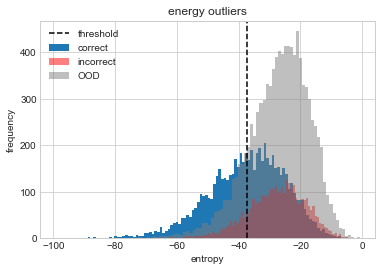

OOD accepted: 1480 : with threshold: -37.3288
ID accepted: 3575 :with acc: 0.8475524475524475
overall Accepted acc: 0.599406528189911
TPR_ID-OOD 0.3575
TPR_acc 0.46875
FPR_ID-OOD 0.148
FPR_acc 0.1541289592760181


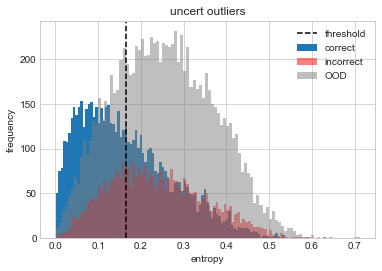

OOD accepted: 2543 : with threshold: 0.16586734
ID accepted: 4690 :with acc: 0.7742004264392324
overall Accepted acc: 0.5020047006774506
TPR_ID-OOD 0.469
TPR_acc 0.5617264851485149
FPR_ID-OOD 0.2543
FPR_acc 0.29949095022624433


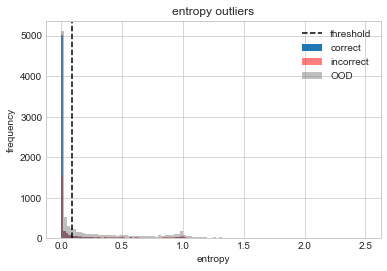

OOD accepted: 6098 : with threshold: 0.08850501
ID accepted: 7418 :with acc: 0.7314640064707468
overall Accepted acc: 0.4014501331754957
TPR_ID-OOD 0.7418
TPR_acc 0.8394183168316832
FPR_ID-OOD 0.6098
FPR_acc 0.5633484162895928


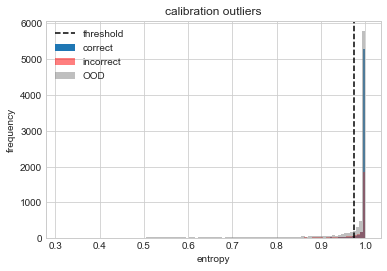

OOD accepted: 6723 : with threshold: 0.9752796
ID accepted: 7869 :with acc: 0.7158469945355191
overall Accepted acc: 0.3860334429824561
TPR_ID-OOD 0.7869
TPR_acc 0.8714418316831684
FPR_ID-OOD 0.6723
FPR_acc 0.6323529411764706


In [112]:
buildCompareDistribPlot(output_ID, output_OOD, ["energy",'uncert','entropy','calibration'], "mean")

In [71]:
def combineThresholds(ID,OOD,metrics=["energy"], threshold=None, legend=["In Distribution","Out of Distribution"],excel=False):
        # if type(metrics ) is not list:
        #     metrics = [metrics]
        # for i, metric in enumerate(metrics):
        metric  = 'energy'
        print("------", metric, "--------")
        energy_threshold = np.array(ID[metric]).mean()
        print(energy_threshold)
        _ID = ID.loc[(ID[metric].tolist() <= energy_threshold)]
        _OOD = OOD.loc[(OOD[metric].tolist() <= energy_threshold)]
        print("OOD accepted",len(_OOD))
        print("ID accepted",len(_ID))
        print("ID acc", len(_ID.loc[_ID['correct']==True])/len(_ID))
        print("overall Acc (ID+OOD)", len(_ID.loc[_ID['correct'] == True])/(len(_ID)+len(_OOD)))
        #### now T/F threshold
        metric = 'energy'
        print("metric", metric)
        # print( (output_ID.loc[output_ID['correct'] == True]))
        correct_threshold = np.array((output_ID.loc[output_ID['correct'] == True])[metric] ).mean()
        print("threshold", correct_threshold)
        _OOD_accepted = _OOD.loc[(_OOD[metric].tolist() <= correct_threshold)]
        print("OOD accepted", len(_OOD_accepted))
        _ID_accepted = _ID.loc[(_ID[metric].tolist() <= correct_threshold)]
        print("ID accepted",len(_ID_accepted))
        print("ID acc", len(_ID_accepted.loc[_ID_accepted['correct'] == True])/len(_ID_accepted))
        print("overall Acc (ID+OOD)", len(_ID_accepted.loc[_ID_accepted['correct'] == True])/(len(_ID_accepted)+len(_OOD_accepted)))
        # _OOD = output_OOD.loc[(output_OOD[metric].tolist() <= energy_threshold)]
        if excel: #print out a single line with all the values for quick addition to excel                
            print(metric, ",", energy_threshold, ",", len(_OOD), ",", len(_ID),",",
                                                       len(_ID.loc[_ID['correct']==True])/len(_ID),",",
                                                       correct_threshold, ",",len(_OOD_accepted),",",
                                                       len(_ID_accepted),",", ",",
                                                       len(_ID_accepted.loc[_ID_accepted['correct'] == True])/len(_ID_accepted),',',
                                                       len(_ID_accepted.loc[_ID_accepted['correct'] == True])/(len(_ID_accepted)+len(_OOD_accepted)))
# combineThresholds(output_ID,output_OOD, metrics = ['energy','uncert',"Energy_softmax","Energy_evidence","entropy"], excel=True)
# combineThresholds(output_ID,output_OOD, metrics = ['energy'], excel=True)



def combineThresholds2(ID,OOD,metrics=["energy"], threshold=None, legend=["In Distribution","Out of Distribution"],excel=False):
        if type(metrics ) is not list:
            metrics = [metrics]
        # for i, metric in enumerate(metrics):
        metric  = 'energy'
        print("------", metric, "--------")

        # print( (output_ID.loc[output_ID['correct'] == True]))
        correct_threshold = np.array((ID.loc[ID['correct'] == True])[metric] ).mean()
        print("threshold", correct_threshold)
        OOD_accepted = OOD.loc[(OOD[metric].tolist() <= correct_threshold)]
        print("OOD accepted", len(OOD_accepted))
        ID_accepted = ID.loc[(ID[metric].tolist() <= correct_threshold)]
        print("ID accepted",len(ID_accepted))
        print("ID acc", len(ID_accepted.loc[ID_accepted['correct'] == True])/len(ID_accepted))
        print("overall Acc (ID+OOD)", len(ID_accepted.loc[ID_accepted['correct'] == True])/(len(ID_accepted)+len(OOD_accepted)))
        # _OOD = output_OOD.loc[(output_OOD[metric].tolist() <= energy_threshold)]


        metric  = 'energy'
        print("metric", metric)

        energy_threshold = np.array(ID[metric]).mean()
        print(energy_threshold)
        _ID = ID_accepted.loc[(ID_accepted[metric].tolist() <= energy_threshold)]
        _OOD = OOD_accepted.loc[(OOD_accepted[metric].tolist() <= energy_threshold)]
        print("OOD accepted",len(_OOD))
        print("ID accepted",len(_ID))
        print("ID acc", len(_ID.loc[_ID['correct']==True])/len(_ID))
        print("overall Acc (ID+OOD)", len(_ID.loc[_ID['correct'] == True])/(len(_ID)+len(_OOD)))
        #### now T/F threshold

        if excel: #print out a single line with all the values for quick addition to excel                
            print(metric, ",", correct_threshold, ",", len(OOD_accepted), ",", len(ID_accepted),",",
                                                       len(ID_accepted.loc[ID_accepted['correct']==True])/len(ID_accepted),",",
                                                       energy_threshold, ",",len(_OOD),",",
                                                       len(_ID),",", ",",
                                                       len(_ID.loc[_ID['correct'] == True])/len(_ID),',',
                                                       len(_ID.loc[_ID['correct'] == True])/(len(_ID)+len(_OOD)))
# combineThresholds(output_ID,output_OOD, metrics = ['energy','uncert',"Energy_softmax","Energy_evidence","entropy"], excel=True)
combineThresholds2(output_ID,output_OOD, metrics = ['energy'], excel=True)

 # df = pd.DataFrame({"x":Results,"y":Labels,"uncert":Uncert,"energy":Energy,"Energy_softmax":Energy_softmax,"Energy_evidence":Energy_evidence,"Energy_alpha":Energy_alpha,"Energy_Mass":Energy_Mass,'entropy':Entropy,'calibration':calibration})

------ energy --------
threshold -49.350967
OOD accepted 820
ID accepted 2952
ID acc 0.9258130081300813
overall Acc (ID+OOD) 0.7245493107104984
metric energy
-35.580128
OOD accepted 820
ID accepted 2952
ID acc 0.9258130081300813
overall Acc (ID+OOD) 0.7245493107104984
energy , -49.350967 , 820 , 2952 , 0.9258130081300813 , -35.580128 , 820 , 2952 , , 0.9258130081300813 , 0.7245493107104984


In [36]:
###find 95% TPR
def buildTPR(ID,OOD,metrics=["energy"], threshold=None, legend=["In Distribution","Out of Distribution"]):
        if type(metrics ) is not list:
            metrics = [metrics]
        for i, metric in enumerate(metrics):
            _max =  np.array(ID[metric]).max()
            _min =  np.array(ID[metric]).min()
            linrange = np.linspace(_min, _max,100)
            print(len(linrange))
            total_correct = ID.loc[ID['correct'] == True]
            print(len(total_correct))
            # TP_qualifier = round(len(total_correct)*.95)
            TP_qualifier = round(len(ID)*.95)
            print("TP_qual",TP_qualifier)
            for point in linrange:
                # print(point)
                #get ID below this amount
                # TP = ID.loc[(ID[metric]<=point) & ID['correct'] == True]
                TP = ID.loc[(ID[metric]<=point) ]#& ID['correct'] == True]
                if len(TP) >=TP_qualifier:
                    FP = OOD.loc[(OOD[metric]<=point)]
                    print(point, "ID:", len(TP)," OOD:",len(FP))
            
            _ = plt.hist(ID[metric].tolist(), bins=100)  # arguments are passed to np.histogram
            _ = plt.hist(OOD[metric].tolist(), bins=100,color="red",alpha=0.5)  # arguments are passed to np.histogram
            # plt.title("Histogram with 'auto' bins")
            plt.title(metric + " outliers")
            plt.legend(legend)
            plt.xlabel("entropy")
            plt.ylabel("frequency")
            plt.show()
            # if threshold:
            #     if type(threshold) is list:
            #         if i >= len(threshold): #no threshold in the array so treat as None.
            #             continue
            #         _threshold = threshold[i]
            #     else:
            #         _threshold = threshold
            #     if _threshold == "mean":
            #         _threshold = np.array(ID[metric]).mean()
            #     print("OOD accepted with avg ID ",metric," threshold of ",_threshold, ": ", len(OOD.loc[(OOD[metric].tolist() <= _threshold)]), "out of ", len(OOD))
            #     print("ID accepted with avg ID ",metric," threshold of ",_threshold, ": ", len(ID.loc[(ID[metric] <= _threshold)]), "out of ", len(ID), "with acc of ", len(ID.loc[(ID[metric] <= _threshold) & ID['correct'] == True])/len(ID.loc[(ID[metric] <= _threshold)]))
            #     print("Overall accuracy of accepted inputs:", len(ID.loc[(ID[metric] <= _threshold) & ID['correct'] == True])/(len(ID.loc[(ID[metric] <= _threshold)])+len(OOD.loc[(OOD[metric] <= _threshold)])))
            #     Correct = ID.loc[(ID['correct'] == True)]
            #     # print(len(Correct))
            #     Incorrect = ID.loc[(ID['correct'] == False)]
            #     print("overall acc on ID:",len(Correct)/len(ID))

100
6217
TP_qual 9500
-1.2737780062839246 ID: 9503  OOD: 9160
-1.2017745176951093 ID: 9572  OOD: 9291
-1.1297710291062941 ID: 9651  OOD: 9426
-1.0577675405174798 ID: 9697  OOD: 9516
-0.9857640519286655 ID: 9746  OOD: 9597
-0.9137605633398502 ID: 9796  OOD: 9649
-0.841757074751035 ID: 9830  OOD: 9687
-0.7697535861622207 ID: 9858  OOD: 9734
-0.6977500975734063 ID: 9881  OOD: 9769
-0.6257466089845911 ID: 9901  OOD: 9800
-0.5537431203957759 ID: 9918  OOD: 9818
-0.48173963180696155 ID: 9933  OOD: 9838
-0.4097361432181472 ID: 9938  OOD: 9852
-0.337732654629332 ID: 9945  OOD: 9869
-0.2657291660405168 ID: 9950  OOD: 9880
-0.19372567745170244 ID: 9957  OOD: 9893
-0.1217221888628881 ID: 9962  OOD: 9909
-0.04971870027407288 ID: 9966  OOD: 9920
0.022284788314742343 ID: 9971  OOD: 9931
0.09428827690355668 ID: 9976  OOD: 9937
0.166291765492371 ID: 9980  OOD: 9946
0.23829525408118624 ID: 9983  OOD: 9953
0.31029874267000146 ID: 9985  OOD: 9954
0.3823022312588158 ID: 9987  OOD: 9960
0.45430571984763013

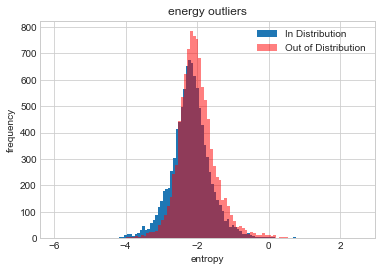

In [37]:
#crossEnergy
buildTPR(output_ID, output_OOD, ["energy"], "mean")

100
6408
TP_qual 9500
18.193120166508834 ID: 9663  OOD: 9363
22.363708650222918 ID: 9778  OOD: 9594
26.534297133937002 ID: 9868  OOD: 9744
30.704885617651144 ID: 9915  OOD: 9829
34.87547410136523 ID: 9945  OOD: 9885
39.04606258507931 ID: 9956  OOD: 9928
43.2166510687934 ID: 9966  OOD: 9955
47.38723955250748 ID: 9981  OOD: 9972
51.557828036221565 ID: 9986  OOD: 9981
55.728416519935706 ID: 9992  OOD: 9983
59.89900500364979 ID: 9995  OOD: 9988
64.06959348736387 ID: 9996  OOD: 9990
68.24018197107796 ID: 9998  OOD: 9994
72.41077045479204 ID: 9998  OOD: 9999
76.58135893850613 ID: 9998  OOD: 9999
80.75194742222027 ID: 9998  OOD: 10000
84.92253590593435 ID: 9999  OOD: 10000
89.09312438964844 ID: 10000  OOD: 10000


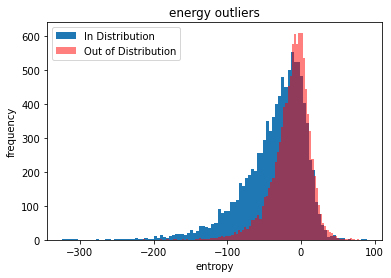

100
6408
TP_qual 9500
10.0 ID: 10000  OOD: 10000


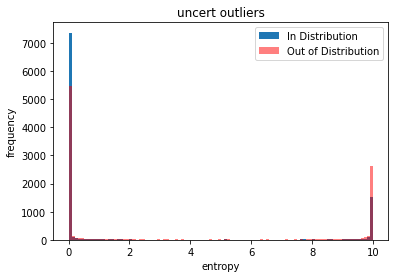

In [86]:
#EDL energy
buildTPR(output_ID, output_OOD, ["energy","uncert"], "mean")

In [88]:
# calculate scores
from numpy import sqrt
from numpy import argmax
from sklearn.datasets import make_classification
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score

from sklearn.metrics import precision_recall_curve
from sklearn.metrics import PrecisionRecallDisplay

from matplotlib import pyplot
metrics = ['energy','entropy_of_expected']


def calc_aucpr(output_df,metrics=['energy'],plot=False):
    lessThanMetrics = ["energy","uncert","entropy"]
    _thresholds = []
    y_test = np.int32(output_df['correct'])
    
    for metric in metrics:    
        lr_auc = roc_auc_score(y_test, output_df[metric])
        if metric in lessThanMetrics:
            pos_label = 0
        else:
            pos_label = 1
        fpr, tpr, thresholds = precision_recall_curve(y_test, output_df[metric],pos_label=pos_label)
        gmeans = sqrt(tpr * (1-fpr))
        # print(gmeans)
        # locate the index of the largest g-mean
        ix = argmax(gmeans)
        threshold = thresholds[ix]
        print('Best Threshold={}, G-Mean={}, P={}, R={}'.format(threshold, gmeans[ix],tpr[ix],fpr[ix]))
        
        display = PrecisionRecallDisplay.from_predictions(y_test, output_df[metric], name="LinearSVC")
        _ = display.ax_.set_title("2-class Precision-Recall curve")
    return _thresholds

# threshold = calc_gmeans(output_ID, metrics=['energy'],plot = True)
# print(threshold)

from sklearn.metrics import precision_recall_fscore_support
from sklearn.metrics import f1_score
precision_recall_fscore_support(output_ID['x'], output_ID['y'], average='macro')
# roc_auc_score(output_ID['correct'], output_ID['energy'])

(0.6464000000000001, 0.6490218675861255, 0.6450334719396431, None)

-37.470623
energy  lr_auc 0.2722029825472649 Best Threshold=-32.56050109863281, G-Mean=0.66607395848115, TPR=0.7126696832579186, FPR=0.3774752475247525


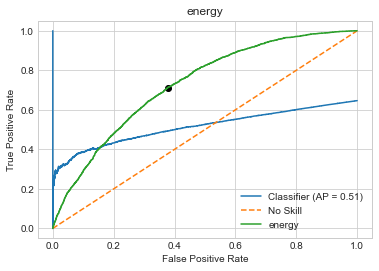

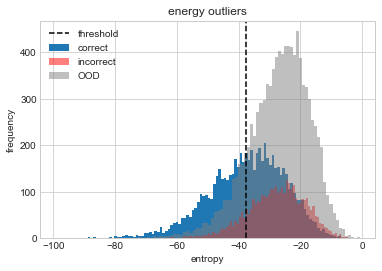

OOD accepted: 1447 : with threshold: -37.470623
ID accepted: 3537 :with acc: 0.8490245971162002
overall Accepted acc: 0.6025280898876404
TPR_ID-OOD 0.3537
TPR_acc 0.4645730198019802
FPR_ID-OOD 0.1447
FPR_acc 0.1510180995475113


In [104]:
from sklearn.metrics import PrecisionRecallDisplay
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, precision_recall_curve, plot_precision_recall_curve
y_test = output_ID['correct']
X_test = output_ID['energy']
precision_, recall_, proba = precision_recall_curve(y_test, X_test)

PrecisionRecallDisplay.from_predictions(output_ID['correct'], output_ID['energy'])

# PrecisionRecallDisplay(X_test, y_test)
# disp.ax_.set_title('Precision-Recall curve')

optimal_proba_cutoff = sorted(list(zip(np.abs(precision_ - recall_), proba)), key=lambda i: i[0], reverse=False)[0][1]
roc_predictions = [1 if i >= optimal_proba_cutoff else 0 for i in X_test]
print(optimal_proba_cutoff)
# print(roc_predictions)
buildCompareDistribPlot(output_ID, output_OOD, ["energy"], optimal_proba_cutoff)

Best Threshold=-76.6483383178711, G-Mean=0.8034387247706902, P=1.0, R=0.3544862155388471
Best Threshold=0.004616542719304562, G-Mean=0.8034387247706902, P=1.0, R=0.3544862155388471
Best Threshold=3.495582809081781e-19, G-Mean=0.8007025231631392, P=1.0, R=0.35887546940018267
Best Threshold=0.3779428005218506, G-Mean=0.5945340142824697, P=1.0, R=0.6465293058611722


[]

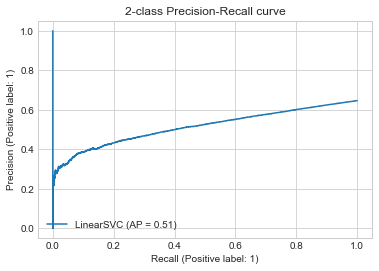

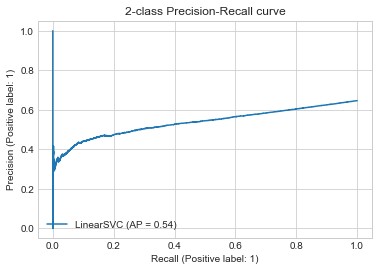

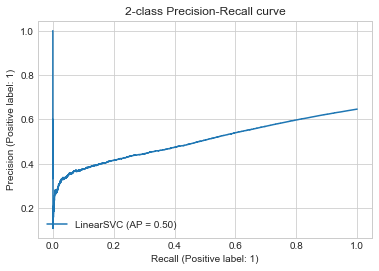

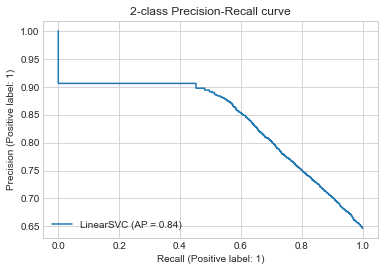

In [89]:
calc_aucpr(output_ID,metrics=["energy",'uncert','entropy','calibration'],plot=False)

max,min 1.0 0.36905995
0.3690599501132965 6464 3536
0.3754330819303339 6464 3535
0.38180621374737134 6463 3532
0.38817934556440875 6463 3531
0.39455247738144616 6463 3531
0.4009256091984835 6463 3528
0.407298741015521 6463 3526
0.41367187283255835 6463 3526
0.42004500464959577 6463 3524
0.4264181364666332 6463 3521
0.4327912682836706 6462 3517
0.439164400100708 6460 3517
0.4455375319177454 6460 3514
0.45191066373478284 6458 3513
0.45828379555182025 6458 3513
0.46465692736885766 6456 3509
0.471030059185895 6456 3506
0.4774031910029325 6456 3499
0.48377632281996985 6454 3495
0.49014945463700726 6452 3491
0.4965225864540447 6451 3488
0.502895718271082 6447 3481
0.5092688500881195 6438 3476
0.515641981905157 6435 3464
0.5220151137221943 6429 3452
0.5283882455392317 6425 3441
0.5347613773562692 6419 3430
0.5411345091733065 6415 3421
0.547507640990344 6411 3414
0.5538807728073813 6406 3406
0.5602539046244188 6401 3387
0.5666270364414562 6392 3379
0.5730001682584935 6385 3366
0.57937330007553

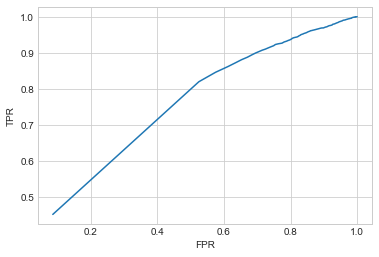

In [72]:
# calculate scores
from numpy import sqrt
from numpy import argmax
from sklearn.datasets import make_classification
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score

from sklearn.metrics import precision_recall_curve

from matplotlib import pyplot

def self_calc_AUC(output_df, metrics=['energy'], plot=False):
    lessThanMetrics = ["energy","uncert","entropy"]
    _thresholds = []
    
    y_test = np.int32(output_df['correct'])
    plots = []
    for metric in metrics:    
        #order the dataframe from lowest to highest
        df = output_df.sort_values(by=[metric,'correct'])
        t_max = df[metric].max()
        t_min = df[metric].min()
        print("max,min", t_max,t_min)
        #create a linspace
        linspace = np.linspace(t_min, t_max,num=100)
        Total_P = len(df.loc[df['correct']==True])
        Total_F = len(df.loc[df['correct']==False])
        TPR=[]
        FPR=[]
        for thresh in linspace:
            _outputs = df.loc[df[metric]>= thresh]
            correct = _outputs.loc[_outputs['correct']==True]
            incorrect = _outputs.loc[_outputs['correct']==False]
            print(thresh, len(correct), len(incorrect))
            _TPR = len(correct)/ Total_P
            _FPR = len(incorrect)/ Total_F
            TPR.append(_TPR)
            FPR.append(_FPR)
        # print(FPR)
        # print(TPR)
        pyplot.plot(FPR, TPR)
        pyplot.xlabel("FPR")
        pyplot.ylabel("TPR")
        pyplot.show()#     
# threshold = self_calc_AUC(output_ID, metrics=['energy'],plot = True)   
threshold = self_calc_AUC(output_ID, metrics=['calibration'],plot = True)   

energy  lr_auc 0.23328679452194093 Best Threshold=-48.40744400024414, G-Mean=0.7009286192837358, TPR=0.7452460850111857, FPR=0.3407534246575342


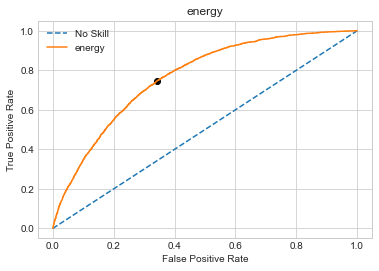

calibration  lr_auc 0.6673192808846022 Best Threshold=1.0, G-Mean=0.638403421479321, TPR=0.8429327521793275, FPR=0.5164988814317674


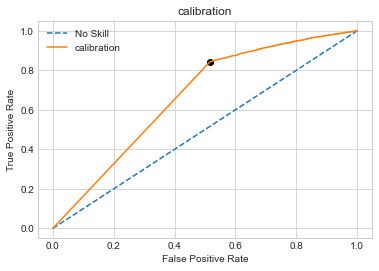

In [61]:
threshold = calc_AUC(output_ID, metrics=["energy"],plot = True)
threshold = calc_AUC(output_ID, metrics=["calibration"],plot = True)

In [41]:
# calculate scores
from numpy import sqrt
from numpy import argmax
from sklearn.datasets import make_classification
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score

from sklearn.metrics import precision_recall_curve

from matplotlib import pyplot
# metrics = ['energy','entropy_of_expected']


def calc_AUC(output_df,metrics=['energy'],plot=False):
    lessThanMetrics = ["energy","uncert","entropy"]
    _thresholds = []
    
    y_test = np.int32(output_df['correct'])
    plots = []
    for metric in metrics:    
        lr_auc = roc_auc_score(y_test, output_df[metric])
        
        if metric in lessThanMetrics:
            pos_label = 0
        else:
            pos_label = 1
        fpr, tpr, thresholds = roc_curve(y_test, output_df[metric],pos_label=pos_label)
        gmeans = sqrt(tpr * (1-fpr))
        # print(gmeans)
        # locate the index of the largest g-mean
        ix = argmax(gmeans)
        threshold = thresholds[ix]
        print(metric," lr_auc",lr_auc, 'Best Threshold={}, G-Mean={}, TPR={}, FPR={}'.format(threshold, gmeans[ix],tpr[ix],fpr[ix]))
        _thresholds.append(threshold)
        # plot the roc curve for the model
        plots.append({"fpr":fpr,"tpr":tpr,"label":metric, "ix":ix})
    if plot:
        pyplot.plot([0,1], [0,1], linestyle='--', label='No Skill')
        for plot in plots:
            ix = plot['ix']
            pyplot.plot(plot["fpr"], plot["tpr"],  label=plot['label'])

            pyplot.scatter(plot["fpr"][ix], plot["tpr"][ix], marker='o', color='black')
        # axis labels
        pyplot.xlabel('False Positive Rate')
        pyplot.ylabel('True Positive Rate')
        pyplot.title(metric)
        pyplot.legend()
        # show the plot
        pyplot.show()

#         accepted = output_df.loc[output_df[metric] <= threshold]
#         y_test_accept = np.int32(accepted['correct'])
#         lr_auc = roc_auc_score(y_test_accept, accepted[metric])
#         print(len(thresholds))
#         print("lr_auc_accepted",lr_auc)

#         threshold2 = np.array(output_df.loc[output_df['correct']==True][metric]).mean()
#         accepted2 = output_df.loc[output_df[metric] <= threshold2]
#         y_test_accept = np.int32(accepted2['correct'])
#         lr_auc = roc_auc_score(y_test_accept, accepted2[metric])
#         print("lr_auc_accepted2",lr_auc)



#         print(len(accepted), len(accepted.loc[(accepted['correct'] == True)]))
#         _ = pyplot.hist(output_df[metric].tolist(), bins=100,alpha=0.5)  # arguments are passed to np.histogram
#         _ = pyplot.hist(output_df.loc[(output_df['correct'] == True)][metric].tolist(), bins=100)  # arguments are passed to np.histogram
#         plt.axvline(x=threshold, color='k', linestyle='--',label="threshold")
#         pyplot.show()
            
    return _thresholds

# threshold = calc_gmeans(output_ID, metrics=['energy','uncert','expected_entropy','calibration'],plot = True)


# print(threshold)

energy  lr_auc 0.23581525312294546 Best Threshold=-65.02085876464844, G-Mean=0.6930189181980165, TPR=0.7151234567901235, FPR=0.32840236686390534
entropy  lr_auc 0.21818394331214847 Best Threshold=7.617240171953199e-10, G-Mean=0.7112415642998093, TPR=0.7209876543209877, FPR=0.29837278106508874
uncert  lr_auc 0.2504219857184601 Best Threshold=0.01307495404034853, G-Mean=0.6874553625126794, TPR=0.6984567901234567, FPR=0.32337278106508877
confidence_alea_uncert  lr_auc 0.6952099998173716 Best Threshold=1.0, G-Mean=0.679469876950052, TPR=0.7714497041420119, FPR=0.4015432098765432
entropy_of_expected  lr_auc 0.7661175031046826 Best Threshold=-3.731665636471849e-09, G-Mean=0.7051306980012914, TPR=0.7013313609467455, FPR=0.2910493827160494
expected_entropy  lr_auc 0.7663178921031485 Best Threshold=-3.909963365774104e-09, G-Mean=0.7051306980012914, TPR=0.7013313609467455, FPR=0.2910493827160494
calibration  lr_auc 0.6932918310322156 Best Threshold=1.0, G-Mean=0.6743145587834388, TPR=0.797633136

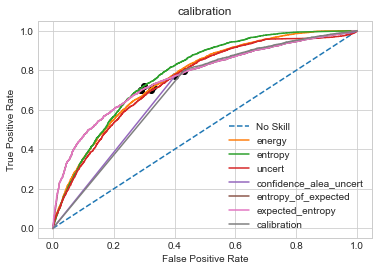

In [42]:
threshold = calc_AUC(output_ID, metrics=["energy","entropy","uncert","confidence_alea_uncert","entropy_of_expected","expected_entropy","calibration"],plot = True)

energy  lr_auc 0.30746509020901197 Best Threshold=-12.230971336364746, G-Mean=0.6447222206555288, TPR=0.6918058455114823, FPR=0.39915693904020755
entropy  lr_auc 0.23931991909214234 Best Threshold=0.7835158109664917, G-Mean=0.6983915306471645, TPR=0.759133611691023, FPR=0.35749027237354086
uncert  lr_auc 0.35281864661435275 Best Threshold=0.3646439015865326, G-Mean=0.6121356188521229, TPR=0.6072546972860126, FPR=0.3829442282749676
confidence_alea_uncert  lr_auc 0.7616135598848119 Best Threshold=0.832136869430542, G-Mean=0.6976568205033336, TPR=0.6507782101167315, FPR=0.2520876826722338
entropy_of_expected  lr_auc 0.7578205598157641 Best Threshold=-0.5445331625295522, G-Mean=0.6981025938832756, TPR=0.6371595330739299, FPR=0.23512526096033404
expected_entropy  lr_auc 0.7583946471653817 Best Threshold=-0.540065626234581, G-Mean=0.6982834773852532, TPR=0.6355382619974059, FPR=0.23277661795407098
calibration  lr_auc 0.7630961428979526 Best Threshold=0.8225886821746826, G-Mean=0.697887108646

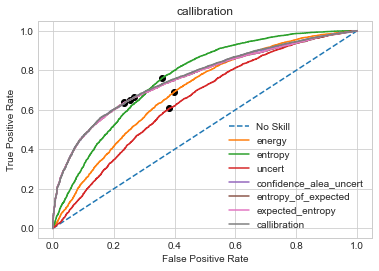

In [17]:
# threshold = calc_AUC(output_ID, metrics=['energy','uncert','expected_entropy','calibration'],plot = True)
threshold = calc_AUC(output_ID, metrics=["energy","entropy","uncert","confidence_alea_uncert","entropy_of_expected","expected_entropy","calibration"],plot = True)
#MAEB

lr_auc 0.29612755195940693
Best Threshold=-7.480616569519043, G-Mean=0.6498070813025146, TPR=0.7059282371294852, FPR=0.4018524536886578
lr_auc 0.24005162351440434
Best Threshold=0.9972052574157715, G-Mean=0.6950418578983907, TPR=0.7927717108684348, FPR=0.39064023399415015
lr_auc 0.37206364432672856
Best Threshold=0.44796812534332275, G-Mean=0.5952901008407016, TPR=0.6315652626105044, FPR=0.43890152746181343
lr_auc 0.7651199808148321
Best Threshold=0.7181436419487, G-Mean=0.7008415143051968, TPR=0.6670458238544036, FPR=0.26365054602184085
lr_auc 0.7568078446244773
Best Threshold=-0.8272647119808325, G-Mean=0.6919269077521468, TPR=0.6494962625934352, FPR=0.2628705148205928
lr_auc 0.7574571523647426
Best Threshold=-0.8330044417222909, G-Mean=0.6924701182740562, TPR=0.6542086447838804, FPR=0.2670306812272491
lr_auc 0.7660429881608655
Best Threshold=0.7298916578292847, G-Mean=0.7018544841976537, TPR=0.6711082222944427, FPR=0.265990639625585


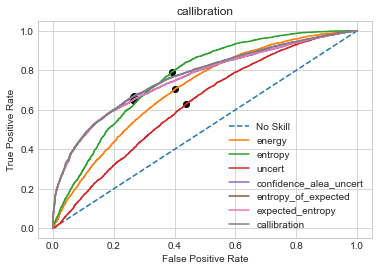

In [82]:
threshold = calc_AUC(output_ID, metrics=["energy","entropy","uncert","confidence_alea_uncert","entropy_of_expected","expected_entropy","calibration"],plot = True)
#EDL

OOD size 10000
lr_auc 0.656151925
Best Threshold=-21.352628707885742, G-Mean=0.3962403815867333, TPR=0.3394, FPR=0.5374
lr_auc 0.65798663
Best Threshold=1.6821411918499507e-05, G-Mean=0.39619328616219635, TPR=0.3472, FPR=0.5479
lr_auc 0.644239215
Best Threshold=0.4506461024284363, G-Mean=0.4022347076024147, TPR=0.3214, FPR=0.4966
lr_auc 0.37535799999999997
Best Threshold=0.9999980926513672, G-Mean=0.3929694644625712, TPR=0.426, FPR=0.6375
lr_auc 0.34221492
Best Threshold=-3.639874760966167e-05, G-Mean=0.3932804088687866, TPR=0.4324, FPR=0.6423
lr_auc 0.34184017
Best Threshold=-3.848563147968418e-05, G-Mean=0.393089760741742, TPR=0.4338, FPR=0.6438
lr_auc 0.38505431
Best Threshold=0.9999992847442627, G-Mean=0.3960258829925135, TPR=0.4525, FPR=0.6534


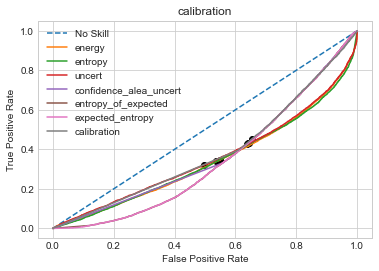

In [121]:
from sklearn.metrics import average_precision_score
from sklearn.metrics import roc_auc_score
# metrics =["energy","entropy","uncert","confidence_alea_uncert","entropy_of_expected","expected_entropy","calibration"]
# metrics =['energy','uncert','expected_entropy','calibration']

metrics = ["energy","entropy","uncert","confidence_alea_uncert","entropy_of_expected","expected_entropy","calibration"]
def calc_auc_OOD(ID,OOD,metrics=['energy'],OOD_rate=[.1,.2,.5,1], plot=False):
    points = []
    # OOD_rate = [0,.1,.2,.5,1]
    _output_ID = ID
    _output_OOD = OOD

    _output_ID["outlier"]=0
    _output_OOD["outlier"]=1
    lessThanMetrics = ["energy","uncert","entropy"]
    _thresholds = []
    for i in OOD_rate:
        # print(int(min((len(_output_ID) * i),len(_output_ID))))
        _OOD = _output_OOD.iloc[0:int(min((len(_output_ID) * i),len(_output_ID)))]
        print("OOD size",len(_OOD))
        _df = pd.concat([_output_ID,_OOD], ignore_index=True)
        y_true = np.int32(_df['outlier'])

    #     print(len(_df))
    #     for metric in metrics:
    #         points.append([])
    #         # print(metric, ":", average_precision_score(y_true, _df[metric]))

    #         Correct = _df.loc[(_df['correct'] == True)]
    #         Incorrect = _df.loc[(_df['correct'] == False)]
    #         fpr, tpr, thresholds = roc_curve(np.int32(_output_ID['correct']), _output_ID[metric],pos_label=1)
    #         gmeans = sqrt(tpr * (1-fpr))
    #         ix = argmax(gmeans)
    #         _threshold = thresholds[ix]
    #         # _threshold = np.array(Correct[metric]).mean()
        plots = []
        for metric in metrics:    
            lr_auc = roc_auc_score(y_true, _df[metric])
            print("lr_auc",lr_auc)
            if metric in lessThanMetrics:
                pos_label = 0
            else:
                pos_label = 1
            fpr, tpr, thresholds = roc_curve(y_true, _df[metric],pos_label=pos_label)
            gmeans = sqrt(tpr * (1-fpr))
            # print(gmeans)
            # locate the index of the largest g-mean
            ix = argmax(gmeans)
            threshold = thresholds[ix]
            print('Best Threshold={}, G-Mean={}, TPR={}, FPR={}'.format(threshold, gmeans[ix],tpr[ix],fpr[ix]))
            _thresholds.append(threshold)
            # plot the roc curve for the model
            plots.append({"fpr":fpr,"tpr":tpr,"label":metric, "ix":ix})
        # if plot:
        pyplot.plot([0,1], [0,1], linestyle='--', label='No Skill')
        for plot in plots:
            ix = plot['ix']
            pyplot.plot(plot["fpr"], plot["tpr"],  label=plot['label'])

            pyplot.scatter(plot["fpr"][ix], plot["tpr"][ix], marker='o', color='black')
        # axis labels
        pyplot.xlabel('False Positive Rate')
        pyplot.ylabel('True Positive Rate')
        pyplot.title(metric)
        pyplot.legend()
        # show the plot
        pyplot.show()

# calc_auc_OOD(output_ID,output_OOD_svhn,metrics=metrics,OOD_rate=[1])       

calc_auc_OOD(output_ID,output_OOD,metrics=metrics,OOD_rate=[1])       

# def calc_gmeans(output_df,metrics=['energy'],plot=False):
#     lessThanMetrics = ["energy","uncert","entropy"]
#     _thresholds = []
    
#     y_test = np.int32(output_df['correct'])
#     plots = []
#     for metric in metrics:    
#         lr_auc = roc_auc_score(y_test, output_df[metric])
#         print("lr_auc",lr_auc)
#         if metric in lessThanMetrics:
#             pos_label = 0
#         else:
#             pos_label = 1
#         fpr, tpr, thresholds = roc_curve(y_test, output_df[metric],pos_label=pos_label)
#         gmeans = sqrt(tpr * (1-fpr))
#         # print(gmeans)
#         # locate the index of the largest g-mean
#         ix = argmax(gmeans)
#         threshold = thresholds[ix]
#         print('Best Threshold={}, G-Mean={}, TPR={}, FPR={}'.format(threshold, gmeans[ix],tpr[ix],fpr[ix]))
#         _thresholds.append(threshold)
#         # plot the roc curve for the model
#         plots.append({"fpr":fpr,"tpr":tpr,"label":"metric", "ix":ix})
#     if plot:
#         pyplot.plot([0,1], [0,1], linestyle='--', label='No Skill')
#         for plot in plots:
#             ix = plot['ix']
#             pyplot.plot(plot["fpr"], plot["tpr"],  label=plot['label'])

#             pyplot.scatter(plot["fpr"][ix], plot["tpr"][ix], marker='o', color='black')
#         # axis labels
#         pyplot.xlabel('False Positive Rate')
#         pyplot.ylabel('True Positive Rate')
#         pyplot.title(metric)
#         pyplot.legend()
#         # show the plot
#         pyplot.show()
        

10000
lr_auc 0.17632298999999999
Best Threshold=-5.625901222229004, G-Mean=0.7577538320589345, TPR=0.7897, FPR=0.2729
lr_auc 0.163048365
Best Threshold=1.7985261678695679, G-Mean=0.7553904420893873, TPR=0.7592, FPR=0.2484
lr_auc 0.26289053
Best Threshold=0.45931094884872437, G-Mean=0.6940969240675253, TPR=0.7773, FPR=0.3802
lr_auc 0.83095955
Best Threshold=0.49477264285087585, G-Mean=0.7527356375248883, TPR=0.7481, FPR=0.2426
lr_auc 0.8377772299999999
Best Threshold=-1.3245874584253854, G-Mean=0.7618700217228658, TPR=0.7367, FPR=0.2121
lr_auc 0.83854707
Best Threshold=-1.3036969119965915, G-Mean=0.7614107432916875, TPR=0.7346, FPR=0.2108
lr_auc 0.8264950799999999
Best Threshold=0.5462754368782043, G-Mean=0.7462074711499478, TPR=0.7087, FPR=0.2143


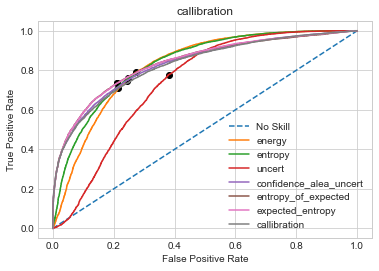

10000
lr_auc 0.3541886000000001
Best Threshold=-6.632209777832031, G-Mean=0.6040072847242821, TPR=0.6247, FPR=0.416
lr_auc 0.33489378000000003
Best Threshold=1.3389952182769775, G-Mean=0.6181435512888571, TPR=0.6535, FPR=0.4153
lr_auc 0.41053229999999996
Best Threshold=0.45440253615379333, G-Mean=0.5676407754909789, TPR=0.5759, FPR=0.4405
lr_auc 0.6552974600000001
Best Threshold=0.6583983302116394, G-Mean=0.6085316014801532, TPR=0.5677, FPR=0.3477
lr_auc 0.6647074949999999
Best Threshold=-1.0051595671170843, G-Mean=0.6170466676030266, TPR=0.5873, FPR=0.3517
lr_auc 0.6649351350000001
Best Threshold=-0.9957128697464878, G-Mean=0.6170181682900431, TPR=0.5858, FPR=0.3501
lr_auc 0.652951265
Best Threshold=0.7174296975135803, G-Mean=0.6068091627521787, TPR=0.5292, FPR=0.3042


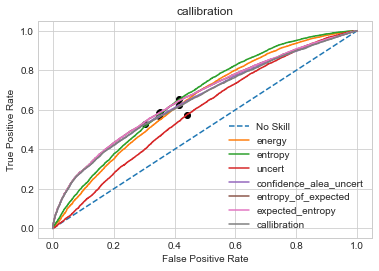

In [81]:
calc_auc_OOD(output_ID,output_OOD_svhn,metrics=metrics,OOD_rate=[1])       


calc_auc_OOD(output_ID,output_OOD,metrics=metrics,OOD_rate=[1])       

In [46]:
from sklearn.metrics import average_precision_score
from sklearn.metrics import roc_auc_score
metrics =["energy","entropy","uncert","confidence_alea_uncert","entropy_of_expected","expected_entropy","calibration"]
metrics =["energy","entropy","calibration"]
points = []

OOD_rate = [0,.1,.2,.5,1]

_output_ID = output_ID
_output_OOD = output_OOD

_output_ID["outlier"]=0
_output_OOD["outlier"]=1
lessThanMetrics = ["energy","uncert","entropy"]
for i in OOD_rate:
    print(int(min((len(_output_ID) * i),len(_output_ID))))
    _OOD = _output_OOD.iloc[0:int(min((len(_output_ID) * i),len(_output_ID)))]
    _df = pd.concat([_output_ID,_OOD], ignore_index=True)
    y_true = np.int32(_df['outlier'])
    
    print(len(_df))
    for metric in metrics:
        points.append([])
        # print(metric, ":", average_precision_score(y_true, _df[metric]))
        
        Correct = _df.loc[(_df['correct'] == True)]
        Incorrect = _df.loc[(_df['correct'] == False)]
        fpr, tpr, thresholds = roc_curve(np.int32(_output_ID['correct']), _output_ID[metric],pos_label=1)
        gmeans = sqrt(tpr * (1-fpr))
        ix = argmax(gmeans)
        _threshold = thresholds[ix]
        # _threshold = np.array(Correct[metric]).mean()
        if metric in lessThanMetrics:
            accepted = _df.loc[(_df[metric] <= _threshold)] #TP
            accepted_OOD = accepted.loc[(accepted['outlier'] == 1)]
            accepted_ID = accepted.loc[(accepted['outlier'] == 0)] 
            accepted_correct = Correct.loc[(Correct[metric] <= _threshold)] #TP
            rejected_correct = Correct.loc[(Correct[metric] > _threshold)]  #FN

            accepted_incorrect = Incorrect.loc[(Incorrect[metric] <= _threshold)] #FP
            rejected_incorrect = Incorrect.loc[(Incorrect[metric] > _threshold)] #TN
            # print(metric, ":", len(Correct)/len(_df), "accepted_acc", len(accepted_correct)/len(accepted))
        else:
            accepted = _df.loc[(_df[metric] >= _threshold)] #TP
            accepted_OOD = accepted.loc[(accepted['outlier'] == 1)] #TP
            accepted_ID = accepted.loc[(accepted['outlier'] == 0)] 
            accepted_correct = Correct.loc[(Correct[metric] >= _threshold)] #TP
            rejected_correct = Correct.loc[(Correct[metric] < _threshold)]  #FN

            accepted_incorrect = Incorrect.loc[(Incorrect[metric] >= _threshold)] #FP
            rejected_incorrect = Incorrect.loc[(Incorrect[metric] < _threshold)] #TN
        try:
            ODD_accept = len(accepted_OOD)/len(_OOD)
        except:
            ODD_accept ="NAN"
        np.seterr(invalid='ignore')
        AUC_PR_OOD = average_precision_score(np.int32(accepted['outlier']), accepted[metric])
        AUC_ROC = roc_auc_score(np.int32(accepted['correct']), accepted[metric])
        AUC_PR = average_precision_score(np.int32(accepted['correct']), accepted[metric])
        FPR = len(accepted_incorrect) / (len(accepted_incorrect) + len(rejected_incorrect))
        print(metric,":",len(accepted_ID)/len(_output_ID),":",ODD_accept, ":", len(accepted_correct)/len(accepted), ":FPR:",FPR,":AUC_PR(T/F):",AUC_PR,":AUC_ROC:",AUC_ROC)


0
10000
energy : 0.5996 : NAN : 0.7198132088058706 :FPR: 0.4384133611691023 :AUC_PR(T/F): 0.6245638987195575 :AUC_ROC: 0.3303461097135796
entropy : 0.5763 : NAN : 0.7666146104459483 :FPR: 0.3509916492693111 :AUC_PR(T/F): 0.6477462359394405 :AUC_ROC: 0.25846595795167115
calibration : 0.5131 : NAN : 0.7998440849736893 :FPR: 0.2680062630480167 :AUC_PR(T/F): 0.9133633355608572 :AUC_ROC: 0.7249858119278505
1000
11000
energy : 0.5996 : 0.412 : 0.6735330836454432 :FPR: 0.4329470198675497 :AUC_PR(T/F): 0.5706115701137225 :AUC_ROC: 0.32503273869119664
entropy : 0.5763 : 0.344 : 0.7234321270672999 :FPR: 0.34954470198675497 :AUC_PR(T/F): 0.5999034689406928 :AUC_ROC: 0.26439191519916505
calibration : 0.5131 : 0.288 : 0.7573353017161838 :FPR: 0.2721440397350993 :AUC_PR(T/F): 0.8915049540682882 :AUC_ROC: 0.7213421571461396
2000
12000
energy : 0.5996 : 0.409 : 0.6334018197828001 :FPR: 0.4283264746227709 :AUC_PR(T/F): 0.5270595868474839 :AUC_ROC: 0.3237112396126354
entropy : 0.5763 : 0.342 : 0.6852799

0
10000
Best Threshold=-1.9426160284718987, G-Mean=0.82936722867497, Recall=1.0, Precision=0.37573757375737576


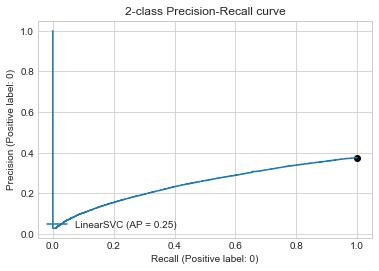

1000
11000
Best Threshold=-1.9430203248942899, G-Mean=0.82936722867497, Recall=1.0, Precision=0.4324545454545455


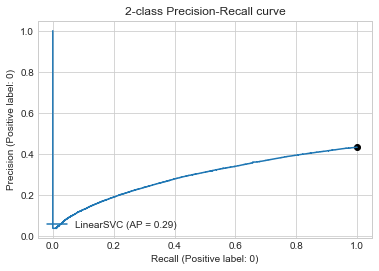

2000
12000
Best Threshold=-1.9433633677794055, G-Mean=0.82936722867497, Recall=1.0, Precision=0.47975


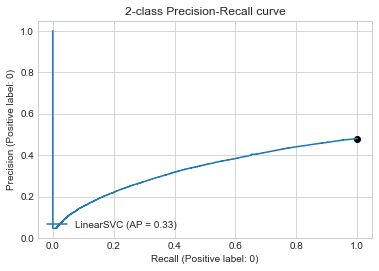

5000
15000
Best Threshold=-1.9433633677794055, G-Mean=0.82936722867497, Recall=1.0, Precision=0.5838


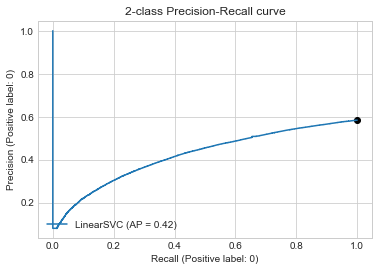

10000
20000
Best Threshold=-1.9433633677794055, G-Mean=0.82936722867497, Recall=1.0, Precision=0.68785


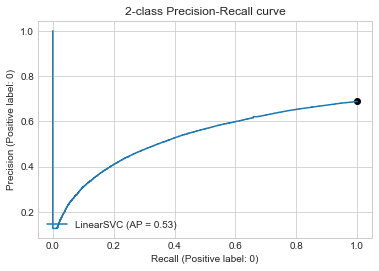

In [256]:
from sklearn.metrics import average_precision_score

metrics =["energy","entropy","uncert","confidence_alea_uncert","entropy_of_expected","expected_entropy"]
metrics =["expected_entropy"]
points = []

OOD_rate = [0,.1,.2,.5,1]

_output_ID = output_ID
_output_OOD = output_OOD

_output_ID["outlier"]=1
_output_OOD["outlier"]=0
for i in OOD_rate:
    print(int(min((len(_output_ID) * i),len(_output_ID))))
    _OOD = _output_OOD.iloc[0:int(min((len(_output_ID) * i),len(_output_ID)))]
    _df = pd.concat([_output_ID,_OOD], ignore_index=True)
    y_true = np.int32(_df['outlier'])
    
    print(len(_df))
    for metric in metrics:
        points.append([])
        # calc_aucpr(_df,plot=True)
        precision, recall, thresholds = precision_recall_curve(np.int32(_df['correct']), _df[metric],pos_label =0)
        gmeans = sqrt(tpr * (1-fpr))
        # print(gmeans)
        # locate the index of the largest g-mean
        ix = argmax(gmeans)
        threshold = thresholds[ix]
        print('Best Threshold={}, G-Mean={}, Recall={}, Precision={}'.format(threshold, gmeans[ix],recall[ix],precision[ix]))
        
        display = PrecisionRecallDisplay.from_predictions( np.int32(_df['correct']), _df[metric], name="LinearSVC",pos_label =0 )
        _ = display.ax_.set_title("2-class Precision-Recall curve") 
        pyplot.scatter(recall[ix], precision[ix], marker='o', color='black', label='Best')
        plt.show()
        # Correct = _df.loc[(_df['correct'] == True)]
        # Incorrect = _df.loc[(_df['correct'] == False)]
        # print(metric, ":", len(Correct)/len(_df))

        


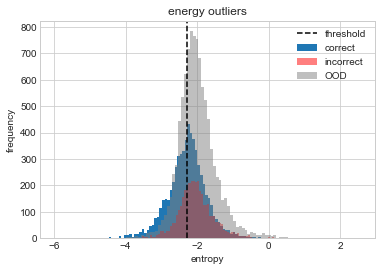

OOD accepted: 2780 : with threshold: -2.2853544
ID accepted: 4042 :with acc: 0.735526966848095
overall Accepted acc: 0.43579595426561124
TPR_ID-OOD 0.4042
TPR_acc 0.47820492198809716
FPR_ID-OOD 0.278
FPR_acc 0.2825799629923341


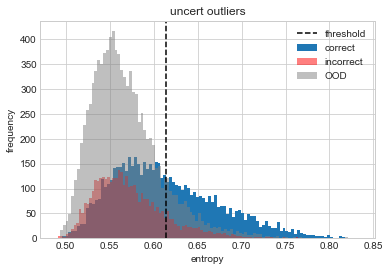

OOD accepted: 8740 : with threshold: 0.61375415
ID accepted: 6719 :with acc: 0.5194225331150469
overall Accepted acc: 0.22575845785626497
TPR_ID-OOD 0.6719
TPR_acc 0.5613640019301914
FPR_ID-OOD 0.874
FPR_acc 0.8535553793285752


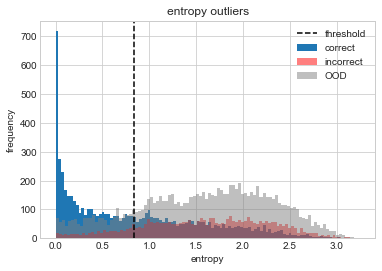

OOD accepted: 1767 : with threshold: 0.83682126
ID accepted: 4076 :with acc: 0.8626104023552502
overall Accepted acc: 0.6017456785897656
TPR_ID-OOD 0.4076
TPR_acc 0.5655460833199292
FPR_ID-OOD 0.1767
FPR_acc 0.14803066349458102


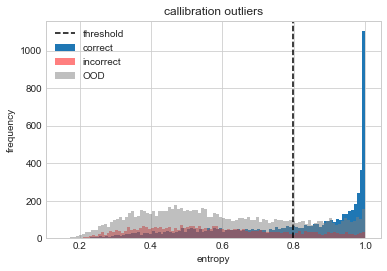

OOD accepted: 2215 : with threshold: 0.79617167
ID accepted: 4416 :with acc: 0.845108695652174
overall Accepted acc: 0.5628110390589655
TPR_ID-OOD 0.4416
TPR_acc 0.6002895287115972
FPR_ID-OOD 0.2215
FPR_acc 0.18080888183980967


In [35]:
buildCompareDistribPlot(output_ID, output_OOD, ["energy",'uncert','entropy','calibration'], "mean")

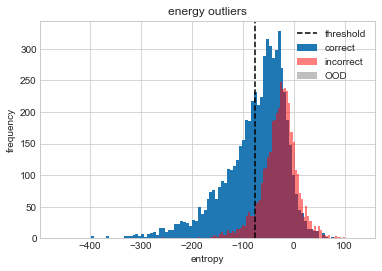

OOD accepted: 0 : with threshold: -76.06987
ID accepted: 2802 :with acc: 0.8790149892933619
overall Accepted acc: 0.8790149892933619
TPR_ID-OOD 0.2802
TPR_acc 0.4071747396263845
FPR for OOD is div by zero, was OOD included?
FPR_acc 0.08580106302201974


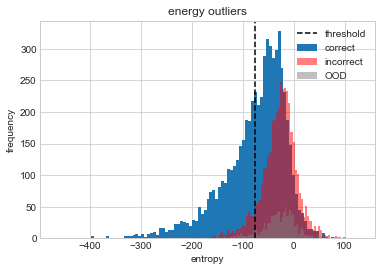

OOD accepted: 94 : with threshold: -76.06987
ID accepted: 2802 :with acc: 0.8790149892933619
overall Accepted acc: 0.8504834254143646
TPR_ID-OOD 0.2802
TPR_acc 0.4071747396263845
FPR_ID-OOD 0.094
FPR_acc 0.08580106302201974


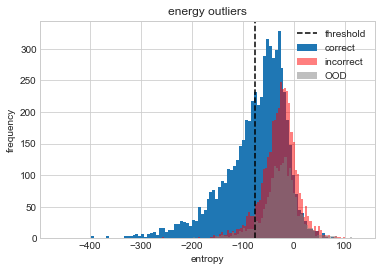

OOD accepted: 173 : with threshold: -76.06987
ID accepted: 2802 :with acc: 0.8790149892933619
overall Accepted acc: 0.8278991596638655
TPR_ID-OOD 0.2802
TPR_acc 0.4071747396263845
FPR_ID-OOD 0.0865
FPR_acc 0.08580106302201974


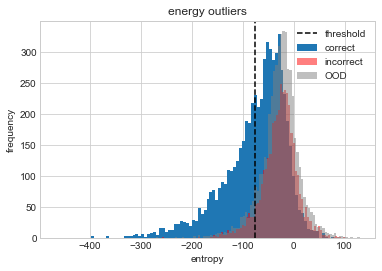

OOD accepted: 455 : with threshold: -76.06987
ID accepted: 2802 :with acc: 0.8790149892933619
overall Accepted acc: 0.7562173779551735
TPR_ID-OOD 0.2802
TPR_acc 0.4071747396263845
FPR_ID-OOD 0.091
FPR_acc 0.08580106302201974


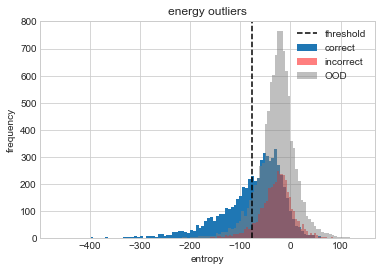

OOD accepted: 904 : with threshold: -76.06987
ID accepted: 2802 :with acc: 0.8790149892933619
overall Accepted acc: 0.6645979492714517
TPR_ID-OOD 0.2802
TPR_acc 0.4071747396263845
FPR_ID-OOD 0.0904
FPR_acc 0.08580106302201974


In [97]:
# buildCompareDistribPlot(output_ID, output_OOD, ["energy",'uncert','entropy'], "mean")

# buildCompareDistribPlot(output_ID, output_OOD, ["energy","entropy","uncert","confidence_alea_uncert","entropy_of_expected","expected_entropy"], threshold = "gmean")
# buildCompareDistribPlot(output_ID, output_OOD, ["energy","energy"], threshold = [-25.654110,"mean",-1.9786984131020736e-08])
buildCompareDistribPlot(output_ID, output_OOD.iloc[0:0], ["energy"],"mean")# threshold = [-25.654110,"mean",-320.76513671875])
buildCompareDistribPlot(output_ID, output_OOD.iloc[0:1000], ["energy"],"mean")# threshold = [-25.654110,"mean",-320.76513671875])
buildCompareDistribPlot(output_ID, output_OOD.iloc[0:2000], ["energy"],"mean")# threshold = [-25.654110,"mean",-320.76513671875])
buildCompareDistribPlot(output_ID, output_OOD.iloc[0:5000], ["energy"],"mean")# threshold = [-25.654110,"mean",-320.76513671875])
buildCompareDistribPlot(output_ID, output_OOD.iloc[0:10000], ["energy"],"mean")# threshold = [-25.654110,"mean",-320.76513671875])



In [315]:
def buildCompareDistribPlot2(ID,OOD=None,metrics=["energy"], threshold=None, legend=["In Distribution","Out of Distribution"]):
        lessThanMetrics = ["energy","uncert","entropy"]
        if type(metrics ) is not list:
            metrics = [metrics]
        OOD_rate = [0,.1,.2,.5,1]
        throughput_acc= []
        for val in OOD_rate:
            print(int(min((len(_output_ID) * val),len(_output_ID))))
            OOD = OOD.iloc[0:int(min((len(ID) * val),len(ID)))]
            # _df = pd.concat([_output_ID,_OOD], ignore_index=True)
            # y_true = np.int32(_df['outlier'])
            for i, metric in enumerate(metrics):
                throughput_acc.append([])
                # _ = plt.hist(ID[metric].tolist(), bins=100)  # arguments are passed to np.histogram
                legend = ["threshold","correct","incorrect", "OOD"]
                Correct = ID.loc[(ID['correct'] == True)]
                Incorrect = ID.loc[(ID['correct'] == False)]
                # _ = plt.hist(Correct[metric].tolist(), bins=100)  # arguments are passed to np.histogram
                # _ = plt.hist(Incorrect[metric].tolist(), bins=100,color ="red", alpha = 0.5)  # arguments are passed to np.histogram
                # if OOD is None:
                #     OOD = pd.DataFrame(columns=ID.columns)
                # _ = plt.hist(OOD[metric].tolist(), bins=100,color="grey",alpha=0.5)  # arguments are passed to np.histogram
                # plt.title("Histogram with 'auto' bins")


                if threshold:
                    if type(threshold) is list:
                        if i >= len(threshold): #no threshold in the array so treat as None.
                            continue
                        _threshold = threshold[i]
                    else:
                        _threshold = threshold
                    if _threshold == "mean":
                        # _threshold = np.array(ID[metric]).mean()
                        _threshold = np.array(Correct[metric]).mean()
                    if _threshold == "gmean":
                        # _threshold = np.array(ID[metric]).mean()
                        fpr, tpr, thresholds = roc_curve(np.int32(ID['correct']), ID[metric],pos_label=0)
                        gmeans = sqrt(tpr * (1-fpr))
                        ix = argmax(gmeans)
                        _threshold = thresholds[ix]
                    else:
                        _threshold = np.float32(_threshold)
                    # plt.axvline(x=_threshold, color='k', linestyle='--',label="threshold")
                    # plt.title(metric + " outliers")
                    # plt.legend(legend)
                    # plt.xlabel("entropy")
                    # plt.ylabel("frequency")
                    # plt.show()
                    if metric in lessThanMetrics: ## metrics that require less than metric
                        OOD_accepted = OOD.loc[(OOD[metric].tolist() <= _threshold)] #FP
                        OOD_rejected = OOD.loc[(OOD[metric].tolist() > _threshold)] #TN
                        ID_accepted = ID.loc[(ID[metric] <= _threshold)] #TP
                        ID_rejected = ID.loc[(ID[metric] > _threshold)] #FN


                        accepted_correct = Correct.loc[(Correct[metric] <= _threshold)] #TP
                        rejected_correct = Correct.loc[(Correct[metric] > _threshold)]  #FN

                        accepted_incorrect = Incorrect.loc[(Incorrect[metric] <= _threshold)] #FP
                        rejected_incorrect = Incorrect.loc[(Incorrect[metric] > _threshold)] #TN

                        accepted_ID_acc = len(accepted_correct) / (len( ID_accepted))
                        overall_accepted_acc = len(accepted_correct) / (len( ID_accepted) + len(OOD_accepted))
                        print("OOD accepted:", len(OOD_accepted),": with threshold:",_threshold )
                        print("ID accepted:", len(ID_accepted), ":with acc:",(accepted_ID_acc))
                        print("overall Accepted acc:",(overall_accepted_acc))

                        # print("OOD accepted with avg ID ",metric," threshold of ",_threshold, ": ", len(OOD.loc[(OOD[metric].tolist() <= _threshold)]), "out of ", len(OOD))
                        # print("ID accepted with avg ID ",metric," threshold of ",_threshold, ": ", len(ID.loc[(ID[metric] <= _threshold)]), "out of ", len(ID), "with acc of ", len(ID.loc[(ID[metric] <= _threshold) & ID['correct'] == True])/len(ID.loc[(ID[metric] <= _threshold)]))
                        # print("Overall accuracy of accepted inputs:", len(ID.loc[(ID[metric] <= _threshold) & ID['correct'] == True])/(len(ID.loc[(ID[metric] <= _threshold)])+len(OOD.loc[(OOD[metric] <= _threshold)])))
                    else: ### metrics that require greater than metric
                        OOD_accepted = OOD.loc[(OOD[metric].tolist() >= _threshold)] #FP
                        OOD_rejected = OOD.loc[(OOD[metric].tolist() < _threshold)] #TN
                        ID_accepted = ID.loc[(ID[metric] >= _threshold)] #TP
                        ID_rejected = ID.loc[(ID[metric] < _threshold)] #FN

                        accepted_correct = Correct.loc[(Correct[metric] >= _threshold)] #TP
                        rejected_correct = Correct.loc[(Correct[metric] < _threshold)]  #FN

                        accepted_incorrect = Incorrect.loc[(Incorrect[metric] >= _threshold)] #FP
                        rejected_incorrect = Incorrect.loc[(Incorrect[metric] < _threshold)] #TN



                        accepted_ID_acc = len(accepted_correct) / (len( ID_accepted))
                        overall_accepted_acc = len(accepted_correct) / (len( ID_accepted) + len(OOD_accepted))
                        print("OOD accepted:", len(OOD_accepted),": with threshold:",_threshold )
                        print("ID accepted:", len(ID_accepted), ":with acc:",(accepted_ID_acc))
                        print("overall Accepted acc:",(overall_accepted_acc))

                        # print("OOD accepted with avg ID ",metric," threshold of ",_threshold, ": ", len(OOD.loc[(OOD[metric].tolist() >= _threshold)]), "out of ", len(OOD))
                        # print("ID accepted with avg ID ",metric," threshold of ",_threshold, ": ", len(ID.loc[(ID[metric] >= _threshold)]), "out of ", len(ID), "with acc of ", len(ID.loc[(ID[metric] >= _threshold) & ID['correct'] == True])/len(ID.loc[(ID[metric] >= _threshold)]))
                        # print("Overall accuracy of accepted inputs:", len(ID.loc[(ID[metric] <= _threshold) & ID['correct'] == True])/(len(ID.loc[(ID[metric] >= _threshold)])+len(OOD.loc[(OOD[metric] >= _threshold)])))

                    print("TPR_ID-OOD",len(ID_accepted)/(len(ID_accepted) + len(ID_rejected)))
                    print("TPR_acc",len(accepted_correct)/(len(accepted_correct) + len(rejected_correct)))
                    if len(OOD) > 0:
                        print("FPR_ID-OOD",len(OOD_accepted)/(len(OOD_accepted) + len(OOD_rejected)))
                    else: 
                        print("FPR for OOD is div by zero, was OOD included?")
                    print("FPR_acc",len(accepted_incorrect)/(len(accepted_incorrect) + len(rejected_incorrect)))
                    throughput_acc[i].append(overall_accepted_acc)
        print(throughput_acc)
        # for throughput in throughput_acc:
            # plt.plot(OOD_rate,throughput)

** CE RESULTS ** <hr>

In [316]:
# buildCompareDistribPlot(output_ID, output_OOD, ["energy",'uncert','entropy'], "mean")

buildCompareDistribPlot2(output_ID, output_OOD, ["energy","entropy","uncert","confidence_alea_uncert","entropy_of_expected","expected_entropy"], "mean")

0
OOD accepted: 0 : with threshold: -54.0084
ID accepted: 2805 :with acc: 0.9258467023172906
overall Accepted acc: 0.9258467023172906
TPR_ID-OOD 0.2805
TPR_acc 0.41598590421271825
FPR for OOD is div by zero, was OOD included?
FPR_acc 0.05536332179930796
OOD accepted: 0 : with threshold: 0.018136319
ID accepted: 9084 :with acc: 0.658300308234258
overall Accepted acc: 0.658300308234258
TPR_ID-OOD 0.9084
TPR_acc 0.9578728175556623
FPR for OOD is div by zero, was OOD included?
FPR_acc 0.8261911099281342
OOD accepted: 0 : with threshold: 0.3000143
ID accepted: 4458 :with acc: 0.8582323912068192
overall Accepted acc: 0.8582323912068192
TPR_ID-OOD 0.4458
TPR_acc 0.6128463879545091
FPR for OOD is div by zero, was OOD included?
FPR_acc 0.16821932392866648
OOD accepted: 0 : with threshold: 0.8975615
ID accepted: 7468 :with acc: 0.723888591322978
overall Accepted acc: 0.723888591322978
TPR_ID-OOD 0.7468
TPR_acc 0.865929841422393
FPR for OOD is div by zero, was OOD included?
FPR_acc 0.548842161298

** EDL Results ** <hr>

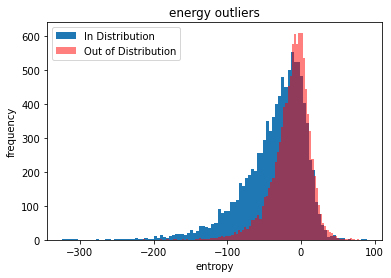

OOD accepted with avg ID  energy  threshold of  -35.58012602272332 :  1560 out of  10000
ID accepted with avg ID  energy  threshold of  -35.58012602272332 :  4085 out of  10000 with acc of  0.8832313341493268
Overall accuracy of accepted inputs: 0.6391496899911426
overall acc on ID: 0.6408


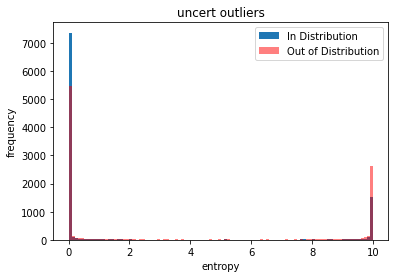

OOD accepted with avg ID  uncert  threshold of  2.0591965 :  6119 out of  10000
ID accepted with avg ID  uncert  threshold of  2.0591965 :  7778 out of  10000 with acc of  0.7247364361018257
Overall accuracy of accepted inputs: 0.40562711376556093
overall acc on ID: 0.6408


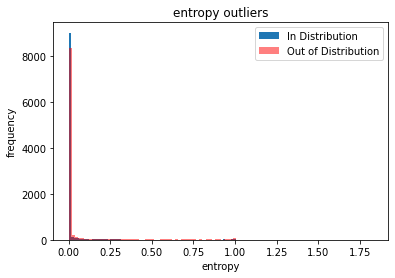

OOD accepted with avg ID  entropy  threshold of  0.03707295 :  8571 out of  10000
ID accepted with avg ID  entropy  threshold of  0.03707295 :  9176 out of  10000 with acc of  0.6705536181342633
Overall accuracy of accepted inputs: 0.34670648560320055
overall acc on ID: 0.6408


In [43]:


energy_threshold = np.array(output_ID['energy']).mean()#+ output_ID['energy'].std()
edl_threshold = output_ID['uncert'].mean() #+ output_ID['uncert'].std()
entropy_threshold = output_ID['entropy'].mean() #+ output_ID['entropy'].std()

buildCompareDistribPlot(output_ID, output_OOD, ["energy",'uncert','entropy'], "mean")
# buildCompareDistribPlot(output_ID, output_OOD, "uncert", edl_threshold)
# buildOutlierPlot_multi(output_ID, output_OOD, "entropy", entropy_threshold)

In [38]:
# print(remade_ood_scores(test_ds,stopping_point=10).mean())
# output = getPredictions_Energy(model, test_ds,stopping_point=None)
output = output_ID
Correct = output.loc[output['correct']==True]
Incorrect = output.loc[output['correct']==False]
print(len(Correct))
print(len(Incorrect))


6330
3654


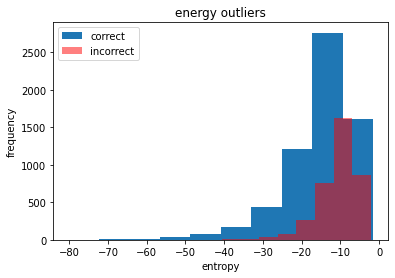

OOD accepted with avg ID  energy  threshold of  -15.44441713751963 :  523 out of  3654
ID accepted with avg ID  energy  threshold of  -15.44441713751963 :  2463 out of  6330 with acc of  1.0
Overall accuracy of accepted inputs: 0.8248492967180174
overall acc on ID: 1.0


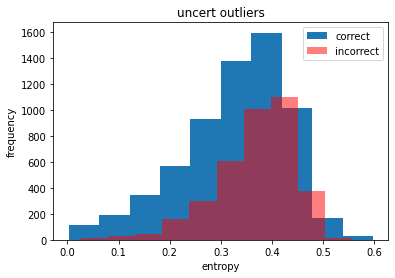

OOD accepted with avg ID  uncert  threshold of  0.32769838 :  929 out of  3654
ID accepted with avg ID  uncert  threshold of  0.32769838 :  2762 out of  6330 with acc of  1.0
Overall accuracy of accepted inputs: 0.7483066919534002
overall acc on ID: 1.0


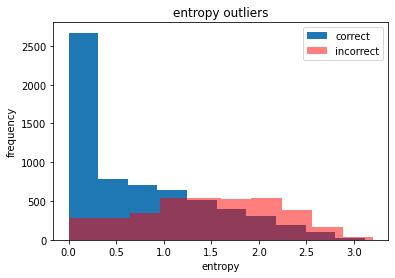

OOD accepted with avg ID  entropy  threshold of  0.72378 :  638 out of  3654
ID accepted with avg ID  entropy  threshold of  0.72378 :  3695 out of  6330 with acc of  1.0
Overall accuracy of accepted inputs: 0.8527579044541888
overall acc on ID: 1.0


In [39]:
### CE

### ID, correct vs incorrect distributions.
buildCompareDistribPlot(Correct, Incorrect, ["energy",'uncert','entropy'], "mean",legend=["correct","incorrect"])

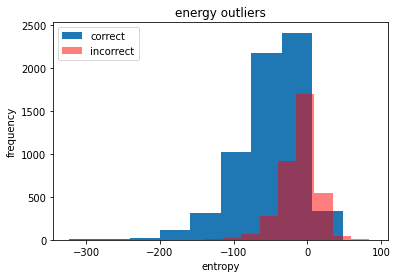

OOD accepted with avg ID  energy  threshold of  -49.36437512047334 :  219 out of  3585
ID accepted with avg ID  energy  threshold of  -49.36437512047334 :  2729 out of  6399 with acc of  1.0
Overall accuracy of accepted inputs: 0.9257123473541384
overall acc on ID: 1.0


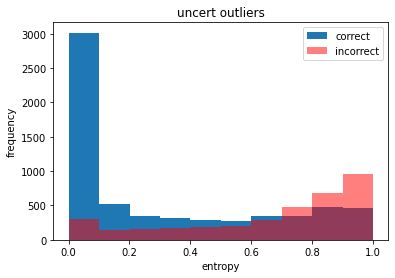

OOD accepted with avg ID  uncert  threshold of  0.30378383 :  616 out of  3585
ID accepted with avg ID  uncert  threshold of  0.30378383 :  3891 out of  6399 with acc of  1.0
Overall accuracy of accepted inputs: 0.8633237186598625
overall acc on ID: 1.0


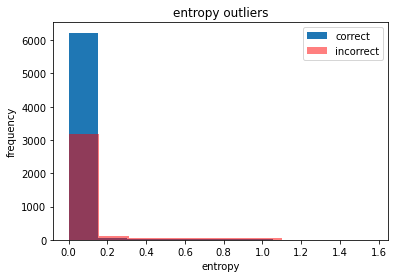

OOD accepted with avg ID  entropy  threshold of  0.01742948 :  2923 out of  3585
ID accepted with avg ID  entropy  threshold of  0.01742948 :  6097 out of  6399 with acc of  1.0
Overall accuracy of accepted inputs: 0.6759423503325942
overall acc on ID: 1.0


In [19]:
### EDL

### ID, correct vs incorrect distributions.
buildCompareDistribPlot(Correct, Incorrect, ["energy",'uncert','entropy'], "mean",legend=["correct","incorrect"])

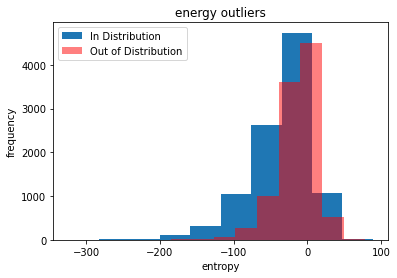

OOD accepted with avg ID  energy  threshold of  -35.59758201863709 :  1555 out of  9984
ID accepted with avg ID  energy  threshold of  -35.59758201863709 :  4079 out of  9984 with acc of  0.883304731551851
Overall accuracy of accepted inputs: 0.6395101171458999
overall acc on ID: 0.6409254807692307


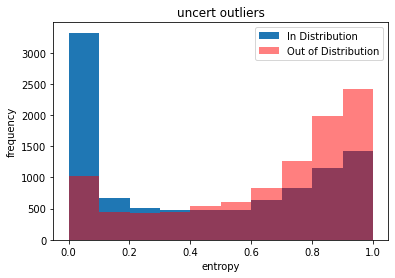

OOD accepted with avg ID  uncert  threshold of  0.43300316 :  2524 out of  9984
ID accepted with avg ID  uncert  threshold of  0.43300316 :  5139 out of  9984 with acc of  0.8355711227865343
Overall accuracy of accepted inputs: 0.5603549523685241
overall acc on ID: 0.6409254807692307


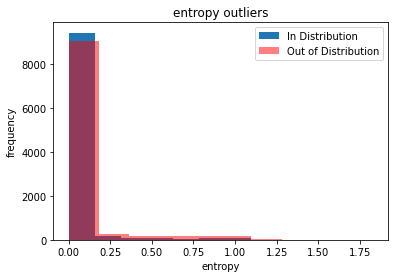

OOD accepted with avg ID  entropy  threshold of  0.036932714 :  8556 out of  9984
ID accepted with avg ID  entropy  threshold of  0.036932714 :  9161 out of  9984 with acc of  0.67066914092348
Overall accuracy of accepted inputs: 0.34678557317830333
overall acc on ID: 0.6409254807692307


In [16]:
def buildCompareDistribPlot_increasing(ID,OOD,metrics=["energy"], threshold=None, legend=["In Distribution","Out of Distribution"]):
        if type(metrics ) is not list:
                metrics = [metrics]
        for i, metric in enumerate(metrics):
            _ = plt.hist(ID[metric].tolist(), bins=10)  # arguments are passed to np.histogram
            _ = plt.hist(OOD[metric].tolist(), bins=10,color="red",alpha=0.5)  # arguments are passed to np.histogram
            # plt.title("Histogram with 'auto' bins")
            plt.title(metric + " outliers")
            plt.legend(legend)
            plt.xlabel("entropy")
            plt.ylabel("frequency")
            plt.show()
            if threshold:
                if type(threshold) is list:
                    if i >= len(threshold): #no threshold in the array so treat as None.
                        continue
                    _threshold = threshold[i]
                else:
                    _threshold = threshold
                if _threshold == "mean":
                    _threshold = np.array(ID[metric]).mean()
                print("OOD accepted with avg ID ",metric," threshold of ",_threshold, ": ", len(OOD.loc[(OOD[metric].tolist() <= _threshold)]), "out of ", len(OOD))
                print("ID accepted with avg ID ",metric," threshold of ",_threshold, ": ", len(ID.loc[(ID[metric] <= _threshold)]), "out of ", len(ID), "with acc of ", len(ID.loc[(ID[metric] <= _threshold) & ID['correct'] == True])/len(ID.loc[(ID[metric] <= _threshold)]))
                Correct = ID.loc[(ID['correct'] == True)]
                Incorrect = ID.loc[(ID['correct'] == False)]
                print("overall acc on ID:",len(Correct)/len(ID))

energy_threshold = np.array(output_ID['energy']).mean()#+ output_ID['energy'].std()
edl_threshold = output_ID['uncert'].mean() #+ output_ID['uncert'].std()
entropy_threshold = output_ID['entropy'].mean() #+ output_ID['entropy'].std()

buildCompareDistribPlot(output_ID, output_OOD, ["energy",'uncert','entropy'], "mean")
# buildCompareDistribPlot(output_ID, output_OOD, "uncert", edl_threshold)
# buildOutlierPlot_multi(output_ID, output_OOD, "entropy", entropy_threshold)

-13.265087624612557


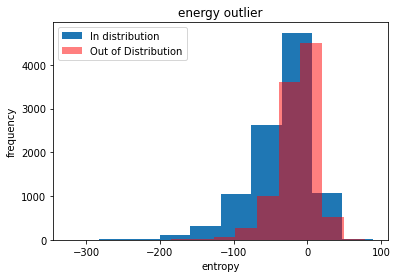

OOD accepted with avg ID entropy threshold of  -13.265087624612557 :  4201 out of  9984
ID accepted with avg ID entropy threshold of  -13.265087624612557 :  6518 out of  9984 with acc of  0.7821417612764652
overall acc on ID: 0.6409254807692307


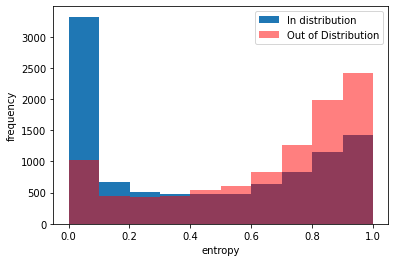

OOD accepted with avg ID entropy threshold of  0.6440355 :  3811 out of  9984
ID accepted with avg ID entropy threshold of  0.6440355 :  6209 out of  9984 with acc of  0.7935255274601385
overall acc on ID: 0.6409254807692307


In [286]:

energy_threshold = np.array(output_OOD['energy']).mean()
print(energy_threshold)
buildOutlierPlot_energy_2(output_ID, output_OOD, energy_threshold)

edl_threshold = output_OOD['uncert'].mean()
buildOutlierPlot(output_ID, output_OOD, edl_threshold)

In [19]:
def buildOutlierPlot_multi(ID,OOD,metrics=["energy"], threshold=None, legend=["In Distribution","Out of Distribution"]):
    # for k in ['confidence_alea_uncert.','entropy_of_expected','expected_entropy','mutual_information','EPKL','differential_entropy']:
        # _ = plt.hist(ID[k].tolist(), bins=10)  # arguments are passed to np.histogram
        # _ = plt.hist(OOD[k].tolist(), bins=10,color="red",alpha=0.5)  # arguments are passed to np.histogram
        plots = []
        points=[]
        if type(metrics ) is not list:
            metrics = [metrics]
            
        for i, metric in enumerate(metrics):
            accuracy = []
            percents = []
            if threshold:
                if type(threshold) is list:
                    if i >= len(threshold): #no threshold in the array so treat as None.
                        continue
                    _threshold = threshold[i]
                else:
                    _threshold = threshold
                if _threshold == "mean":
                    _threshold = np.array(ID[metric]).mean()
                    
            for i in range(11):
                # _OOD = OOD[]
                percent = i / 10
                # print(percent)
                OOD_size = int(len(OOD) * percent)
                _OOD = OOD.head(OOD_size)

                # _ = plt.hist(ID["energy"].tolist(), bins=10)  # arguments are passed to np.histogram
                # _ = plt.hist(_OOD["energy"].tolist(), bins=10,color="red",alpha=0.5)  # arguments are passed to np.histogram
                # plt.title("Histogram with 'auto' bins")
                Correct = (ID.loc[(ID[metric] <= _threshold) & ID['correct'] == True])/len(ID.loc[(ID[metric] <= _threshold)])
                total_inputs = len(ID) + len(_OOD)
                
                # print(len(Correct), len(Correct) / total_inputs)
                
                # Incorrect = ID.loc[(ID['correct'] == False)]
                
                # Correct = ID.loc[(ID['correct'] == True)]
                Incorrect = ID.loc[(ID['correct'] == False)]

                percents.append(percent/2)
                accuracy.append(len(Correct) / total_inputs)
            plots.append(accuracy)
            points.append(percents)



        # title ="{0:.2f}".format(percent)
        # print(plots)
        for i, plot in enumerate(plots):
            plt.plot(points[i],plot,marker = 'o')
        plt.title("outliers")
        plt.legend(metrics)
        plt.xlabel("Outlier percentage")
        plt.ylabel("Accuracy")
        plt.show()

#         print("OOD accepted with avg ID ",metric," threshold of ",_threshold, ": ", len(OOD.loc[(OOD[metric].tolist() <= _threshold)]), "out of ", len(OOD))
#         print("ID accepted with avg ID ",metric," threshold of ",_threshold, ": ", len(ID.loc[(ID[metric] <= _threshold)]), "out of ", len(ID), "with acc of ", len(ID.loc[(ID[metric] <= _threshold) & ID['correct'] == True])/len(ID.loc[(ID[metric] <= _threshold)]))
#         Correct = ID.loc[(ID['correct'] == True)]
#         Incorrect = ID.loc[(ID['correct'] == False)]
#         print("overall acc on ID:",len(Correct)/len(ID))

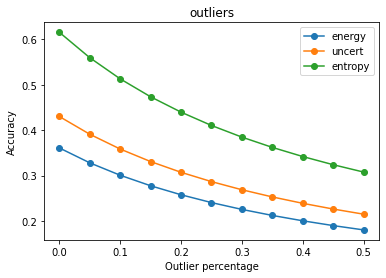

In [20]:
multiplot = buildOutlierPlot_multi(output_ID, output_OOD,metrics=["energy",'uncert','entropy'], threshold="mean")

In [36]:
def buildOutlierPlot_AUC(ID,OOD,metrics=["energy"], threshold=None, legend=["In Distribution","Out of Distribution"]):
    # for k in ['confidence_alea_uncert.','entropy_of_expected','expected_entropy','mutual_information','EPKL','differential_entropy']:
        # _ = plt.hist(ID[k].tolist(), bins=10)  # arguments are passed to np.histogram
        # _ = plt.hist(OOD[k].tolist(), bins=10,color="red",alpha=0.5)  # arguments are passed to np.histogram
        plots = []
        points=[]
        if type(metrics ) is not list:
            metrics = [metrics]
            
        for i, metric in enumerate(metrics):
            accuracy = []
            percents = []
            if threshold:
                if type(threshold) is list:
                    if i >= len(threshold): #no threshold in the array so treat as None.
                        continue
                    _threshold = threshold[i]
                else:
                    _threshold = threshold
                if _threshold == "mean":
                    _threshold = np.array(ID[metric]).mean()
                    
            for i in range(11):
                # _OOD = OOD[]
                percent = i / 10
                # print(percent)
                OOD_size = int(len(OOD) * percent)
                _OOD = OOD.head(OOD_size)

                # _ = plt.hist(ID["energy"].tolist(), bins=10)  # arguments are passed to np.histogram
                # _ = plt.hist(_OOD["energy"].tolist(), bins=10,color="red",alpha=0.5)  # arguments are passed to np.histogram
                # plt.title("Histogram with 'auto' bins")
                Correct = (ID.loc[(ID[metric] <= _threshold) & ID['correct'] == True])/len(ID.loc[(ID[metric] <= _threshold)])
                total_inputs = len(ID) + len(_OOD)
                
                # print(len(Correct), len(Correct) / total_inputs)
                
                # Incorrect = ID.loc[(ID['correct'] == False)]
                
                # Correct = ID.loc[(ID['correct'] == True)]
                Incorrect = ID.loc[(ID['correct'] == False)]
                #x =  false positive / sum(false positive + True Negative)
                # that thresholded are negative, so ID thresh is FN, OOD thresh is TN
                TP =  ID.loc[ID[metric]<=_threshold] #ID that are accepted 
                TN = _OOD.loc[_OOD[metric]>_threshold] #OOD that are not accepted 
                FN =  _OOD.loc[_OOD[metric]<=_threshold] #ID that are accepted 
                FP =  ID.loc[ID[metric]>_threshold] #ID that are accepted 
                
                _TP = len(TP)
                _TN = len(TN)
                _FN = len(FN)
                _FP = len(FP)
                
                # print("TP", len(TP), "TN",len(TN),"FN",len(FN),"FP",len(FP))
                x = _FP/ (_FP + _TN)
                
                y = _TP/(_TP+_FN)
                
                print(x,y)
                percents.append(x)
                accuracy.append(y)
            plots.append(accuracy)
            points.append(percents)



        # title ="{0:.2f}".format(percent)
        # print(plots)
        for i, plot in enumerate(plots):
            plt.plot(points[i],plot,marker = 'o')
        plt.title("AUC OOD")
        plt.legend(legend)
        plt.xlabel("FPR")
        plt.ylabel("TPR")
        plt.show()

#         print("OOD accepted with avg ID ",metric," threshold of ",_threshold, ": ", len(OOD.loc[(OOD[metric].tolist() <= _threshold)]), "out of ", len(OOD))
#         print("ID accepted with avg ID ",metric," threshold of ",_threshold, ": ", len(ID.loc[(ID[metric] <= _threshold)]), "out of ", len(ID), "with acc of ", len(ID.loc[(ID[metric] <= _threshold) & ID['correct'] == True])/len(ID.loc[(ID[metric] <= _threshold)]))
#         Correct = ID.loc[(ID['correct'] == True)]
#         Incorrect = ID.loc[(ID['correct'] == False)]
#         print("overall acc on ID:",len(Correct)/len(ID))

1.0 1.0
0.8737792246226694 0.9656723484848485
0.7777924130663857 0.9295806745670009
0.699893327011971 0.8980625275209159
0.6356297093649085 0.8702794964796245
0.5818307222386442 0.8450383260824529
0.5384825825278132 0.8144968051118211
0.4997461069735951 0.7911171450737006
0.4664296998420221 0.7680286198456034
0.43747221810638615 0.7455675379272528
0.4119575833682154 0.7239971600993965
1.0 1.0
0.8673469387755102 0.9523721275018532
0.7658868163136263 0.9089140431552883
0.6846121237812632 0.8707217892239919
0.618379068283344 0.8366981439270595
0.5639622861133745 0.8048551292090838
0.5199055692670888 0.7722013523666417
0.4803212055120452 0.74640522875817
0.4472858197932053 0.7198487183078862
0.41832153341391815 0.6956816028157574
0.3937423811458757 0.6706250815607464
1.0 1.0
0.849329205366357 0.9149106161989414
0.7421100090171325 0.8427007634992181
0.6495659037095501 0.7821892076502732
0.5857651245551602 0.7286827871460388
0.5323415265200517 0.6821295606850335
0.4852594339622642 0.64161647

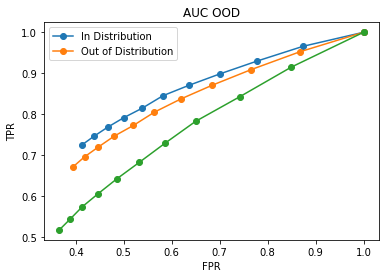

In [37]:
multiplot = buildOutlierPlot_AUC(output_ID, output_OOD,metrics=["energy",'uncert','entropy'], threshold="mean")

In [136]:
output_OOD_edl_100

,x,y,uncert,correct
0,0,49,0.074795,0
1,4,33,0.920631,0
2,4,72,0.631980,0
3,4,51,0.956106,0
4,9,71,0.496918,0
...,...,...,...,...
347,4,7,0.874040,0
348,6,10,0.877300,0
349,6,10,0.816564,0
350,0,68,0.317638,0


In [26]:
### find the optimal threshold between OOD and ID distributions

#combine the sets to find the min and max values for the energy
combined = pd.concat([output_ID,output_OOD])
print(combined)
max_energy = combined['energy'].max()
min_energy = combined['energy'].min()



      x   y    uncert     energy       entropy  calibration correct
0     3   3  0.611689 -18.383732  4.069851e-22      1.000000       1
1     8   8  0.000506 -98.917679 -0.000000e+00      1.000000       1
2     8   8  0.355745 -28.929207  1.759550e-24      1.000000       1
3     0   0  0.020281 -61.801628 -0.000000e+00      1.000000       1
4     6   6  0.859234   0.538187  2.543902e-01      0.957333       1
...  ..  ..       ...        ...           ...           ...     ...
9979  1  27  0.300283 -31.417620  1.202746e-20      1.000000       0
9980  2  30  0.612614 -18.393915  3.585178e-25      1.000000       0
9981  3  52  0.751146  -9.438948  1.814422e-06      1.000000       0
9982  1  74  0.903684   1.034829  3.290858e-10      1.000000       0
9983  6  29  0.224972 -35.289570  1.147606e-18      1.000000       0

[19968 rows x 7 columns]
89.0931396484375 -323.79510498046875


In [140]:

def comparePredictions_Energy(model, input_set, stopping_point=None):
    # stopping_point = None
    num_outputs = len(model.outputs) # the number of output layers for the purpose of providing labels
    #     train_ds, test_ds, validation_ds = (dataset)
    Results=[]
    Pred=[]
    Labels =[]
    Uncert = []
    Outputs = pd.DataFrame()
    Energy = []
    Energy_softmax = []
    Energy_evidence = []
    Energy_alpha = []
    Energy_Mass = []
    Entropy = []
    pAcc=[]
    calibration=[]
    T = 1 ### temperature variable
    for i, (x,y) in enumerate(input_set):
        if stopping_point and i > stopping_point:
            break
        print("prediction: {} of {}".format(i,len(test_ds)),end='\r')
        predictions = model.predict(x)
        for j, prediction in enumerate(predictions):
            evidence =exp_evidence(prediction)
            alpha = evidence +1
            S = sum(alpha)
            E = alpha - 1
            Mass = alpha / S
            u = num_classes / S
            Uncert.append(u.numpy().mean())
            Results.append(np.argmax(prediction))
            Labels.append(np.argmax(y[j]))
            # Energy.append(prediction.mean() -(logsumexp(prediction)))
            Energy.append( -(1 * logsumexp(np.array(prediction)/1)))
            Energy_softmax.append( -(1 * logsumexp(np.array(tf.nn.softmax(prediction))/1)))
            Energy_evidence.append( -(1 * logsumexp(np.array(evidence)/1)))
            Energy_alpha.append( -(1 * logsumexp(np.array(alpha)/1)))
            Energy_Mass.append( -(1 * logsumexp(np.array(Mass)/1)))
            
            
            Entropy.append(calcEntropy_Tensors2(tf.nn.softmax(prediction)).numpy())
            calibration.append(np.amax(tf.nn.softmax(prediction).numpy()))
    _uncert = np.array(Uncert)
    # print(_uncert)
    print("")
    print("avg entropy",_uncert.mean())
    print("avg energy",np.array(Energy).mean())
    df = pd.DataFrame({"x":Results,"y":Labels,"uncert":Uncert,"energy":Energy,"Energy_softmax":Energy_softmax,"Energy_evidence":Energy_evidence,"Energy_alpha":Energy_alpha,"Energy_Mass":Energy_Mass,'entropy':Entropy,'calibration':calibration})
    conditions = [df['x'] == df['y'],df['x'] != df['y']]
    choices = [1, 0]
    df['correct'] = np.select(conditions, choices, default=None)
    return df
# buildCompareDistribPlot(output_ID_energy, output_OOD_energy, ["energy",'Energy_softmax','Energy_evidence','Energy_alpha','Energy_Mass'], "mean",legend=["ID","OOD"])

In [141]:
output_ID_energy =  comparePredictions_Energy(model, test_ds,stopping_point=None)
output_OOD_energy = comparePredictions_Energy(model, test_ds100,stopping_point=None)


prediction: 312 of 313
avg entropy 0.20990698
avg energy -59.24956272488758
prediction: 312 of 313
avg entropy 0.37043014
avg energy -33.23839231808018


In [143]:
def buildCompareDistribPlot(ID,OOD,metrics=["energy"], threshold=None, legend=["In Distribution","Out of Distribution"]):
        if type(metrics ) is not list:
            metrics = [metrics]
        for i, metric in enumerate(metrics):
            _ = plt.hist(ID[metric].tolist(), bins=100)  # arguments are passed to np.histogram
            _ = plt.hist(OOD[metric].tolist(), bins=100,color="red",alpha=0.5)  # arguments are passed to np.histogram
            # plt.title("Histogram with 'auto' bins")
            plt.title(metric + " outliers")
            plt.legend(legend)
            plt.xlabel("entropy")
            plt.ylabel("frequency")
            plt.show()
            if threshold:
                if type(threshold) is list:
                    if i >= len(threshold): #no threshold in the array so treat as None.
                        continue
                    _threshold = threshold[i]
                else:
                    _threshold = threshold
                if _threshold == "mean":
                    _threshold = np.array(OOD[metric]).mean()
                print("OOD accepted with avg ID ",metric," threshold of ",_threshold, ": ", len(OOD.loc[(OOD[metric].tolist() <= _threshold)]), "out of ", len(OOD))
                print("ID accepted with avg ID ",metric," threshold of ",_threshold, ": ", len(ID.loc[(ID[metric] <= _threshold)]), "out of ", len(ID), "with acc of ", len(ID.loc[(ID[metric] <= _threshold) & ID['correct'] == True])/len(ID.loc[(ID[metric] <= _threshold)]))
                print("Overall accuracy of accepted inputs:", len(ID.loc[(ID[metric] <= _threshold) & ID['correct'] == True])/(len(ID.loc[(ID[metric] <= _threshold)])+len(OOD.loc[(OOD[metric] <= _threshold)])))
                Correct = ID.loc[(ID['correct'] == True)]
                # print(len(Correct))
                Incorrect = ID.loc[(ID['correct'] == False)]
                print("overall acc on ID:",len(Correct)/len(ID))

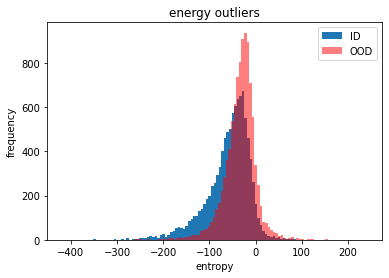

OOD accepted with avg ID  energy  threshold of  -33.23839231808018 :  4458 out of  10000
ID accepted with avg ID  energy  threshold of  -33.23839231808018 :  6787 out of  10000 with acc of  0.7697067923972299
Overall accuracy of accepted inputs: 0.4645620275678079
overall acc on ID: 0.6579


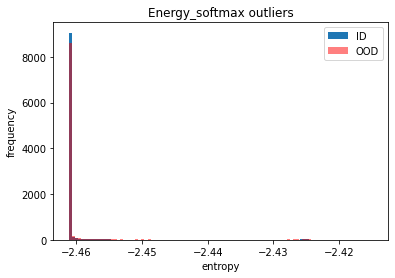

In [ ]:
#EDL _ energy loss
buildCompareDistribPlot(output_ID_energy, output_OOD_energy, ["energy",'Energy_softmax','Energy_evidence','Energy_alpha','Energy_Mass'], "mean",legend=["ID","OOD"])

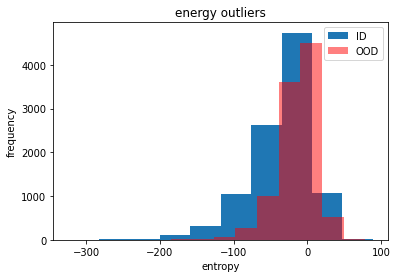

OOD accepted with avg ID  energy  threshold of  -35.59758201863709 :  1555 out of  9984
ID accepted with avg ID  energy  threshold of  -35.59758201863709 :  4079 out of  9984 with acc of  0.883304731551851
Overall accuracy of accepted inputs: 0.6395101171458999
overall acc on ID: 0.6409254807692307


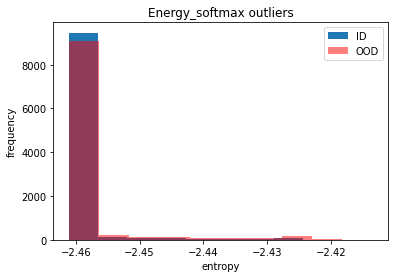

OOD accepted with avg ID  Energy_softmax  threshold of  -2.460042773745954 :  8719 out of  9984
ID accepted with avg ID  Energy_softmax  threshold of  -2.460042773745954 :  9277 out of  9984 with acc of  0.6665948043548561
Overall accuracy of accepted inputs: 0.3436319182040453
overall acc on ID: 0.6409254807692307


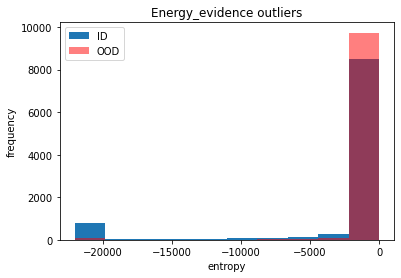

OOD accepted with avg ID  Energy_evidence  threshold of  -2384.261512561295 :  239 out of  9984
ID accepted with avg ID  Energy_evidence  threshold of  -2384.261512561295 :  1457 out of  9984 with acc of  0.9718599862731641
Overall accuracy of accepted inputs: 0.8349056603773585
overall acc on ID: 0.6409254807692307


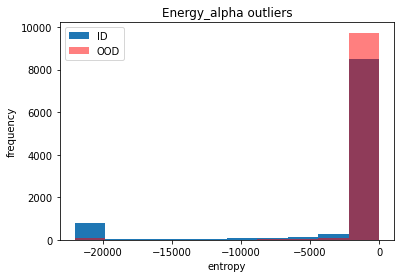

OOD accepted with avg ID  Energy_alpha  threshold of  -2385.2615125646385 :  239 out of  9984
ID accepted with avg ID  Energy_alpha  threshold of  -2385.2615125646385 :  1457 out of  9984 with acc of  0.9718599862731641
Overall accuracy of accepted inputs: 0.8349056603773585
overall acc on ID: 0.6409254807692307


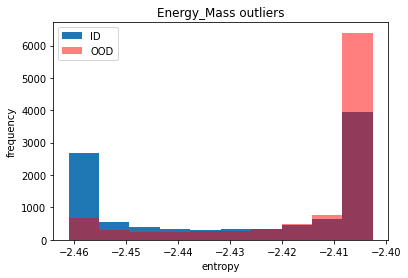

OOD accepted with avg ID  Energy_Mass  threshold of  -2.427978648517567 :  1902 out of  9984
ID accepted with avg ID  Energy_Mass  threshold of  -2.427978648517567 :  4473 out of  9984 with acc of  0.8667560921082048
Overall accuracy of accepted inputs: 0.6081568627450981
overall acc on ID: 0.6409254807692307


In [25]:
buildCompareDistribPlot(output_ID_energy, output_OOD_energy, ["energy",'Energy_softmax','Energy_evidence','Energy_alpha','Energy_Mass'], "mean",legend=["ID","OOD"])

89.0931396484375 -323.79510498046875
1


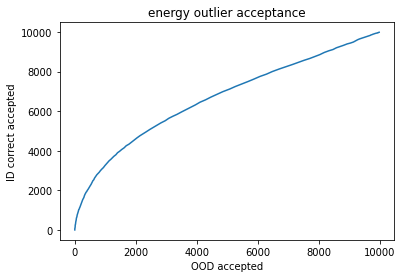

0.9999455 0.00041522982
0.009995303153991698


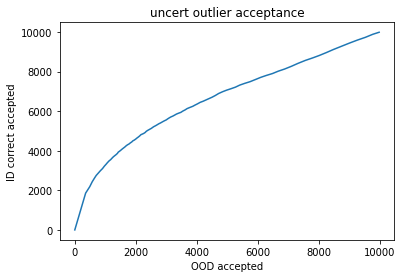

1.8287096 -0.0
0.01828709602355957


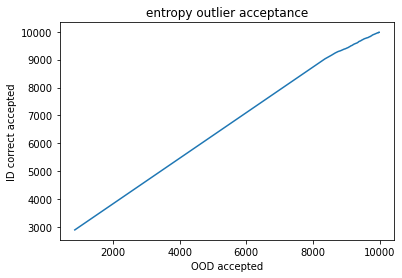

In [121]:
energy_range = range(int(min_energy-1), int(max_energy+1))
metric = "energy"
combined = pd.concat([output_ID,output_OOD])

for metric in ["energy","uncert","entropy"]:

    OOD_accepted= []
    ID_accepted = []
    points =[]
    max_energy = combined[metric].max()
    min_energy = combined[metric].min()
    print(max_energy, min_energy)
    step = min((max_energy - min_energy) /100,1)
    print(step)
    # energy_range = range((min_energy), (max_energy))
    energy_range = np.arange (min_energy, max_energy, step)
    # print(energy_range)
    
    for _threshold in energy_range:

        
        # print(len(output_OOD.loc[output_OOD[metric] <= _threshold]))
        # print(_threshold)
        OOD_accepted.append( len(output_OOD.loc[output_OOD[metric] <= _threshold]))
        # OOD_accepted.append(_threshold)
        # if len(output_ID.loc[(output_ID[metric] <= _threshold)]) > 0:
        # ID_accepted.append( len(output_ID.loc[(output_ID[metric] <= _threshold) & output_ID['correct'] == True]))#/ len(output_ID.loc[(output_ID[metric] <= _threshold)]))
        ID_accepted.append( len(output_ID.loc[(output_ID[metric] <= _threshold) ]))#/ len(output_ID.loc[(output_ID[metric] <= _threshold)]))
        # print(_threshold, len(output_OOD.loc[output_OOD[metric] <= _threshold]),len(output_ID.loc[(output_ID[metric] <= _threshold) ]))
        # if _threshold == 0:
            # points.append([ len(output_OOD.loc[output_OOD[metric] <= _threshold]),len(output_ID.loc[(output_ID[metric] <= _threshold) & output_ID['correct'] == True])])

        # else: 
            # ID_accepted.append(0)
    plt.title(metric + " outlier acceptance")
    plt.plot(OOD_accepted,ID_accepted)
    plt.xlabel("OOD accepted")
    plt.ylabel("ID correct accepted")
    plt.show()


In [50]:
from sklearn.linear_model import LogisticRegression
# all parameters not specified are set to their defaults
logisticRegr = LogisticRegression()

In [77]:
def pdf(x, std, mean):
    const = 1.0 / np.sqrt(2*np.pi*(std**2))
    pdf_normal_dist = const*np.exp(-((x-mean)**2)/(2.0*(std**2)))
    return pdf_normal_dist
x = np.linspace(-200, 100, num=500)
good_pdf = pdf(x,output_ID['energy'].std(),output_ID["energy"].mean())
bad_pdf = pdf(x,output_OOD['energy'].std(),output_OOD["energy"].mean())

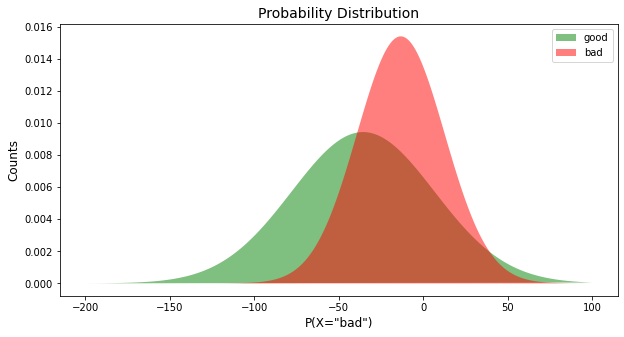

In [85]:
def plot_pdf(good_pdf, bad_pdf, ax):
    ax.fill(x, good_pdf, "g", alpha=0.5)
    ax.fill(x, bad_pdf,"r", alpha=0.5)
    # ax.set_xlim([0,1])
    # ax.set_ylim([0,5])
    ax.set_title("Probability Distribution", fontsize=14)
    ax.set_ylabel('Counts', fontsize=12)
    ax.set_xlabel('P(X="bad")', fontsize=12)
    ax.legend(["good","bad"])

x = np.linspace(-200, 100, num=500)
good_pdf = pdf(x,output_ID['energy'].std(),output_ID["energy"].mean())
bad_pdf = pdf(x,output_OOD['energy'].std(),output_OOD["energy"].mean())
fig, ax = plt.subplots(1,1, figsize=(10,5))
plot_pdf(good_pdf, bad_pdf, ax)
    

    

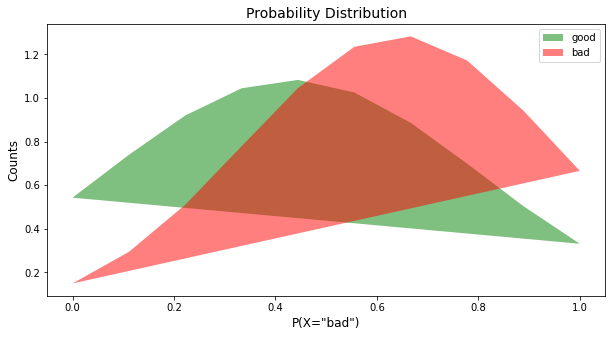

In [90]:
x = np.linspace(0, 1, num=100)
good_pdf = pdf(x,output_ID['uncert'].std(),output_ID["uncert"].mean())
bad_pdf = pdf(x,output_OOD['uncert'].std(),output_OOD["uncert"].mean())
fig, ax = plt.subplots(1,1, figsize=(10,5))
plot_pdf(good_pdf, bad_pdf, ax)

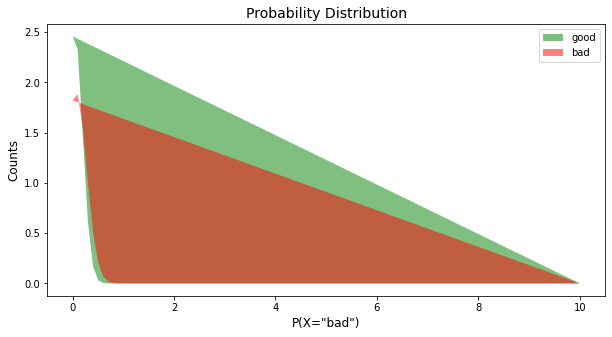

In [97]:
x = np.linspace(0, 10, num=100)
good_pdf = pdf(x,output_ID['entropy'].std(),output_ID["entropy"].mean())
bad_pdf = pdf(x,output_OOD['entropy'].std(),output_OOD["entropy"].mean())
fig, ax = plt.subplots(1,1, figsize=(10,5))
plot_pdf(good_pdf, bad_pdf, ax)

In [82]:
def plot_roc(good_pdf, bad_pdf, ax):
    #Total
    total_bad = np.sum(bad_pdf)
    total_good = np.sum(good_pdf)
    #Cumulative sum
    cum_TP = 0
    cum_FP = 0
    #TPR and FPR list initialization
    TPR_list=[]
    FPR_list=[]
    #Iteratre through all values of x
    for i in range(len(x)):
        #We are only interested in non-zero values of bad
        if bad_pdf[i]>0:
            cum_TP+=bad_pdf[len(x)-1-i]
            cum_FP+=good_pdf[len(x)-1-i]
        FPR=cum_FP/total_good
        TPR=cum_TP/total_bad
        TPR_list.append(TPR)
        FPR_list.append(FPR)
    #Calculating AUC, taking the 100 timesteps into account
    auc=np.sum(TPR_list)/500
    #Plotting final ROC curve
    ax.plot(FPR_list, TPR_list)
    ax.plot(x,x, "--")
    ax.set_xlim([0,1])
    ax.set_ylim([0,1])
    ax.set_title("ROC Curve", fontsize=14)
    ax.set_ylabel('TPR', fontsize=12)
    ax.set_xlabel('FPR', fontsize=12)
    ax.grid()
    ax.legend(["AUC=%.3f"%auc])

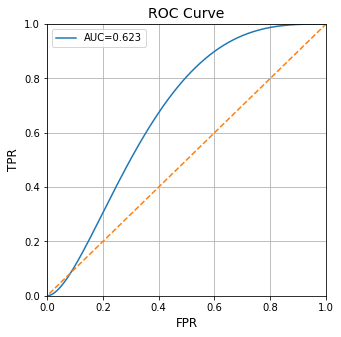

In [83]:
fig, ax = plt.subplots(1,1, figsize=(5,5))
plot_roc(good_pdf, bad_pdf, ax)

In [40]:
x = np.array([1.,2.,3.,4.,5.,6.])
tf.nn.softmax(x)

<tf.Tensor: shape=(6,), dtype=float64, numpy=
array([0.00426978, 0.01160646, 0.03154963, 0.08576079, 0.23312201,
       0.63369132])>

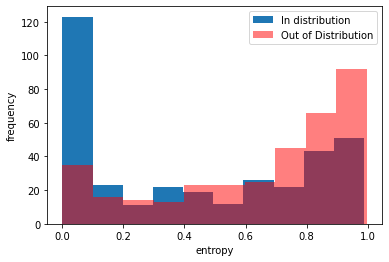

In [137]:
def buildOutlierPlot(ID,OOD,threshold=None):
    _ = plt.hist(ID['uncert'], bins=10)  # arguments are passed to np.histogram
    _ = plt.hist(OOD['uncert'], bins=10,color="red",alpha=0.5)  # arguments are passed to np.histogram
    # plt.title("Histogram with 'auto' bins")
    plt.legend(["In distribution","Out of Distribution"])
    plt.xlabel("entropy")
    plt.ylabel("frequency")
    plt.show()
    if threshold:
        print("OOD accepted with avg ID entropy threshold of ",threshold, ": ", len(OOD.loc[(OOD['uncert'] <= threshold)]), "out of ", len(OOD))
        print("ID accepted with avg ID entropy threshold of ",threshold, ": ", len(ID.loc[(ID['uncert'] <= threshold)]), "out of ", len(ID), "with acc of ", len(ID.loc[(ID['uncert'] <= threshold) & ID['correct'] == True])/len(ID.loc[(ID['uncert'] <= threshold)]))
        Correct = ID.loc[(ID['correct'] == True)]
        Incorrect = ID.loc[(ID['correct'] == False)]
        print("overall acc on ID:",len(Correct)/len(ID))

# buildOutlierPlot(outputs_test, outputs100, 0.4392441)

buildOutlierPlot(output_ID_edl, output_OOD_edl_100, None)

In [100]:
# num_right = len(right_score)
# num_wrong = len(wrong_score)
# print(num_right)
# print(num_wrong)
# print('Error Rate {:.2f}'.format(100 * num_wrong / (num_wrong + num_right)))

64
64
Error Rate 50.00


In [ ]:

outputs_test = evaluate.getPredictions_energy(model,test_ds)
print(outputs_test)
        
outputs100 = evaluate.getPredictions_energy(model,test_ds100)
print(outputs100)


[]ediction: 311 of 312
avg entropy nan


C:\Users\Sanity\AppData\Local\conda\conda\envs\py36\lib\site-packages\ipykernel_launcher.py:27: RuntimeWarning: Mean of empty slice.
C:\Users\Sanity\AppData\Local\conda\conda\envs\py36\lib\site-packages\numpy\core\_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


      x  y  confidence_alea_uncert.  entropy_of_expected  expected_entropy  \
0     8  3                 0.814705            -0.482196         -0.482049   
1     8  8                 0.999999            -0.000019         -0.000019   
2     0  8                 0.525802            -0.693304         -0.693240   
3     0  0                 0.999313            -0.005692         -0.005692   
4     6  6                 0.990790            -0.055615         -0.055382   
...  .. ..                      ...                  ...               ...   
9979  5  3                 0.718007            -0.610635         -0.609681   
9980  0  0                 0.964415            -0.154899         -0.154828   
9981  7  4                 0.998228            -0.014470         -0.014319   
9982  4  2                 0.999989            -0.000162         -0.000158   
9983  1  0                 1.000000            -0.000004         -0.000004   

      mutual_information          EPKL  differential_entropy   

In [77]:
def buildOutlierPlot_energy(ID,OOD,threshold=None):
    for k in ['confidence_alea_uncert.','entropy_of_expected','expected_entropy','mutual_information','EPKL','differential_entropy']:
        _ = plt.hist(ID[k].tolist(), bins=10)  # arguments are passed to np.histogram
        _ = plt.hist(OOD[k].tolist(), bins=10,color="red",alpha=0.5)  # arguments are passed to np.histogram
        # plt.title("Histogram with 'auto' bins")
        plt.title(k)
        plt.legend(["In distribution","Out of Distribution"])
        plt.xlabel("entropy")
        plt.ylabel("frequency")
        plt.show()
        # print("OOD accepted with avg ID entropy threshold of ",threshold, ": ", len(OOD.loc[(OOD['uncert'] <= threshold)]), "out of ", len(OOD))
        # print("ID accepted with avg ID entropy threshold of ",threshold, ": ", len(ID.loc[(ID['uncert'] <= threshold)]), "out of ", len(ID), "with acc of ", len(ID.loc[(ID['uncert'] <= threshold) & ID['correct'] == True])/len(ID.loc[(ID['uncert'] <= threshold)]))
        # Correct = ID.loc[(ID['correct'] == True)]
        # Incorrect = ID.loc[(ID['correct'] == False)]
        # print("overall acc on ID:",len(Correct)/len(ID))
    
# buildOutlierPlot_energy(outputs_test, outputs100, None)

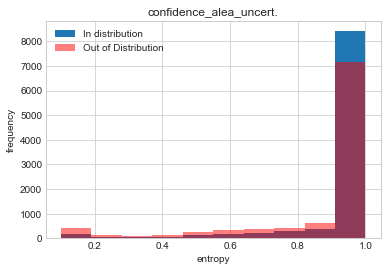

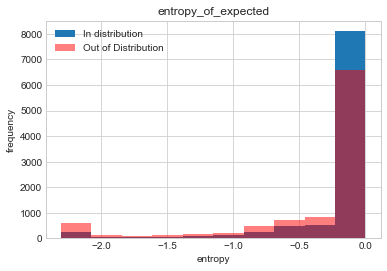

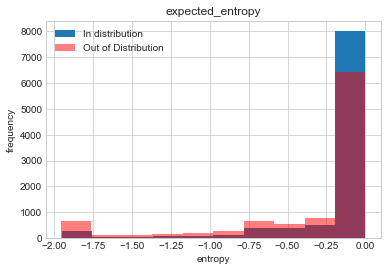

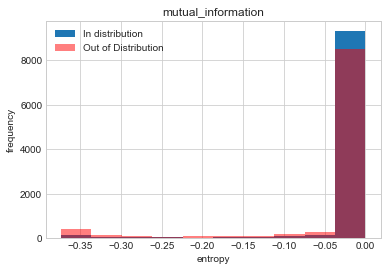

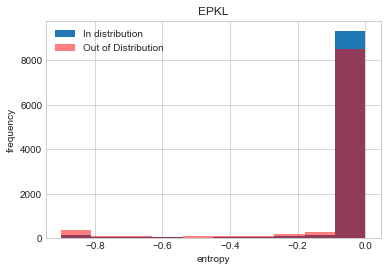

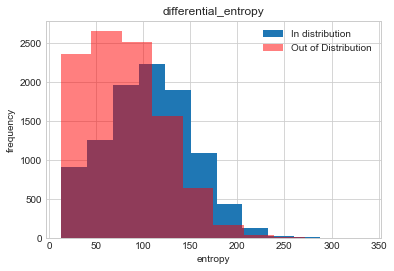

In [78]:
buildOutlierPlot_energy(outputs_test,outputs100)

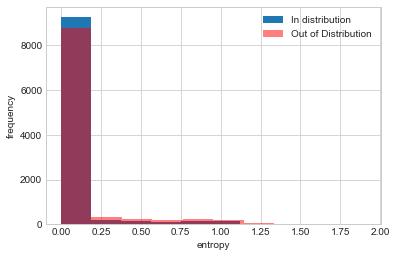

OOD accepted with avg ID entropy threshold of  0.051234607 :  8231 out of  9984
ID accepted with avg ID entropy threshold of  0.051234607 :  8968 out of  9984 with acc of  0.6952497769848349
overall acc on ID: 0.65625


In [172]:
buildOutlierPlot(outputs_test, outputs100, 0.051234607)

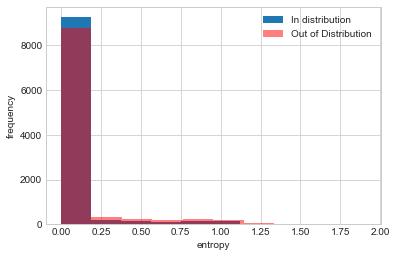

OOD accepted with avg ID entropy threshold of  0.4392441 :  9156 out of  9984
ID accepted with avg ID entropy threshold of  0.4392441 :  9494 out of  9984 with acc of  0.6754792500526648
overall acc on ID: 0.65625


(50000, 32, 32, 3)
<BatchDataset element_spec=(TensorSpec(shape=(32, 32, 32, 3), dtype=tf.uint8, name=None), TensorSpec(shape=(32, 100), dtype=tf.float32, name=None))>


      x  y    uncert correct
4     4  6  0.930254       0
5     5  6  3.623051       0
6     9  1  1.296380       0
7     6  6  2.699459       1
11    9  9  0.004538       1
...  .. ..       ...     ...
9975  7  7  0.004538       1
9976  5  5  0.979602       1
9977  5  5  0.282922       1
9978  4  7  0.796550       0
9981  4  4  2.363454       1

[5065 rows x 4 columns]
      x  y    uncert correct
0     3  3  9.289042       1
3     0  0  9.048504       1
7     6  6  2.699459       1
8     3  3  7.678715       1
9     1  1  6.884835       1
...  .. ..       ...     ...
9975  7  7  0.004538       1
9976  5  5  0.979602       1
9977  5  5  0.282922       1
9979  3  3  8.626763       1
9981  4  4  2.363454       1

[6483 rows x 4 columns]


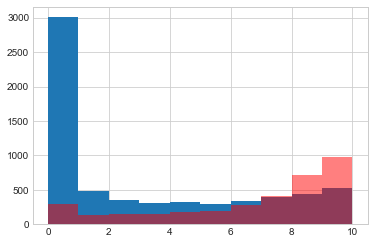

In [117]:
threshold = 4.39244132
accepted = outputs.loc[(outputs['uncert'] <= threshold)]
print(accepted)

import matplotlib.pyplot as plt
Correct = outputs.loc[(outputs['correct'] == True)]
Incorrect = outputs.loc[(outputs['correct'] == False)]
print(Correct)
_ = plt.hist(Correct['uncert'].tolist(), bins=10)  # arguments are passed to np.histogram
_ = plt.hist(Incorrect['uncert'].tolist(), bins=10,color="red",alpha=0.5)  # arguments are passed to np.histogram
# plt.title("Histogram with 'auto' bins")
plt.show()

In [130]:

outputs100 = getPredictions(model,test_ds100)
print(outputs100)

[0.23711371 0.67648697 0.85404116 ... 0.7878681  0.66152674 0.10553702]
avg entropy 0.66300267
      x   y    uncert correct
0     0  49  0.237114       0
1     4  33  0.676487       0
2     4  72  0.854041       0
3     1  51  0.115120       0
4     1  71  0.842340       0
...  ..  ..       ...     ...
9979  3  27  0.366997       0
9980  8  30  0.636400       0
9981  9  52  0.787868       0
9982  6  74  0.661527       0
9983  6  29  0.105537       0

[9984 rows x 4 columns]


      x   y    uncert correct
0     0  49  0.237114       0
3     1  51  0.115120       0
6     4  15  0.370688       0
9     7   0  0.156786       0
10    3  71  0.411594       0
...  ..  ..       ...     ...
9970  6  18  0.008494       0
9972  8  26  0.239801       0
9974  8  11  0.308005       0
9979  3  27  0.366997       0
9983  6  29  0.105537       0

[2403 rows x 4 columns]
      x  y    uncert correct
200   6  6  0.887254       1
267   1  1  0.786784       1
268   6  6  0.806364       1
476   8  8  0.453028       1
648   7  7  0.866996       1
...  .. ..       ...     ...
9524  1  1  0.681051       1
9853  4  4  0.495359       1
9857  9  9  0.902897       1
9874  7  7  0.935731       1
9945  4  4  0.835873       1

[84 rows x 4 columns]


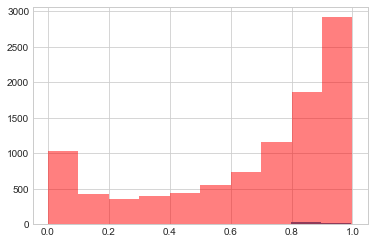

In [131]:
threshold = 0.4392441
accepted = outputs100.loc[(outputs100['uncert'] <= threshold)]
print(accepted)

import matplotlib.pyplot as plt
Correct = outputs100.loc[(outputs100['correct'] == True)]
Incorrect = outputs100.loc[(outputs100['correct'] == False)]
print(Correct)
_ = plt.hist(Correct['uncert'].tolist(), bins=10)  # arguments are passed to np.histogram
_ = plt.hist(Incorrect['uncert'].tolist(), bins=10,color="red",alpha=0.5)  # arguments are passed to np.histogram
# plt.title("Histogram with 'auto' bins")
plt.show()

      x  y    uncert correct
200   6  6  0.887254       1
267   1  1  0.786784       1
268   6  6  0.806364       1
476   8  8  0.453028       1
648   7  7  0.866996       1
...  .. ..       ...     ...
9524  1  1  0.681051       1
9853  4  4  0.495359       1
9857  9  9  0.902897       1
9874  7  7  0.935731       1
9945  4  4  0.835873       1

[84 rows x 4 columns]


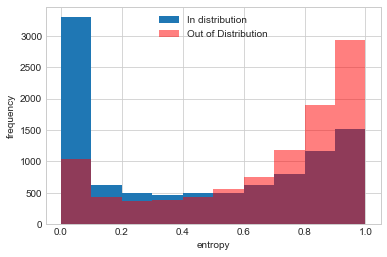

OOD accepted with avg ID entropy threshold of  0.4392441 :  2403 out of  9984
ID accepted with avg ID entropy threshold of  0.4392441 :  5065 out of  9984 with acc of  0.8452122408687068


In [140]:
def buildOutlierPlot(ID,OOD,threshold):
    _ = plt.hist(ID['uncert'].tolist(), bins=10)  # arguments are passed to np.histogram
    _ = plt.hist(OOD['uncert'].tolist(), bins=10,color="red",alpha=0.5)  # arguments are passed to np.histogram
    # plt.title("Histogram with 'auto' bins")
    plt.legend(["In distribution","Out of Distribution"])
    plt.xlabel("entropy")
    plt.ylabel("frequency")
    plt.show()
    print("OOD accepted with avg ID entropy threshold of ",threshold, ": ", len(OOD.loc[(OOD['uncert'] <= threshold)]), "out of ", len(OOD))
    print("ID accepted with avg ID entropy threshold of ",threshold, ": ", len(ID.loc[(ID['uncert'] <= threshold)]), "out of ", len(ID), "with acc of ", len(ID.loc[(ID['uncert'] <= threshold) & ID['correct'] == True])/len(ID.loc[(ID['uncert'] <= threshold)]))
    Correct = ID.loc[(ID['correct'] == True)]
    Incorrect = ID.loc[(ID['correct'] == False)]
    print("overall acc on ID:",len(Correct)/len(ID))
    
buildOutlierPlot(outputs_test, outputs100, 0.4392441)

In [142]:
Correct = outputs_test.loc[(outputs_test['correct'] == True)]
Incorrect = outputs_test.loc[(outputs_test['correct'] == False)]
print(len(Correct)/len(outputs_test))

0.6493389423076923


In [152]:
def entropyMetric_old():
    def entropy(p, y_hat):
        #METRIC OF THE mean of uncertainity
        val = y_hat * tf.math.log(y_hat)/tf.math.log(tf.constant(2, dtype=y_hat.dtype))
        sumEntropies =  tf.reduce_sum(tf.boolean_mask(val,tf.math.is_finite(val)))
        return -sumEntropies
    return entropy

loss = tf.keras.losses.CategoricalCrossentropy(from_logits=True)
model = keras.models.load_model("./models/cifaroutlier_blank.hdf5")
model.compile(optimizer='adam',
              loss=loss,
              metrics=['accuracy',entropyMetric_old()])

history = model.fit(train_ds, epochs=10)

Epoch 1/10
1406/1406 [==============================] - 7s 4ms/step - loss: 1.7714 - accuracy: 0.3800 - entropy: -269.5092
Epoch 2/10
1406/1406 [==============================] - 6s 4ms/step - loss: 1.3332 - accuracy: 0.5236 - entropy: -547.2267
Epoch 3/10
1406/1406 [==============================] - 6s 4ms/step - loss: 1.1859 - accuracy: 0.5852 - entropy: -793.7892
Epoch 4/10
1406/1406 [==============================] - 6s 4ms/step - loss: 1.0911 - accuracy: 0.6173 - entropy: -1051.1556
Epoch 5/10
1406/1406 [==============================] - 6s 5ms/step - loss: 1.0100 - accuracy: 0.6464 - entropy: -1337.5408
Epoch 6/10
1406/1406 [==============================] - 7s 5ms/step - loss: 0.9382 - accuracy: 0.6712 - entropy: -1744.2469
Epoch 7/10
1406/1406 [==============================] - 6s 4ms/step - loss: 0.8893 - accuracy: 0.6900 - entropy: -2221.8240
Epoch 8/10
1406/1406 [==============================] - 6s 4ms/step - loss: 0.8389 - accuracy: 0.7068 - entropy: -2834.1406
Epoch 9/10


In [155]:
import math
num_classes=10
def getPredictions(model, input_set):
    stopping_point = None
    num_outputs = len(model.outputs) # the number of output layers for the purpose of providing labels
    #     train_ds, test_ds, validation_ds = (dataset)
    Results=[]
    Pred=[]
    Labels =[]
    Uncert = []
    Outputs = pd.DataFrame()
    pAcc=[]
    for i, (x,y) in enumerate(input_set):
        if stopping_point and i > stopping_point:
            break
        print("prediction: {} of {}".format(i,len(test_ds)),end='\r')
        predictions = model.predict(x)
        for j, prediction in enumerate(predictions):
            y_hat =tf.nn.softmax(prediction)
            val = y_hat * tf.math.log(y_hat)/tf.math.log(tf.constant(2, dtype=y_hat.dtype))
            u =  -tf.reduce_sum(tf.boolean_mask(val,tf.math.is_finite(val)))
            Uncert.append(u.numpy().mean())
            Results.append(np.argmax(prediction))
            Labels.append(np.argmax(y[j]))
    _uncert = np.array(Uncert)
    print(_uncert)
    print("avg entropy",_uncert.mean())
    df = pd.DataFrame({"x":Results,"y":Labels,"uncert":Uncert})
    conditions = [df['x'] == df['y'],df['x'] != df['y']]
    choices = [1, 0]
    df['correct'] = np.select(conditions, choices, default=None)
    return df

outputs_test2 = getPredictions(model,test_ds)
print(outputs_test2)
# Correct = outputs.loc[(outputs['correct'] == True)].groupby("correct")["uncert"].mean().iloc[0]
# Incorrect = outputs.loc[(outputs['correct'] == False)].groupby("correct")["uncert"].mean().iloc[0]
# print("Correct", Correct, "incorrect", Incorrect)
# print("overallAcc", len(outputs.loc[(outputs['correct'] == True)])/len(outputs))
model.evaluate(test_ds)


[2.9127266  0.28847754 1.7646978  ... 1.5443833  2.1113863  0.4810803 ]
avg entropy 1.0540112
      x  y    uncert correct
0     8  3  2.912727       0
1     8  8  0.288478       1
2     0  8  1.764698       0
3     0  0  0.412173       1
4     6  6  1.835032       1
...  .. ..       ...     ...
9979  3  3  0.222059       1
9980  0  0  0.102112       1
9981  7  4  1.544383       0
9982  3  2  2.111386       0
9983  1  0  0.481080       0

[9984 rows x 4 columns]


In [156]:
outputs100_2 = getPredictions(model,test_ds100)
print(outputs100_2)

[0.7781605 2.2761638 1.5880288 ... 0.7205749 2.28415   1.5985643]
avg entropy 1.5279474
      x   y    uncert correct
0     2  49  0.778161       0
1     4  33  2.276164       0
2     0  72  1.588029       0
3     9  51  1.273938       0
4     8  71  2.651380       0
...  ..  ..       ...     ...
9979  2  27  0.562674       0
9980  0  30  1.932048       0
9981  7  52  0.720575       0
9982  5  74  2.284150       0
9983  2  29  1.598564       0

[9984 rows x 4 columns]


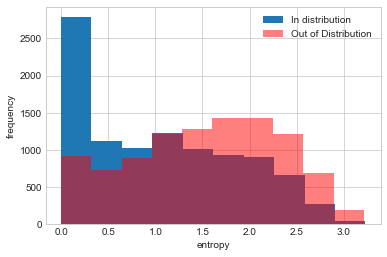

OOD accepted with avg ID entropy threshold of  1.5279474 :  4726 out of  9984
ID accepted with avg ID entropy threshold of  1.5279474 :  6876 out of  9984 with acc of  0.7232402559627691
overall acc on ID: 0.6126802884615384


In [161]:
def buildOutlierPlot(ID,OOD,threshold):
    _ = plt.hist(ID['uncert'].tolist(), bins=10)  # arguments are passed to np.histogram
    _ = plt.hist(OOD['uncert'].tolist(), bins=10,color="red",alpha=0.5)  # arguments are passed to np.histogram
    # plt.title("Histogram with 'auto' bins")
    plt.legend(["In distribution","Out of Distribution"])
    plt.xlabel("entropy")
    plt.ylabel("frequency")
    plt.show()
    print("OOD accepted with avg ID entropy threshold of ",threshold, ": ", len(OOD.loc[(OOD['uncert'] <= threshold)]), "out of ", len(OOD))
    print("ID accepted with avg ID entropy threshold of ",threshold, ": ", len(ID.loc[(ID['uncert'] <= threshold)]), "out of ", len(ID), "with acc of ", len(ID.loc[(ID['uncert'] <= threshold) & ID['correct'] == True])/len(ID.loc[(ID['uncert'] <= threshold)]))
    Correct = ID.loc[(ID['correct'] == True)]
    Incorrect = ID.loc[(ID['correct'] == False)]
    print("overall acc on ID:",len(Correct)/len(ID))
    
buildOutlierPlot(outputs_test2, outputs100_2, 1.5279474)

In [165]:
def MAEBM(annealing):
    def loss(labels, outputs):
        # tf.print(outputs)
        evidence = tf.exp(outputs) #activation function
        # tf.print(evidence)
        alpha = evidence + 1
        S = tf.reduce_sum(alpha)
        # tf.print(S)
        alpha_0 = tf.fill(alpha.shape,S)
        UCE_loss = tf.reduce_mean(labels * (tf.compat.v1.digamma(alpha_0) - tf.compat.v1.digamma(alpha)))
        # print("loss_1",UCE_loss)
        
        
        UCE_loss  +=  0.0001  * (tf.reduce_sum(tf.compat.v1.lgamma(alpha)) - tf.compat.v1.lgamma(S) -
                (len(alpha) - S) * tf.compat.v1.digamma(S) -
                ((alpha - 1.0) * tf.reduce_sum(tf.compat.v1.digamma(alpha))))
        # tf.print(UCE_loss)
        return UCE_loss
    return loss 
def entropyMetric():
    def entropy(p, logits):
        #METRIC OF THE mean of uncertainity
        evidence =exp_evidence(logits)
        alpha = evidence +1
        S = tf.reduce_sum(alpha)
        Mass = alpha / S
        u = num_classes / S
        return (tf.reduce_mean(u)) # Note the `axis=-1`
    return entropy

lambda_callback = lambda_update(100)
loss = MAEBM(lambda_callback)
model = keras.models.load_model("./models/cifaroutlier_blank.hdf5")
model.compile(optimizer='adam',
              loss=loss,
              metrics=['accuracy',entropyMetric()])

history = model.fit(train_ds, epochs=10,callbacks=[lambda_callback])


annealing coef updated to: 0
Epoch 1/10
 753/1406 [===============>..............] - ETA: 3s - loss: nan - accuracy: 0.1011 - entropy: nan

KeyboardInterrupt: 